<a href="https://colab.research.google.com/github/mohamedHashem250/DeepLearningArchitecture/blob/main/FC_neuralNetworks/NeuralNetwork_finetuningParameterswithOptuna_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##In this notebook, we use oputna to automate hyperparameters [neurons, optimizer,batch_size,epochs]
#we use one hidden layer and variable number of neurons.

In [1]:
import tensorflow as tf
import keras
from sklearn.datasets import make_circles

#making 1000 samples
n_samples = 1000
#creating cicles

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [10]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


In [2]:
import numpy as np
import random

In [3]:
import pandas as pd
circles = pd.DataFrame({
    "X0":X[:,0],
    "X1":X[:,1],
    "label":y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


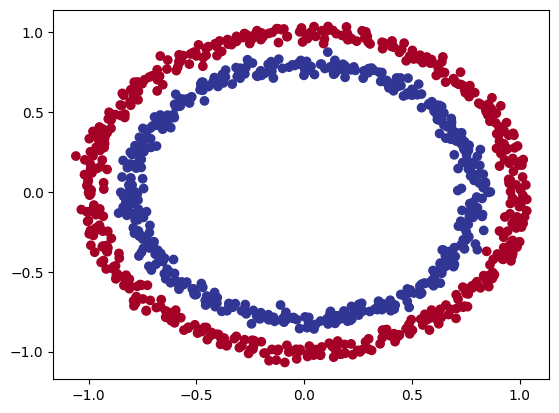

In [4]:
#visualizing with plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [5]:
#split data into train and test sets:
X_train , y_train = X[:800], y[:800]
X_test , y_test = X[800:], y[800:]

X_train.shape , X_test.shape

((800, 2), (200, 2))

In [6]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [28]:
def create_model(trial):
  neurons = trial.suggest_categorical('neurons', [4,8,16,32,64])
  model = keras.Sequential([
      tf.keras.layers.Dense(units = neurons,activation = 'relu'),
      tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
  ])
  optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd','rmsprop'])
  #learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model


In [15]:
intial_seed = 42

In [30]:
def objective(trial):
  #to produce the the same result every run
  #tf.random.set_seed(intial_seed)
  #np.random.seed(intial_seed)
  #random.seed(intial_seed)
  #Suggest hyperparameters:
  batch_size = trial.suggest_categorical("batch_size", [16,32, 64])
  epoch = trial.suggest_categorical("epoch", [25,40, 60])
  suggested_model = create_model(trial)

  try:
    #train model:
    history = suggested_model.fit(X_train, y_train, epochs = epoch, batch_size= batch_size, verbose = 2, validation_data = (X_test,y_test) )
    #Evaluate Performance :
    val_acc = np.mean(history.history['val_accuracy'])
  finally:
    print("finished .. ")
    #cleanup to release memory:
    tf.keras.backend.clear_session() #clear the global graph
    #del model
  return val_acc

In [31]:
#first we need to try all hyperparameters like searchgrid
#so we can use GridSampler to "Fore Exploration"
#Define the serach space:
search_space = {
    'batch_size':  [16,32, 64],
    'epoch' :[25,40, 60],
    'optimizer': ['adam', 'sgd','rmsprop'],
    'neurons' : [4,8,16,32,64]
}
#create a study with GridSampler:
sampler = optuna.samplers.GridSampler(search_space)


In [32]:
study = optuna.create_study(sampler = sampler, direction = 'maximize')


[I 2025-01-19 20:36:52,710] A new study created in memory with name: no-name-e591a463-163f-4949-91d0-367b863a6aa8


In [26]:
#optimize:
study.optimize(objective, n_trials = 3*3*3)#the number of search space 3*3*3

Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.4825 - loss: 0.7281 - val_accuracy: 0.5700 - val_loss: 0.6902
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.4812 - loss: 0.7211 - val_accuracy: 0.5650 - val_loss: 0.6876
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.4787 - loss: 0.7164 - val_accuracy: 0.5700 - val_loss: 0.6858
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.4725 - loss: 0.7122 - val_accuracy: 0.5600 - val_loss: 0.6852
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.4712 - loss: 0.7092 - val_accuracy: 0.5600 - val_loss: 0.6850
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.4663 - loss: 0.7066 - val_accuracy: 0.5700 - val_loss: 0.6848
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.4675 - loss: 0.7043 - val_accuracy: 0.5650 - val_loss: 0.6847
Epoch 8/25
50/50 - 0s - 2ms/step - accuracy: 0.4700 - loss: 0.7026 - val_accuracy: 0.5700 - val_loss: 0.6850
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.4700 - loss: 0.7011 - val_accuracy: 0.5600 - val_loss: 0.6850
Epoch 10/25
50/50 

[I 2025-01-19 20:29:00,920] Trial 0 finished with value: 0.5600000023841858 and parameters: {'batch_size': 16, 'epoch': 25, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/60
13/13 - 1s - 115ms/step - accuracy: 0.4925 - loss: 0.7400 - val_accuracy: 0.5100 - val_loss: 0.7227
Epoch 2/60
13/13 - 0s - 30ms/step - accuracy: 0.4938 - loss: 0.7359 - val_accuracy: 0.5050 - val_loss: 0.7198
Epoch 3/60
13/13 - 0s - 8ms/step - accuracy: 0.4900 - loss: 0.7326 - val_accuracy: 0.5050 - val_loss: 0.7170
Epoch 4/60
13/13 - 0s - 9ms/step - accuracy: 0.4938 - loss: 0.7293 - val_accuracy: 0.5100 - val_loss: 0.7146
Epoch 5/60
13/13 - 0s - 9ms/step - accuracy: 0.4900 - loss: 0.7264 - val_accuracy: 0.5050 - val_loss: 0.7124
Epoch 6/60
13/13 - 0s - 12ms/step - accuracy: 0.4888 - loss: 0.7238 - val_accuracy: 0.5100 - val_loss: 0.7103
Epoch 7/60
13/13 - 0s - 11ms/step - accuracy: 0.4913 - loss: 0.7213 - val_accuracy: 0.5150 - val_loss: 0.7087
Epoch 8/60
13/13 - 0s - 9ms/step - accuracy: 0.4938 - loss: 0.7191 - val_accuracy: 0.5150 - val_loss: 0.7069
Epoch 9/60
13/13 - 0s - 9ms/step - accuracy: 0.4925 - loss: 0.7170 - val_accuracy: 0.5150 - val_loss: 0.7054
Epoch 10/60
13

[I 2025-01-19 20:29:10,045] Trial 1 finished with value: 0.5292499949534734 and parameters: {'batch_size': 64, 'epoch': 60, 'optimizer': 'adam'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/40
25/25 - 1s - 45ms/step - accuracy: 0.5175 - loss: 0.7313 - val_accuracy: 0.4400 - val_loss: 0.7599
Epoch 2/40
25/25 - 0s - 6ms/step - accuracy: 0.5125 - loss: 0.7249 - val_accuracy: 0.4300 - val_loss: 0.7531
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.5050 - loss: 0.7202 - val_accuracy: 0.4350 - val_loss: 0.7466
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5113 - loss: 0.7161 - val_accuracy: 0.4350 - val_loss: 0.7420
Epoch 5/40
25/25 - 0s - 11ms/step - accuracy: 0.5075 - loss: 0.7131 - val_accuracy: 0.4300 - val_loss: 0.7376
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5113 - loss: 0.7104 - val_accuracy: 0.4350 - val_loss: 0.7335
Epoch 7/40
25/25 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.7081 - val_accuracy: 0.4350 - val_loss: 0.7307
Epoch 8/40
25/25 - 0s - 3ms/step - accuracy: 0.5100 - loss: 0.7065 - val_accuracy: 0.4350 - val_loss: 0.7278
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5088 - loss: 0.7047 - val_accuracy: 0.4400 - val_loss: 0.7256
Epoch 10/40
25/25

[I 2025-01-19 20:29:21,830] Trial 2 finished with value: 0.4422500029206276 and parameters: {'batch_size': 32, 'epoch': 40, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/60
25/25 - 2s - 62ms/step - accuracy: 0.4850 - loss: 0.7207 - val_accuracy: 0.5500 - val_loss: 0.6862
Epoch 2/60
25/25 - 0s - 4ms/step - accuracy: 0.4800 - loss: 0.7155 - val_accuracy: 0.5500 - val_loss: 0.6847
Epoch 3/60
25/25 - 0s - 6ms/step - accuracy: 0.4750 - loss: 0.7118 - val_accuracy: 0.5500 - val_loss: 0.6839
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.4675 - loss: 0.7087 - val_accuracy: 0.5600 - val_loss: 0.6832
Epoch 5/60
25/25 - 0s - 3ms/step - accuracy: 0.4613 - loss: 0.7063 - val_accuracy: 0.5550 - val_loss: 0.6829
Epoch 6/60
25/25 - 0s - 3ms/step - accuracy: 0.4550 - loss: 0.7041 - val_accuracy: 0.5600 - val_loss: 0.6829
Epoch 7/60
25/25 - 0s - 5ms/step - accuracy: 0.4762 - loss: 0.7023 - val_accuracy: 0.5550 - val_loss: 0.6831
Epoch 8/60
25/25 - 0s - 3ms/step - accuracy: 0.4837 - loss: 0.7008 - val_accuracy: 0.5550 - val_loss: 0.6833
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.4863 - loss: 0.6990 - val_accuracy: 0.5600 - val_loss: 0.6837
Epoch 10/60
25/25 

[I 2025-01-19 20:29:35,861] Trial 3 finished with value: 0.516750002404054 and parameters: {'batch_size': 32, 'epoch': 60, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/40
50/50 - 1s - 23ms/step - accuracy: 0.4950 - loss: 0.7275 - val_accuracy: 0.5050 - val_loss: 0.7150
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4875 - loss: 0.7165 - val_accuracy: 0.5100 - val_loss: 0.7101
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.4925 - loss: 0.7098 - val_accuracy: 0.5050 - val_loss: 0.7073
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.4913 - loss: 0.7054 - val_accuracy: 0.4850 - val_loss: 0.7062
Epoch 5/40
50/50 - 0s - 2ms/step - accuracy: 0.4925 - loss: 0.7022 - val_accuracy: 0.4850 - val_loss: 0.7052
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.4825 - loss: 0.7002 - val_accuracy: 0.4850 - val_loss: 0.7047
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.4900 - loss: 0.6987 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.4712 - loss: 0.6972 - val_accuracy: 0.4850 - val_loss: 0.7040
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.4775 - loss: 0.6960 - val_accuracy: 0.4800 - val_loss: 0.7037
Epoch 10/40
50/50 

[I 2025-01-19 20:29:44,057] Trial 4 finished with value: 0.4888749994337559 and parameters: {'batch_size': 16, 'epoch': 40, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/25
25/25 - 1s - 52ms/step - accuracy: 0.4938 - loss: 0.7508 - val_accuracy: 0.5300 - val_loss: 0.7284
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4913 - loss: 0.7416 - val_accuracy: 0.5250 - val_loss: 0.7213
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.4913 - loss: 0.7345 - val_accuracy: 0.5350 - val_loss: 0.7159
Epoch 4/25
25/25 - 0s - 5ms/step - accuracy: 0.4875 - loss: 0.7287 - val_accuracy: 0.5300 - val_loss: 0.7120
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.4825 - loss: 0.7243 - val_accuracy: 0.5250 - val_loss: 0.7085
Epoch 6/25
25/25 - 0s - 3ms/step - accuracy: 0.4837 - loss: 0.7204 - val_accuracy: 0.5400 - val_loss: 0.7060
Epoch 7/25
25/25 - 0s - 6ms/step - accuracy: 0.4787 - loss: 0.7176 - val_accuracy: 0.5350 - val_loss: 0.7037
Epoch 8/25
25/25 - 0s - 5ms/step - accuracy: 0.4775 - loss: 0.7149 - val_accuracy: 0.5300 - val_loss: 0.7021
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.4762 - loss: 0.7130 - val_accuracy: 0.5250 - val_loss: 0.7004
Epoch 10/25
25/25 

[I 2025-01-19 20:29:49,045] Trial 5 finished with value: 0.5147999930381775 and parameters: {'batch_size': 32, 'epoch': 25, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/40
13/13 - 1s - 96ms/step - accuracy: 0.5013 - loss: 0.6897 - val_accuracy: 0.4650 - val_loss: 0.7019
Epoch 2/40
13/13 - 0s - 6ms/step - accuracy: 0.5088 - loss: 0.6894 - val_accuracy: 0.4700 - val_loss: 0.7015
Epoch 3/40
13/13 - 0s - 11ms/step - accuracy: 0.5100 - loss: 0.6892 - val_accuracy: 0.4750 - val_loss: 0.7013
Epoch 4/40
13/13 - 0s - 5ms/step - accuracy: 0.5138 - loss: 0.6889 - val_accuracy: 0.4750 - val_loss: 0.7010
Epoch 5/40
13/13 - 0s - 12ms/step - accuracy: 0.5188 - loss: 0.6887 - val_accuracy: 0.4700 - val_loss: 0.7007
Epoch 6/40
13/13 - 0s - 9ms/step - accuracy: 0.5225 - loss: 0.6884 - val_accuracy: 0.4750 - val_loss: 0.7004
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.5188 - loss: 0.6882 - val_accuracy: 0.4750 - val_loss: 0.7004
Epoch 8/40
13/13 - 0s - 12ms/step - accuracy: 0.5275 - loss: 0.6879 - val_accuracy: 0.4800 - val_loss: 0.7001
Epoch 9/40
13/13 - 0s - 11ms/step - accuracy: 0.5300 - loss: 0.6877 - val_accuracy: 0.4700 - val_loss: 0.7000
Epoch 10/40
1

[I 2025-01-19 20:29:55,150] Trial 6 finished with value: 0.45875000208616257 and parameters: {'batch_size': 64, 'epoch': 40, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/40
25/25 - 2s - 68ms/step - accuracy: 0.5150 - loss: 0.6898 - val_accuracy: 0.4250 - val_loss: 0.7080
Epoch 2/40
25/25 - 0s - 16ms/step - accuracy: 0.5188 - loss: 0.6888 - val_accuracy: 0.4200 - val_loss: 0.7065
Epoch 3/40
25/25 - 0s - 10ms/step - accuracy: 0.5225 - loss: 0.6882 - val_accuracy: 0.4250 - val_loss: 0.7049
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5250 - loss: 0.6874 - val_accuracy: 0.4150 - val_loss: 0.7037
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6869 - val_accuracy: 0.4100 - val_loss: 0.7026
Epoch 6/40
25/25 - 0s - 6ms/step - accuracy: 0.5337 - loss: 0.6864 - val_accuracy: 0.4200 - val_loss: 0.7015
Epoch 7/40
25/25 - 0s - 10ms/step - accuracy: 0.5688 - loss: 0.6859 - val_accuracy: 0.4950 - val_loss: 0.7004
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.6025 - loss: 0.6855 - val_accuracy: 0.5000 - val_loss: 0.6997
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.6150 - loss: 0.6851 - val_accuracy: 0.5250 - val_loss: 0.6989
Epoch 10/40
25/

[I 2025-01-19 20:30:03,664] Trial 7 finished with value: 0.4942499935626984 and parameters: {'batch_size': 32, 'epoch': 40, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/25
13/13 - 1s - 102ms/step - accuracy: 0.5163 - loss: 0.7051 - val_accuracy: 0.4250 - val_loss: 0.7390
Epoch 2/25
13/13 - 0s - 16ms/step - accuracy: 0.5188 - loss: 0.7037 - val_accuracy: 0.4300 - val_loss: 0.7371
Epoch 3/25
13/13 - 0s - 7ms/step - accuracy: 0.5213 - loss: 0.7027 - val_accuracy: 0.4250 - val_loss: 0.7353
Epoch 4/25
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.7016 - val_accuracy: 0.4200 - val_loss: 0.7336
Epoch 5/25
13/13 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.7006 - val_accuracy: 0.4100 - val_loss: 0.7321
Epoch 6/25
13/13 - 0s - 6ms/step - accuracy: 0.5200 - loss: 0.6998 - val_accuracy: 0.4050 - val_loss: 0.7306
Epoch 7/25
13/13 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6991 - val_accuracy: 0.4150 - val_loss: 0.7290
Epoch 8/25
13/13 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6982 - val_accuracy: 0.4150 - val_loss: 0.7278
Epoch 9/25
13/13 - 0s - 5ms/step - accuracy: 0.5188 - loss: 0.6976 - val_accuracy: 0.4150 - val_loss: 0.7265
Epoch 10/25
13/

[I 2025-01-19 20:30:08,460] Trial 8 finished with value: 0.43160000443458557 and parameters: {'batch_size': 64, 'epoch': 25, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.5600000023841858.


Epoch 1/25
13/13 - 2s - 140ms/step - accuracy: 0.4750 - loss: 0.6941 - val_accuracy: 0.5800 - val_loss: 0.6832
Epoch 2/25
13/13 - 0s - 28ms/step - accuracy: 0.4775 - loss: 0.6933 - val_accuracy: 0.5800 - val_loss: 0.6831
Epoch 3/25
13/13 - 0s - 12ms/step - accuracy: 0.4812 - loss: 0.6928 - val_accuracy: 0.5700 - val_loss: 0.6831
Epoch 4/25
13/13 - 0s - 11ms/step - accuracy: 0.4850 - loss: 0.6922 - val_accuracy: 0.5800 - val_loss: 0.6830
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.4900 - loss: 0.6917 - val_accuracy: 0.5800 - val_loss: 0.6830
Epoch 6/25
13/13 - 0s - 11ms/step - accuracy: 0.4913 - loss: 0.6913 - val_accuracy: 0.5750 - val_loss: 0.6830
Epoch 7/25
13/13 - 0s - 10ms/step - accuracy: 0.4925 - loss: 0.6908 - val_accuracy: 0.5850 - val_loss: 0.6829
Epoch 8/25
13/13 - 0s - 10ms/step - accuracy: 0.4913 - loss: 0.6905 - val_accuracy: 0.5750 - val_loss: 0.6828
Epoch 9/25
13/13 - 0s - 5ms/step - accuracy: 0.4913 - loss: 0.6901 - val_accuracy: 0.5750 - val_loss: 0.6828
Epoch 10/2

[I 2025-01-19 20:30:13,723] Trial 9 finished with value: 0.5663999962806702 and parameters: {'batch_size': 64, 'epoch': 25, 'optimizer': 'rmsprop'}. Best is trial 9 with value: 0.5663999962806702.


Epoch 1/60
25/25 - 1s - 47ms/step - accuracy: 0.5075 - loss: 0.7003 - val_accuracy: 0.4850 - val_loss: 0.7094
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.6988 - val_accuracy: 0.4750 - val_loss: 0.7070
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.5050 - loss: 0.6975 - val_accuracy: 0.4800 - val_loss: 0.7045
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.6963 - val_accuracy: 0.4800 - val_loss: 0.7026
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.6954 - val_accuracy: 0.4850 - val_loss: 0.7006
Epoch 6/60
25/25 - 0s - 4ms/step - accuracy: 0.5088 - loss: 0.6944 - val_accuracy: 0.4900 - val_loss: 0.6993
Epoch 7/60
25/25 - 0s - 3ms/step - accuracy: 0.5075 - loss: 0.6936 - val_accuracy: 0.4900 - val_loss: 0.6978
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.5050 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 10/60
25/25 

[I 2025-01-19 20:30:24,736] Trial 10 finished with value: 0.5953333273530006 and parameters: {'batch_size': 32, 'epoch': 60, 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.4800 - loss: 0.7195 - val_accuracy: 0.5650 - val_loss: 0.6898
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.4863 - loss: 0.7153 - val_accuracy: 0.5600 - val_loss: 0.6887
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.4750 - loss: 0.7121 - val_accuracy: 0.5600 - val_loss: 0.6882
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.4762 - loss: 0.7093 - val_accuracy: 0.5400 - val_loss: 0.6876
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.4787 - loss: 0.7070 - val_accuracy: 0.5400 - val_loss: 0.6876
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.4888 - loss: 0.7051 - val_accuracy: 0.5100 - val_loss: 0.6878
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.4875 - loss: 0.7034 - val_accuracy: 0.5250 - val_loss: 0.6883
Epoch 8/25
50/50 - 0s - 2ms/step - accuracy: 0.4825 - loss: 0.7020 - val_accuracy: 0.5200 - val_loss: 0.6884
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.4863 - loss: 0.7004 - val_accuracy: 0.5300 - val_loss: 0.6885
Epoch 10/25
50/50 

[I 2025-01-19 20:30:30,443] Trial 11 finished with value: 0.5125999939441681 and parameters: {'batch_size': 16, 'epoch': 25, 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/25
25/25 - 2s - 63ms/step - accuracy: 0.5100 - loss: 0.7530 - val_accuracy: 0.4600 - val_loss: 0.7865
Epoch 2/25
25/25 - 0s - 4ms/step - accuracy: 0.5125 - loss: 0.7437 - val_accuracy: 0.4650 - val_loss: 0.7747
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5138 - loss: 0.7360 - val_accuracy: 0.4600 - val_loss: 0.7642
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.5175 - loss: 0.7295 - val_accuracy: 0.4550 - val_loss: 0.7556
Epoch 5/25
25/25 - 0s - 6ms/step - accuracy: 0.5150 - loss: 0.7237 - val_accuracy: 0.4550 - val_loss: 0.7481
Epoch 6/25
25/25 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.7192 - val_accuracy: 0.4650 - val_loss: 0.7406
Epoch 7/25
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.7149 - val_accuracy: 0.4650 - val_loss: 0.7348
Epoch 8/25
25/25 - 0s - 5ms/step - accuracy: 0.5113 - loss: 0.7114 - val_accuracy: 0.4650 - val_loss: 0.7300
Epoch 9/25
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.7084 - val_accuracy: 0.4700 - val_loss: 0.7253
Epoch 10/25
25/25 

[I 2025-01-19 20:30:36,979] Trial 12 finished with value: 0.478600001335144 and parameters: {'batch_size': 32, 'epoch': 25, 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/60
13/13 - 1s - 99ms/step - accuracy: 0.4988 - loss: 0.6943 - val_accuracy: 0.5300 - val_loss: 0.7067
Epoch 2/60
13/13 - 0s - 11ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5350 - val_loss: 0.7048
Epoch 3/60
13/13 - 0s - 8ms/step - accuracy: 0.4975 - loss: 0.6918 - val_accuracy: 0.5300 - val_loss: 0.7034
Epoch 4/60
13/13 - 0s - 12ms/step - accuracy: 0.4975 - loss: 0.6908 - val_accuracy: 0.5300 - val_loss: 0.7019
Epoch 5/60
13/13 - 0s - 9ms/step - accuracy: 0.5038 - loss: 0.6899 - val_accuracy: 0.5350 - val_loss: 0.7004
Epoch 6/60
13/13 - 0s - 13ms/step - accuracy: 0.5063 - loss: 0.6890 - val_accuracy: 0.5450 - val_loss: 0.6992
Epoch 7/60
13/13 - 0s - 10ms/step - accuracy: 0.5063 - loss: 0.6883 - val_accuracy: 0.5250 - val_loss: 0.6981
Epoch 8/60
13/13 - 0s - 8ms/step - accuracy: 0.5125 - loss: 0.6877 - val_accuracy: 0.5250 - val_loss: 0.6974
Epoch 9/60
13/13 - 0s - 7ms/step - accuracy: 0.5138 - loss: 0.6872 - val_accuracy: 0.5450 - val_loss: 0.6962
Epoch 10/60
13

[I 2025-01-19 20:30:45,931] Trial 13 finished with value: 0.5355000078678132 and parameters: {'batch_size': 64, 'epoch': 60, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/60
13/13 - 2s - 136ms/step - accuracy: 0.4938 - loss: 0.7256 - val_accuracy: 0.5300 - val_loss: 0.7227
Epoch 2/60
13/13 - 0s - 32ms/step - accuracy: 0.4925 - loss: 0.7223 - val_accuracy: 0.5300 - val_loss: 0.7205
Epoch 3/60
13/13 - 0s - 11ms/step - accuracy: 0.4938 - loss: 0.7200 - val_accuracy: 0.5250 - val_loss: 0.7184
Epoch 4/60
13/13 - 0s - 9ms/step - accuracy: 0.4925 - loss: 0.7177 - val_accuracy: 0.5250 - val_loss: 0.7162
Epoch 5/60
13/13 - 0s - 34ms/step - accuracy: 0.4913 - loss: 0.7158 - val_accuracy: 0.5250 - val_loss: 0.7143
Epoch 6/60
13/13 - 0s - 18ms/step - accuracy: 0.4900 - loss: 0.7140 - val_accuracy: 0.5300 - val_loss: 0.7132
Epoch 7/60
13/13 - 0s - 19ms/step - accuracy: 0.4900 - loss: 0.7127 - val_accuracy: 0.5300 - val_loss: 0.7120
Epoch 8/60
13/13 - 0s - 6ms/step - accuracy: 0.4913 - loss: 0.7112 - val_accuracy: 0.5300 - val_loss: 0.7109
Epoch 9/60
13/13 - 0s - 16ms/step - accuracy: 0.4888 - loss: 0.7100 - val_accuracy: 0.5350 - val_loss: 0.7101
Epoch 10/60

[I 2025-01-19 20:30:56,939] Trial 14 finished with value: 0.47458333025376004 and parameters: {'batch_size': 64, 'epoch': 60, 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/60
50/50 - 1s - 27ms/step - accuracy: 0.4950 - loss: 0.6909 - val_accuracy: 0.4900 - val_loss: 0.6889
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.5063 - loss: 0.6900 - val_accuracy: 0.5300 - val_loss: 0.6891
Epoch 3/60
50/50 - 0s - 4ms/step - accuracy: 0.5138 - loss: 0.6893 - val_accuracy: 0.5150 - val_loss: 0.6893
Epoch 4/60
50/50 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.6887 - val_accuracy: 0.5150 - val_loss: 0.6896
Epoch 5/60
50/50 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6883 - val_accuracy: 0.5100 - val_loss: 0.6897
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.5250 - loss: 0.6876 - val_accuracy: 0.5300 - val_loss: 0.6898
Epoch 7/60
50/50 - 0s - 5ms/step - accuracy: 0.5400 - loss: 0.6872 - val_accuracy: 0.5500 - val_loss: 0.6898
Epoch 8/60
50/50 - 0s - 4ms/step - accuracy: 0.5387 - loss: 0.6866 - val_accuracy: 0.5550 - val_loss: 0.6902
Epoch 9/60
50/50 - 0s - 7ms/step - accuracy: 0.5337 - loss: 0.6861 - val_accuracy: 0.5400 - val_loss: 0.6898
Epoch 10/60
50/50 

[I 2025-01-19 20:31:11,940] Trial 15 finished with value: 0.5812499980131786 and parameters: {'batch_size': 16, 'epoch': 60, 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/60
50/50 - 2s - 48ms/step - accuracy: 0.4988 - loss: 0.6955 - val_accuracy: 0.4550 - val_loss: 0.7018
Epoch 2/60
50/50 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.6941 - val_accuracy: 0.4600 - val_loss: 0.7004
Epoch 3/60
50/50 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6994
Epoch 4/60
50/50 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6925 - val_accuracy: 0.4450 - val_loss: 0.6987
Epoch 5/60
50/50 - 1s - 12ms/step - accuracy: 0.5125 - loss: 0.6918 - val_accuracy: 0.4500 - val_loss: 0.6980
Epoch 6/60
50/50 - 0s - 6ms/step - accuracy: 0.5125 - loss: 0.6911 - val_accuracy: 0.4600 - val_loss: 0.6972
Epoch 7/60
50/50 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6907 - val_accuracy: 0.4550 - val_loss: 0.6967
Epoch 8/60
50/50 - 0s - 9ms/step - accuracy: 0.5125 - loss: 0.6902 - val_accuracy: 0.4450 - val_loss: 0.6960
Epoch 9/60
50/50 - 1s - 11ms/step - accuracy: 0.5163 - loss: 0.6896 - val_accuracy: 0.4550 - val_loss: 0.6956
Epoch 10/60
50/5

[I 2025-01-19 20:31:28,469] Trial 16 finished with value: 0.5055833285053571 and parameters: {'batch_size': 16, 'epoch': 60, 'optimizer': 'adam'}. Best is trial 10 with value: 0.5953333273530006.


Epoch 1/40
50/50 - 2s - 34ms/step - accuracy: 0.5038 - loss: 0.6967 - val_accuracy: 0.4850 - val_loss: 0.6825
Epoch 2/40
50/50 - 0s - 8ms/step - accuracy: 0.5100 - loss: 0.6917 - val_accuracy: 0.5050 - val_loss: 0.6810
Epoch 3/40
50/50 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.6882 - val_accuracy: 0.5100 - val_loss: 0.6801
Epoch 4/40
50/50 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6857 - val_accuracy: 0.5000 - val_loss: 0.6798
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5312 - loss: 0.6838 - val_accuracy: 0.4900 - val_loss: 0.6795
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5437 - loss: 0.6824 - val_accuracy: 0.4900 - val_loss: 0.6794
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5500 - loss: 0.6812 - val_accuracy: 0.5250 - val_loss: 0.6788
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5450 - loss: 0.6801 - val_accuracy: 0.5400 - val_loss: 0.6784
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5500 - loss: 0.6789 - val_accuracy: 0.5400 - val_loss: 0.6777
Epoch 10/40
50/50 

[I 2025-01-19 20:31:37,015] Trial 17 finished with value: 0.5995000049471855 and parameters: {'batch_size': 16, 'epoch': 40, 'optimizer': 'sgd'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/25
13/13 - 1s - 99ms/step - accuracy: 0.5025 - loss: 0.6924 - val_accuracy: 0.4750 - val_loss: 0.6939
Epoch 2/25
13/13 - 0s - 10ms/step - accuracy: 0.5063 - loss: 0.6920 - val_accuracy: 0.4800 - val_loss: 0.6939
Epoch 3/25
13/13 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6918 - val_accuracy: 0.4850 - val_loss: 0.6939
Epoch 4/25
13/13 - 0s - 11ms/step - accuracy: 0.5125 - loss: 0.6915 - val_accuracy: 0.4850 - val_loss: 0.6937
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.5113 - loss: 0.6914 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 6/25
13/13 - 0s - 13ms/step - accuracy: 0.5113 - loss: 0.6910 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 7/25
13/13 - 0s - 10ms/step - accuracy: 0.5125 - loss: 0.6907 - val_accuracy: 0.4700 - val_loss: 0.6933
Epoch 8/25
13/13 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.6905 - val_accuracy: 0.4700 - val_loss: 0.6932
Epoch 9/25
13/13 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6903 - val_accuracy: 0.4700 - val_loss: 0.6932
Epoch 10/25
1

[I 2025-01-19 20:31:42,062] Trial 18 finished with value: 0.4727999985218048 and parameters: {'batch_size': 64, 'epoch': 25, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/25
25/25 - 2s - 70ms/step - accuracy: 0.5150 - loss: 0.7064 - val_accuracy: 0.4550 - val_loss: 0.7291
Epoch 2/25
25/25 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.7042 - val_accuracy: 0.4400 - val_loss: 0.7254
Epoch 3/25
25/25 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.7022 - val_accuracy: 0.4400 - val_loss: 0.7227
Epoch 4/25
25/25 - 0s - 7ms/step - accuracy: 0.5188 - loss: 0.7007 - val_accuracy: 0.4400 - val_loss: 0.7202
Epoch 5/25
25/25 - 0s - 13ms/step - accuracy: 0.5188 - loss: 0.6993 - val_accuracy: 0.4400 - val_loss: 0.7182
Epoch 6/25
25/25 - 0s - 12ms/step - accuracy: 0.5175 - loss: 0.6983 - val_accuracy: 0.4400 - val_loss: 0.7163
Epoch 7/25
25/25 - 0s - 10ms/step - accuracy: 0.5188 - loss: 0.6974 - val_accuracy: 0.4450 - val_loss: 0.7146
Epoch 8/25
25/25 - 0s - 14ms/step - accuracy: 0.5138 - loss: 0.6965 - val_accuracy: 0.4450 - val_loss: 0.7132
Epoch 9/25
25/25 - 0s - 15ms/step - accuracy: 0.5138 - loss: 0.6958 - val_accuracy: 0.4400 - val_loss: 0.7119
Epoch 10/25


[I 2025-01-19 20:31:50,565] Trial 19 finished with value: 0.4484000015258789 and parameters: {'batch_size': 32, 'epoch': 25, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.5038 - loss: 0.7811 - val_accuracy: 0.4800 - val_loss: 0.7889
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5038 - loss: 0.7581 - val_accuracy: 0.4700 - val_loss: 0.7681
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.7421 - val_accuracy: 0.4400 - val_loss: 0.7526
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.7308 - val_accuracy: 0.4450 - val_loss: 0.7430
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.4963 - loss: 0.7234 - val_accuracy: 0.4500 - val_loss: 0.7349
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.4900 - loss: 0.7182 - val_accuracy: 0.4400 - val_loss: 0.7298
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.4750 - loss: 0.7147 - val_accuracy: 0.4100 - val_loss: 0.7258
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.4638 - loss: 0.7122 - val_accuracy: 0.4250 - val_loss: 0.7231
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.4663 - loss: 0.7102 - val_accuracy: 0.4350 - val_loss: 0.7205
Epoch 10/60
50/50 

[I 2025-01-19 20:32:05,536] Trial 20 finished with value: 0.4826666682958603 and parameters: {'batch_size': 16, 'epoch': 60, 'optimizer': 'sgd'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/40
13/13 - 1s - 97ms/step - accuracy: 0.4950 - loss: 0.7447 - val_accuracy: 0.4750 - val_loss: 0.7600
Epoch 2/40
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.7409 - val_accuracy: 0.4850 - val_loss: 0.7563
Epoch 3/40
13/13 - 0s - 11ms/step - accuracy: 0.5050 - loss: 0.7375 - val_accuracy: 0.4800 - val_loss: 0.7529
Epoch 4/40
13/13 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.7344 - val_accuracy: 0.4850 - val_loss: 0.7499
Epoch 5/40
13/13 - 0s - 10ms/step - accuracy: 0.5075 - loss: 0.7316 - val_accuracy: 0.4750 - val_loss: 0.7474
Epoch 6/40
13/13 - 0s - 7ms/step - accuracy: 0.5075 - loss: 0.7292 - val_accuracy: 0.4650 - val_loss: 0.7448
Epoch 7/40
13/13 - 0s - 5ms/step - accuracy: 0.5075 - loss: 0.7269 - val_accuracy: 0.4600 - val_loss: 0.7422
Epoch 8/40
13/13 - 0s - 5ms/step - accuracy: 0.5075 - loss: 0.7246 - val_accuracy: 0.4600 - val_loss: 0.7401
Epoch 9/40
13/13 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.7227 - val_accuracy: 0.4500 - val_loss: 0.7380
Epoch 10/40
13/

[I 2025-01-19 20:32:12,134] Trial 21 finished with value: 0.45812500044703486 and parameters: {'batch_size': 64, 'epoch': 40, 'optimizer': 'sgd'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.5050 - loss: 0.6993 - val_accuracy: 0.4850 - val_loss: 0.7060
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.6966 - val_accuracy: 0.4550 - val_loss: 0.7017
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.4925 - loss: 0.6952 - val_accuracy: 0.4350 - val_loss: 0.6991
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5050 - loss: 0.6940 - val_accuracy: 0.4200 - val_loss: 0.6970
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5100 - loss: 0.6932 - val_accuracy: 0.4050 - val_loss: 0.6956
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5063 - loss: 0.6926 - val_accuracy: 0.4450 - val_loss: 0.6946
Epoch 7/40
50/50 - 0s - 2ms/step - accuracy: 0.5063 - loss: 0.6921 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5075 - loss: 0.6915 - val_accuracy: 0.4550 - val_loss: 0.6923
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5063 - loss: 0.6911 - val_accuracy: 0.4850 - val_loss: 0.6915
Epoch 10/40
50/50 

[I 2025-01-19 20:32:19,496] Trial 22 finished with value: 0.5419999949634076 and parameters: {'batch_size': 16, 'epoch': 40, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5113 - loss: 0.7202 - val_accuracy: 0.4300 - val_loss: 0.7700
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.5163 - loss: 0.7115 - val_accuracy: 0.4150 - val_loss: 0.7550
Epoch 3/25
50/50 - 0s - 4ms/step - accuracy: 0.5238 - loss: 0.7050 - val_accuracy: 0.4250 - val_loss: 0.7438
Epoch 4/25
50/50 - 0s - 6ms/step - accuracy: 0.5175 - loss: 0.7001 - val_accuracy: 0.4350 - val_loss: 0.7358
Epoch 5/25
50/50 - 0s - 6ms/step - accuracy: 0.5238 - loss: 0.6974 - val_accuracy: 0.4350 - val_loss: 0.7301
Epoch 6/25
50/50 - 0s - 6ms/step - accuracy: 0.5250 - loss: 0.6953 - val_accuracy: 0.4350 - val_loss: 0.7252
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.5250 - loss: 0.6931 - val_accuracy: 0.4400 - val_loss: 0.7210
Epoch 8/25
50/50 - 0s - 7ms/step - accuracy: 0.5250 - loss: 0.6914 - val_accuracy: 0.4400 - val_loss: 0.7191
Epoch 9/25
50/50 - 0s - 4ms/step - accuracy: 0.5250 - loss: 0.6906 - val_accuracy: 0.4350 - val_loss: 0.7166
Epoch 10/25
50/50 

[I 2025-01-19 20:32:26,444] Trial 23 finished with value: 0.4316000032424927 and parameters: {'batch_size': 16, 'epoch': 25, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/40
13/13 - 1s - 94ms/step - accuracy: 0.4963 - loss: 0.7054 - val_accuracy: 0.5150 - val_loss: 0.6947
Epoch 2/40
13/13 - 0s - 11ms/step - accuracy: 0.4975 - loss: 0.7017 - val_accuracy: 0.5200 - val_loss: 0.6916
Epoch 3/40
13/13 - 0s - 11ms/step - accuracy: 0.4938 - loss: 0.6985 - val_accuracy: 0.5200 - val_loss: 0.6890
Epoch 4/40
13/13 - 0s - 9ms/step - accuracy: 0.4963 - loss: 0.6961 - val_accuracy: 0.5200 - val_loss: 0.6865
Epoch 5/40
13/13 - 0s - 9ms/step - accuracy: 0.4950 - loss: 0.6937 - val_accuracy: 0.5300 - val_loss: 0.6847
Epoch 6/40
13/13 - 0s - 8ms/step - accuracy: 0.5038 - loss: 0.6919 - val_accuracy: 0.5300 - val_loss: 0.6833
Epoch 7/40
13/13 - 0s - 5ms/step - accuracy: 0.5025 - loss: 0.6902 - val_accuracy: 0.5250 - val_loss: 0.6822
Epoch 8/40
13/13 - 0s - 8ms/step - accuracy: 0.5063 - loss: 0.6891 - val_accuracy: 0.5250 - val_loss: 0.6812
Epoch 9/40
13/13 - 0s - 22ms/step - accuracy: 0.5050 - loss: 0.6881 - val_accuracy: 0.5350 - val_loss: 0.6804
Epoch 10/40
13/

[I 2025-01-19 20:32:34,548] Trial 24 finished with value: 0.5430000066757202 and parameters: {'batch_size': 64, 'epoch': 40, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/60
25/25 - 2s - 93ms/step - accuracy: 0.5013 - loss: 0.7335 - val_accuracy: 0.4850 - val_loss: 0.7352
Epoch 2/60
25/25 - 0s - 16ms/step - accuracy: 0.5025 - loss: 0.7260 - val_accuracy: 0.4900 - val_loss: 0.7290
Epoch 3/60
25/25 - 0s - 11ms/step - accuracy: 0.5050 - loss: 0.7199 - val_accuracy: 0.4950 - val_loss: 0.7231
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.7147 - val_accuracy: 0.4950 - val_loss: 0.7187
Epoch 5/60
25/25 - 0s - 4ms/step - accuracy: 0.5113 - loss: 0.7106 - val_accuracy: 0.4900 - val_loss: 0.7156
Epoch 6/60
25/25 - 0s - 6ms/step - accuracy: 0.5100 - loss: 0.7071 - val_accuracy: 0.4850 - val_loss: 0.7122
Epoch 7/60
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.7094
Epoch 8/60
25/25 - 0s - 3ms/step - accuracy: 0.5125 - loss: 0.7020 - val_accuracy: 0.5000 - val_loss: 0.7070
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.7048
Epoch 10/60
25/2

[I 2025-01-19 20:32:45,801] Trial 25 finished with value: 0.5180833369493485 and parameters: {'batch_size': 32, 'epoch': 60, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


Epoch 1/40
25/25 - 1s - 53ms/step - accuracy: 0.5163 - loss: 0.7126 - val_accuracy: 0.4250 - val_loss: 0.7590
Epoch 2/40
25/25 - 0s - 7ms/step - accuracy: 0.5213 - loss: 0.7096 - val_accuracy: 0.4300 - val_loss: 0.7541
Epoch 3/40
25/25 - 0s - 12ms/step - accuracy: 0.5213 - loss: 0.7070 - val_accuracy: 0.4250 - val_loss: 0.7494
Epoch 4/40
25/25 - 0s - 11ms/step - accuracy: 0.5200 - loss: 0.7047 - val_accuracy: 0.4250 - val_loss: 0.7451
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.7028 - val_accuracy: 0.4200 - val_loss: 0.7410
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.7008 - val_accuracy: 0.4200 - val_loss: 0.7375
Epoch 7/40
25/25 - 0s - 5ms/step - accuracy: 0.5150 - loss: 0.6993 - val_accuracy: 0.4200 - val_loss: 0.7341
Epoch 8/40
25/25 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6979 - val_accuracy: 0.4150 - val_loss: 0.7313
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6966 - val_accuracy: 0.4200 - val_loss: 0.7288
Epoch 10/40
25/2

[I 2025-01-19 20:32:53,541] Trial 26 finished with value: 0.430375000834465 and parameters: {'batch_size': 32, 'epoch': 40, 'optimizer': 'adam'}. Best is trial 17 with value: 0.5995000049471855.


In [20]:
# Display all trials
def show_all_trials(study):
    print(f"{'Trial':<8} {'Value':<15} {'Parameters':<30}")
    print("-" * 60)
    for trial in study.trials:
        print(f"{trial.number:<8} {trial.value:<15} {trial.params}")



In [27]:
# Assuming `study` is the Optuna study
show_all_trials(study)

Trial    Value           Parameters                    
------------------------------------------------------------
0        0.5600000023841858 {'batch_size': 16, 'epoch': 25, 'optimizer': 'rmsprop'}
1        0.5292499949534734 {'batch_size': 64, 'epoch': 60, 'optimizer': 'adam'}
2        0.4422500029206276 {'batch_size': 32, 'epoch': 40, 'optimizer': 'rmsprop'}
3        0.516750002404054 {'batch_size': 32, 'epoch': 60, 'optimizer': 'rmsprop'}
4        0.4888749994337559 {'batch_size': 16, 'epoch': 40, 'optimizer': 'rmsprop'}
5        0.5147999930381775 {'batch_size': 32, 'epoch': 25, 'optimizer': 'rmsprop'}
6        0.45875000208616257 {'batch_size': 64, 'epoch': 40, 'optimizer': 'rmsprop'}
7        0.4942499935626984 {'batch_size': 32, 'epoch': 40, 'optimizer': 'sgd'}
8        0.43160000443458557 {'batch_size': 64, 'epoch': 25, 'optimizer': 'sgd'}
9        0.5663999962806702 {'batch_size': 64, 'epoch': 25, 'optimizer': 'rmsprop'}
10       0.5953333273530006 {'batch_size': 32, 'epoch

In [33]:
#after adding neurons suggestions
study.optimize(objective, n_trials = 3*3*3*5)#the number of search space 3*3*3*5

Epoch 1/60
13/13 - 1s - 95ms/step - accuracy: 0.4988 - loss: 0.7215 - val_accuracy: 0.5000 - val_loss: 0.7312
Epoch 2/60
13/13 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.7188 - val_accuracy: 0.5100 - val_loss: 0.7287
Epoch 3/60
13/13 - 0s - 10ms/step - accuracy: 0.5000 - loss: 0.7164 - val_accuracy: 0.5150 - val_loss: 0.7264
Epoch 4/60
13/13 - 0s - 12ms/step - accuracy: 0.4925 - loss: 0.7142 - val_accuracy: 0.4900 - val_loss: 0.7246
Epoch 5/60
13/13 - 0s - 10ms/step - accuracy: 0.5025 - loss: 0.7122 - val_accuracy: 0.4700 - val_loss: 0.7229
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.7105 - val_accuracy: 0.4600 - val_loss: 0.7212
Epoch 7/60
13/13 - 0s - 10ms/step - accuracy: 0.5038 - loss: 0.7089 - val_accuracy: 0.4600 - val_loss: 0.7200
Epoch 8/60
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.7075 - val_accuracy: 0.4650 - val_loss: 0.7187
Epoch 9/60
13/13 - 0s - 11ms/step - accuracy: 0.5000 - loss: 0.7062 - val_accuracy: 0.4550 - val_loss: 0.7179
Epoch 10/60

[I 2025-01-19 20:37:30,356] Trial 0 finished with value: 0.4569166680177053 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 0 with value: 0.4569166680177053.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.4837 - loss: 0.6977 - val_accuracy: 0.5700 - val_loss: 0.6730
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.4925 - loss: 0.6917 - val_accuracy: 0.5800 - val_loss: 0.6729
Epoch 3/60
50/50 - 0s - 2ms/step - accuracy: 0.4938 - loss: 0.6887 - val_accuracy: 0.5850 - val_loss: 0.6730
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6868 - val_accuracy: 0.6100 - val_loss: 0.6735
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5038 - loss: 0.6855 - val_accuracy: 0.6100 - val_loss: 0.6729
Epoch 6/60
50/50 - 0s - 2ms/step - accuracy: 0.5113 - loss: 0.6843 - val_accuracy: 0.6150 - val_loss: 0.6731
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5175 - loss: 0.6835 - val_accuracy: 0.6100 - val_loss: 0.6724
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.5275 - loss: 0.6825 - val_accuracy: 0.6250 - val_loss: 0.6720
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5337 - loss: 0.6817 - val_accuracy: 0.6300 - val_loss: 0.6712
Epoch 10/60
50/50 

[I 2025-01-19 20:37:43,657] Trial 1 finished with value: 0.8006666630506516 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
25/25 - 1s - 54ms/step - accuracy: 0.4938 - loss: 0.7405 - val_accuracy: 0.5250 - val_loss: 0.6840
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.7285 - val_accuracy: 0.5150 - val_loss: 0.6783
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.7189 - val_accuracy: 0.5250 - val_loss: 0.6745
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.7119 - val_accuracy: 0.5350 - val_loss: 0.6714
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5000 - loss: 0.7061 - val_accuracy: 0.5450 - val_loss: 0.6696
Epoch 6/25
25/25 - 0s - 5ms/step - accuracy: 0.4950 - loss: 0.7019 - val_accuracy: 0.5800 - val_loss: 0.6686
Epoch 7/25
25/25 - 0s - 4ms/step - accuracy: 0.4988 - loss: 0.6986 - val_accuracy: 0.5800 - val_loss: 0.6681
Epoch 8/25
25/25 - 0s - 6ms/step - accuracy: 0.5025 - loss: 0.6961 - val_accuracy: 0.5700 - val_loss: 0.6680
Epoch 9/25
25/25 - 0s - 4ms/step - accuracy: 0.5013 - loss: 0.6942 - val_accuracy: 0.5700 - val_loss: 0.6682
Epoch 10/25
25/25 

[I 2025-01-19 20:37:48,773] Trial 2 finished with value: 0.5631999921798706 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/60
13/13 - 1s - 97ms/step - accuracy: 0.4988 - loss: 0.6894 - val_accuracy: 0.4950 - val_loss: 0.6907
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.5038 - loss: 0.6883 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 3/60
13/13 - 0s - 10ms/step - accuracy: 0.5013 - loss: 0.6876 - val_accuracy: 0.4900 - val_loss: 0.6899
Epoch 4/60
13/13 - 0s - 6ms/step - accuracy: 0.5025 - loss: 0.6869 - val_accuracy: 0.4950 - val_loss: 0.6892
Epoch 5/60
13/13 - 0s - 9ms/step - accuracy: 0.5075 - loss: 0.6861 - val_accuracy: 0.5100 - val_loss: 0.6887
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.5125 - loss: 0.6853 - val_accuracy: 0.5200 - val_loss: 0.6880
Epoch 7/60
13/13 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6846 - val_accuracy: 0.5000 - val_loss: 0.6874
Epoch 8/60
13/13 - 0s - 9ms/step - accuracy: 0.5525 - loss: 0.6838 - val_accuracy: 0.5250 - val_loss: 0.6870
Epoch 9/60
13/13 - 0s - 6ms/step - accuracy: 0.5813 - loss: 0.6830 - val_accuracy: 0.5450 - val_loss: 0.6865
Epoch 10/60
13/1

[I 2025-01-19 20:37:58,627] Trial 3 finished with value: 0.7052500009536743 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/60
25/25 - 1s - 47ms/step - accuracy: 0.4975 - loss: 0.6969 - val_accuracy: 0.4650 - val_loss: 0.7095
Epoch 2/60
25/25 - 0s - 4ms/step - accuracy: 0.5063 - loss: 0.6946 - val_accuracy: 0.4700 - val_loss: 0.7080
Epoch 3/60
25/25 - 0s - 6ms/step - accuracy: 0.5150 - loss: 0.6931 - val_accuracy: 0.4600 - val_loss: 0.7072
Epoch 4/60
25/25 - 0s - 6ms/step - accuracy: 0.5275 - loss: 0.6915 - val_accuracy: 0.4600 - val_loss: 0.7056
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5250 - loss: 0.6903 - val_accuracy: 0.4550 - val_loss: 0.7048
Epoch 6/60
25/25 - 0s - 3ms/step - accuracy: 0.5300 - loss: 0.6888 - val_accuracy: 0.4600 - val_loss: 0.7031
Epoch 7/60
25/25 - 0s - 5ms/step - accuracy: 0.5337 - loss: 0.6877 - val_accuracy: 0.4550 - val_loss: 0.7022
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5400 - loss: 0.6866 - val_accuracy: 0.4650 - val_loss: 0.7009
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5425 - loss: 0.6851 - val_accuracy: 0.4650 - val_loss: 0.7000
Epoch 10/60
25/25 

[I 2025-01-19 20:38:08,686] Trial 4 finished with value: 0.6118333359559377 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
50/50 - 2s - 37ms/step - accuracy: 0.5063 - loss: 0.7036 - val_accuracy: 0.4850 - val_loss: 0.7203
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.4975 - loss: 0.6969 - val_accuracy: 0.4700 - val_loss: 0.7107
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6926 - val_accuracy: 0.4700 - val_loss: 0.7052
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5050 - loss: 0.6894 - val_accuracy: 0.4650 - val_loss: 0.7003
Epoch 5/25
50/50 - 0s - 2ms/step - accuracy: 0.5138 - loss: 0.6870 - val_accuracy: 0.4800 - val_loss: 0.6969
Epoch 6/25
50/50 - 0s - 2ms/step - accuracy: 0.5350 - loss: 0.6851 - val_accuracy: 0.4950 - val_loss: 0.6946
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.5462 - loss: 0.6830 - val_accuracy: 0.5050 - val_loss: 0.6919
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5838 - loss: 0.6809 - val_accuracy: 0.5850 - val_loss: 0.6904
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.6425 - loss: 0.6788 - val_accuracy: 0.6400 - val_loss: 0.6884
Epoch 10/25
50/50 

[I 2025-01-19 20:38:14,449] Trial 5 finished with value: 0.5537999987602233 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.5150 - loss: 0.6903 - val_accuracy: 0.4600 - val_loss: 0.7004
Epoch 2/25
25/25 - 0s - 5ms/step - accuracy: 0.5175 - loss: 0.6881 - val_accuracy: 0.4500 - val_loss: 0.6978
Epoch 3/25
25/25 - 0s - 4ms/step - accuracy: 0.5163 - loss: 0.6864 - val_accuracy: 0.4700 - val_loss: 0.6955
Epoch 4/25
25/25 - 0s - 3ms/step - accuracy: 0.5188 - loss: 0.6851 - val_accuracy: 0.4750 - val_loss: 0.6950
Epoch 5/25
25/25 - 0s - 6ms/step - accuracy: 0.5213 - loss: 0.6839 - val_accuracy: 0.4700 - val_loss: 0.6932
Epoch 6/25
25/25 - 0s - 5ms/step - accuracy: 0.5312 - loss: 0.6828 - val_accuracy: 0.4600 - val_loss: 0.6912
Epoch 7/25
25/25 - 0s - 3ms/step - accuracy: 0.5412 - loss: 0.6817 - val_accuracy: 0.4600 - val_loss: 0.6911
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5400 - loss: 0.6805 - val_accuracy: 0.4750 - val_loss: 0.6903
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.5400 - loss: 0.6796 - val_accuracy: 0.4800 - val_loss: 0.6894
Epoch 10/25
25/25 

[I 2025-01-19 20:38:19,444] Trial 6 finished with value: 0.49259999990463255 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
13/13 - 1s - 110ms/step - accuracy: 0.4825 - loss: 0.6968 - val_accuracy: 0.5500 - val_loss: 0.6808
Epoch 2/25
13/13 - 0s - 30ms/step - accuracy: 0.4925 - loss: 0.6918 - val_accuracy: 0.5550 - val_loss: 0.6816
Epoch 3/25
13/13 - 0s - 12ms/step - accuracy: 0.4950 - loss: 0.6886 - val_accuracy: 0.5300 - val_loss: 0.6824
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.5013 - loss: 0.6857 - val_accuracy: 0.5350 - val_loss: 0.6827
Epoch 5/25
13/13 - 0s - 11ms/step - accuracy: 0.5250 - loss: 0.6838 - val_accuracy: 0.5500 - val_loss: 0.6829
Epoch 6/25
13/13 - 0s - 9ms/step - accuracy: 0.5738 - loss: 0.6823 - val_accuracy: 0.5600 - val_loss: 0.6825
Epoch 7/25
13/13 - 0s - 10ms/step - accuracy: 0.5713 - loss: 0.6803 - val_accuracy: 0.5450 - val_loss: 0.6812
Epoch 8/25
13/13 - 0s - 10ms/step - accuracy: 0.5638 - loss: 0.6785 - val_accuracy: 0.5500 - val_loss: 0.6805
Epoch 9/25
13/13 - 0s - 10ms/step - accuracy: 0.5788 - loss: 0.6768 - val_accuracy: 0.5700 - val_loss: 0.6788
Epoch 10/25

[I 2025-01-19 20:38:24,910] Trial 7 finished with value: 0.6007999992370605 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4975 - loss: 0.7017 - val_accuracy: 0.5150 - val_loss: 0.6923
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.6953 - val_accuracy: 0.5050 - val_loss: 0.6922
Epoch 3/40
50/50 - 0s - 2ms/step - accuracy: 0.4737 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6921
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5013 - loss: 0.6897 - val_accuracy: 0.4450 - val_loss: 0.6914
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5263 - loss: 0.6877 - val_accuracy: 0.4900 - val_loss: 0.6912
Epoch 6/40
50/50 - 0s - 2ms/step - accuracy: 0.5325 - loss: 0.6863 - val_accuracy: 0.5050 - val_loss: 0.6911
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5512 - loss: 0.6843 - val_accuracy: 0.5200 - val_loss: 0.6894
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5725 - loss: 0.6829 - val_accuracy: 0.5250 - val_loss: 0.6893
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5813 - loss: 0.6812 - val_accuracy: 0.5050 - val_loss: 0.6873
Epoch 10/40
50/50 

[I 2025-01-19 20:38:32,218] Trial 8 finished with value: 0.6794999986886978 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/40
13/13 - 1s - 105ms/step - accuracy: 0.4988 - loss: 0.7201 - val_accuracy: 0.5200 - val_loss: 0.7142
Epoch 2/40
13/13 - 0s - 9ms/step - accuracy: 0.4988 - loss: 0.7149 - val_accuracy: 0.5150 - val_loss: 0.7097
Epoch 3/40
13/13 - 0s - 9ms/step - accuracy: 0.4925 - loss: 0.7110 - val_accuracy: 0.5100 - val_loss: 0.7057
Epoch 4/40
13/13 - 0s - 9ms/step - accuracy: 0.4863 - loss: 0.7075 - val_accuracy: 0.5150 - val_loss: 0.7030
Epoch 5/40
13/13 - 0s - 9ms/step - accuracy: 0.4900 - loss: 0.7050 - val_accuracy: 0.5200 - val_loss: 0.7005
Epoch 6/40
13/13 - 0s - 7ms/step - accuracy: 0.4913 - loss: 0.7033 - val_accuracy: 0.5200 - val_loss: 0.6985
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.4925 - loss: 0.7017 - val_accuracy: 0.5100 - val_loss: 0.6967
Epoch 8/40
13/13 - 0s - 11ms/step - accuracy: 0.4888 - loss: 0.7005 - val_accuracy: 0.5150 - val_loss: 0.6955
Epoch 9/40
13/13 - 0s - 11ms/step - accuracy: 0.4900 - loss: 0.6992 - val_accuracy: 0.5200 - val_loss: 0.6950
Epoch 10/40
13

[I 2025-01-19 20:38:39,193] Trial 9 finished with value: 0.5836249969899654 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
25/25 - 1s - 46ms/step - accuracy: 0.5013 - loss: 0.7072 - val_accuracy: 0.4950 - val_loss: 0.7085
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4900 - loss: 0.7036 - val_accuracy: 0.4750 - val_loss: 0.7041
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.4850 - loss: 0.7016 - val_accuracy: 0.4850 - val_loss: 0.7012
Epoch 4/25
25/25 - 0s - 5ms/step - accuracy: 0.4800 - loss: 0.7001 - val_accuracy: 0.5050 - val_loss: 0.6999
Epoch 5/25
25/25 - 0s - 3ms/step - accuracy: 0.4775 - loss: 0.6990 - val_accuracy: 0.4650 - val_loss: 0.6988
Epoch 6/25
25/25 - 0s - 3ms/step - accuracy: 0.4575 - loss: 0.6982 - val_accuracy: 0.4700 - val_loss: 0.6976
Epoch 7/25
25/25 - 0s - 5ms/step - accuracy: 0.4563 - loss: 0.6975 - val_accuracy: 0.4650 - val_loss: 0.6968
Epoch 8/25
25/25 - 0s - 6ms/step - accuracy: 0.4625 - loss: 0.6966 - val_accuracy: 0.4800 - val_loss: 0.6959
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.4725 - loss: 0.6961 - val_accuracy: 0.4900 - val_loss: 0.6950
Epoch 10/25
25/25 

[I 2025-01-19 20:38:44,020] Trial 10 finished with value: 0.4919999980926514 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/25
13/13 - 1s - 94ms/step - accuracy: 0.5038 - loss: 0.6930 - val_accuracy: 0.4900 - val_loss: 0.7017
Epoch 2/25
13/13 - 0s - 13ms/step - accuracy: 0.5063 - loss: 0.6911 - val_accuracy: 0.4850 - val_loss: 0.7002
Epoch 3/25
13/13 - 0s - 9ms/step - accuracy: 0.5038 - loss: 0.6897 - val_accuracy: 0.4900 - val_loss: 0.6986
Epoch 4/25
13/13 - 0s - 12ms/step - accuracy: 0.5063 - loss: 0.6883 - val_accuracy: 0.4900 - val_loss: 0.6980
Epoch 5/25
13/13 - 0s - 9ms/step - accuracy: 0.5100 - loss: 0.6871 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 6/25
13/13 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6861 - val_accuracy: 0.5050 - val_loss: 0.6957
Epoch 7/25
13/13 - 0s - 7ms/step - accuracy: 0.5113 - loss: 0.6851 - val_accuracy: 0.5100 - val_loss: 0.6946
Epoch 8/25
13/13 - 0s - 9ms/step - accuracy: 0.5138 - loss: 0.6841 - val_accuracy: 0.5200 - val_loss: 0.6939
Epoch 9/25
13/13 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6832 - val_accuracy: 0.5200 - val_loss: 0.6931
Epoch 10/25
13/1

[I 2025-01-19 20:38:49,164] Trial 11 finished with value: 0.5191999912261963 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/40
50/50 - 1s - 26ms/step - accuracy: 0.5213 - loss: 0.6895 - val_accuracy: 0.4600 - val_loss: 0.6917
Epoch 2/40
50/50 - 0s - 2ms/step - accuracy: 0.5225 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 3/40
50/50 - 0s - 2ms/step - accuracy: 0.5288 - loss: 0.6853 - val_accuracy: 0.5150 - val_loss: 0.6898
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5375 - loss: 0.6833 - val_accuracy: 0.5650 - val_loss: 0.6866
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5688 - loss: 0.6810 - val_accuracy: 0.5850 - val_loss: 0.6851
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5713 - loss: 0.6792 - val_accuracy: 0.6000 - val_loss: 0.6845
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.6650 - loss: 0.6763 - val_accuracy: 0.6650 - val_loss: 0.6826
Epoch 8/40
50/50 - 0s - 4ms/step - accuracy: 0.7088 - loss: 0.6742 - val_accuracy: 0.7000 - val_loss: 0.6794
Epoch 9/40
50/50 - 0s - 5ms/step - accuracy: 0.7462 - loss: 0.6713 - val_accuracy: 0.6900 - val_loss: 0.6775
Epoch 10/40
50/50 

[I 2025-01-19 20:38:56,649] Trial 12 finished with value: 0.7821249984204769 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/60
25/25 - 1s - 46ms/step - accuracy: 0.4925 - loss: 0.7807 - val_accuracy: 0.5450 - val_loss: 0.7106
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4913 - loss: 0.7654 - val_accuracy: 0.5500 - val_loss: 0.7023
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.4925 - loss: 0.7530 - val_accuracy: 0.5450 - val_loss: 0.6959
Epoch 4/60
25/25 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.7429 - val_accuracy: 0.5450 - val_loss: 0.6912
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.4963 - loss: 0.7344 - val_accuracy: 0.5550 - val_loss: 0.6878
Epoch 6/60
25/25 - 0s - 4ms/step - accuracy: 0.5013 - loss: 0.7275 - val_accuracy: 0.5550 - val_loss: 0.6850
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.7218 - val_accuracy: 0.5550 - val_loss: 0.6830
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7170 - val_accuracy: 0.5450 - val_loss: 0.6815
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.7128 - val_accuracy: 0.5450 - val_loss: 0.6805
Epoch 10/60
25/25 

[I 2025-01-19 20:39:07,079] Trial 13 finished with value: 0.5541666666666667 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.8006666630506516.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.4975 - loss: 0.7025 - val_accuracy: 0.4750 - val_loss: 0.6995
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6940 - val_accuracy: 0.4350 - val_loss: 0.6976
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.5050 - loss: 0.6899 - val_accuracy: 0.4550 - val_loss: 0.6951
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5200 - loss: 0.6867 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5188 - loss: 0.6839 - val_accuracy: 0.4600 - val_loss: 0.6914
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.5312 - loss: 0.6807 - val_accuracy: 0.4750 - val_loss: 0.6878
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5450 - loss: 0.6779 - val_accuracy: 0.5050 - val_loss: 0.6834
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.6350 - loss: 0.6743 - val_accuracy: 0.6050 - val_loss: 0.6829
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.6288 - loss: 0.6706 - val_accuracy: 0.5100 - val_loss: 0.6779
Epoch 10/60
50/50 

[I 2025-01-19 20:39:19,644] Trial 14 finished with value: 0.8634166667858759 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
13/13 - 1s - 96ms/step - accuracy: 0.5038 - loss: 0.7095 - val_accuracy: 0.4700 - val_loss: 0.7220
Epoch 2/25
13/13 - 0s - 11ms/step - accuracy: 0.5088 - loss: 0.7079 - val_accuracy: 0.4700 - val_loss: 0.7198
Epoch 3/25
13/13 - 0s - 11ms/step - accuracy: 0.5063 - loss: 0.7068 - val_accuracy: 0.4650 - val_loss: 0.7178
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.4975 - loss: 0.7054 - val_accuracy: 0.4750 - val_loss: 0.7163
Epoch 5/25
13/13 - 0s - 6ms/step - accuracy: 0.4975 - loss: 0.7045 - val_accuracy: 0.4750 - val_loss: 0.7146
Epoch 6/25
13/13 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.7036 - val_accuracy: 0.4650 - val_loss: 0.7133
Epoch 7/25
13/13 - 0s - 7ms/step - accuracy: 0.5050 - loss: 0.7029 - val_accuracy: 0.4500 - val_loss: 0.7123
Epoch 8/25
13/13 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.7022 - val_accuracy: 0.4550 - val_loss: 0.7111
Epoch 9/25
13/13 - 0s - 11ms/step - accuracy: 0.5113 - loss: 0.7016 - val_accuracy: 0.4500 - val_loss: 0.7100
Epoch 10/25
13/

[I 2025-01-19 20:39:24,341] Trial 15 finished with value: 0.46579999804496763 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
25/25 - 1s - 48ms/step - accuracy: 0.5050 - loss: 0.6958 - val_accuracy: 0.4900 - val_loss: 0.7030
Epoch 2/25
25/25 - 0s - 5ms/step - accuracy: 0.5025 - loss: 0.6921 - val_accuracy: 0.4850 - val_loss: 0.7002
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.6895 - val_accuracy: 0.4900 - val_loss: 0.6968
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6874 - val_accuracy: 0.5050 - val_loss: 0.6938
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.5188 - loss: 0.6856 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 6/25
25/25 - 0s - 6ms/step - accuracy: 0.5412 - loss: 0.6840 - val_accuracy: 0.5300 - val_loss: 0.6911
Epoch 7/25
25/25 - 0s - 5ms/step - accuracy: 0.5375 - loss: 0.6826 - val_accuracy: 0.5450 - val_loss: 0.6896
Epoch 8/25
25/25 - 0s - 5ms/step - accuracy: 0.6112 - loss: 0.6813 - val_accuracy: 0.5750 - val_loss: 0.6887
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.6425 - loss: 0.6796 - val_accuracy: 0.5700 - val_loss: 0.6868
Epoch 10/25
25/25 

[I 2025-01-19 20:39:29,790] Trial 16 finished with value: 0.6027999997138977 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
25/25 - 1s - 47ms/step - accuracy: 0.5188 - loss: 0.6904 - val_accuracy: 0.4300 - val_loss: 0.7045
Epoch 2/40
25/25 - 0s - 6ms/step - accuracy: 0.5312 - loss: 0.6890 - val_accuracy: 0.4500 - val_loss: 0.7018
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.5325 - loss: 0.6877 - val_accuracy: 0.4700 - val_loss: 0.6994
Epoch 4/40
25/25 - 0s - 4ms/step - accuracy: 0.5263 - loss: 0.6864 - val_accuracy: 0.4850 - val_loss: 0.6966
Epoch 5/40
25/25 - 0s - 4ms/step - accuracy: 0.5375 - loss: 0.6854 - val_accuracy: 0.5050 - val_loss: 0.6944
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5412 - loss: 0.6846 - val_accuracy: 0.5050 - val_loss: 0.6933
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5425 - loss: 0.6835 - val_accuracy: 0.5400 - val_loss: 0.6906
Epoch 8/40
25/25 - 0s - 5ms/step - accuracy: 0.5437 - loss: 0.6824 - val_accuracy: 0.5450 - val_loss: 0.6893
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5575 - loss: 0.6814 - val_accuracy: 0.5400 - val_loss: 0.6884
Epoch 10/40
25/25 

[I 2025-01-19 20:39:36,585] Trial 17 finished with value: 0.6274999998509884 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/60
13/13 - 1s - 96ms/step - accuracy: 0.4837 - loss: 0.6926 - val_accuracy: 0.5550 - val_loss: 0.6834
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.4875 - loss: 0.6908 - val_accuracy: 0.5550 - val_loss: 0.6840
Epoch 3/60
13/13 - 0s - 12ms/step - accuracy: 0.4913 - loss: 0.6895 - val_accuracy: 0.5500 - val_loss: 0.6843
Epoch 4/60
13/13 - 0s - 11ms/step - accuracy: 0.4963 - loss: 0.6885 - val_accuracy: 0.5500 - val_loss: 0.6849
Epoch 5/60
13/13 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6871 - val_accuracy: 0.5650 - val_loss: 0.6847
Epoch 6/60
13/13 - 0s - 7ms/step - accuracy: 0.5425 - loss: 0.6859 - val_accuracy: 0.5400 - val_loss: 0.6845
Epoch 7/60
13/13 - 0s - 11ms/step - accuracy: 0.5375 - loss: 0.6849 - val_accuracy: 0.5550 - val_loss: 0.6846
Epoch 8/60
13/13 - 0s - 11ms/step - accuracy: 0.5612 - loss: 0.6839 - val_accuracy: 0.5300 - val_loss: 0.6845
Epoch 9/60
13/13 - 0s - 8ms/step - accuracy: 0.5387 - loss: 0.6830 - val_accuracy: 0.5050 - val_loss: 0.6844
Epoch 10/60
1

[I 2025-01-19 20:39:47,074] Trial 18 finished with value: 0.640583336353302 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
13/13 - 1s - 95ms/step - accuracy: 0.4925 - loss: 0.7152 - val_accuracy: 0.5500 - val_loss: 0.6854
Epoch 2/25
13/13 - 0s - 11ms/step - accuracy: 0.4913 - loss: 0.7130 - val_accuracy: 0.5450 - val_loss: 0.6846
Epoch 3/25
13/13 - 0s - 9ms/step - accuracy: 0.4900 - loss: 0.7108 - val_accuracy: 0.5450 - val_loss: 0.6841
Epoch 4/25
13/13 - 0s - 12ms/step - accuracy: 0.4925 - loss: 0.7089 - val_accuracy: 0.5400 - val_loss: 0.6835
Epoch 5/25
13/13 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.7073 - val_accuracy: 0.5450 - val_loss: 0.6831
Epoch 6/25
13/13 - 0s - 10ms/step - accuracy: 0.4963 - loss: 0.7057 - val_accuracy: 0.5450 - val_loss: 0.6827
Epoch 7/25
13/13 - 0s - 6ms/step - accuracy: 0.4975 - loss: 0.7042 - val_accuracy: 0.5400 - val_loss: 0.6824
Epoch 8/25
13/13 - 0s - 5ms/step - accuracy: 0.4963 - loss: 0.7030 - val_accuracy: 0.5450 - val_loss: 0.6820
Epoch 9/25
13/13 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.7017 - val_accuracy: 0.5450 - val_loss: 0.6817
Epoch 10/25
13/

[I 2025-01-19 20:39:51,543] Trial 19 finished with value: 0.5432000184059143 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
50/50 - 2s - 34ms/step - accuracy: 0.4950 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6872
Epoch 2/25
50/50 - 0s - 8ms/step - accuracy: 0.5113 - loss: 0.6867 - val_accuracy: 0.4950 - val_loss: 0.6862
Epoch 3/25
50/50 - 0s - 5ms/step - accuracy: 0.5188 - loss: 0.6840 - val_accuracy: 0.5100 - val_loss: 0.6849
Epoch 4/25
50/50 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6821 - val_accuracy: 0.5100 - val_loss: 0.6841
Epoch 5/25
50/50 - 0s - 4ms/step - accuracy: 0.5400 - loss: 0.6803 - val_accuracy: 0.5300 - val_loss: 0.6832
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5663 - loss: 0.6787 - val_accuracy: 0.5550 - val_loss: 0.6819
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.5713 - loss: 0.6770 - val_accuracy: 0.5700 - val_loss: 0.6817
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5925 - loss: 0.6757 - val_accuracy: 0.5600 - val_loss: 0.6796
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5925 - loss: 0.6741 - val_accuracy: 0.5650 - val_loss: 0.6790
Epoch 10/25
50/50 

[I 2025-01-19 20:39:58,095] Trial 20 finished with value: 0.6070000004768371 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
50/50 - 1s - 23ms/step - accuracy: 0.4875 - loss: 0.6926 - val_accuracy: 0.5500 - val_loss: 0.6861
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6894 - val_accuracy: 0.5050 - val_loss: 0.6860
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.5175 - loss: 0.6867 - val_accuracy: 0.5500 - val_loss: 0.6865
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5688 - loss: 0.6840 - val_accuracy: 0.5850 - val_loss: 0.6858
Epoch 5/40
50/50 - 0s - 2ms/step - accuracy: 0.5738 - loss: 0.6819 - val_accuracy: 0.5600 - val_loss: 0.6852
Epoch 6/40
50/50 - 0s - 2ms/step - accuracy: 0.5713 - loss: 0.6796 - val_accuracy: 0.6050 - val_loss: 0.6831
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.6012 - loss: 0.6768 - val_accuracy: 0.5650 - val_loss: 0.6817
Epoch 8/40
50/50 - 0s - 2ms/step - accuracy: 0.6288 - loss: 0.6741 - val_accuracy: 0.6050 - val_loss: 0.6784
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.6513 - loss: 0.6718 - val_accuracy: 0.6050 - val_loss: 0.6765
Epoch 10/40
50/50 

[I 2025-01-19 20:40:06,670] Trial 21 finished with value: 0.800500002503395 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
13/13 - 1s - 105ms/step - accuracy: 0.5075 - loss: 0.7425 - val_accuracy: 0.4650 - val_loss: 0.7665
Epoch 2/25
13/13 - 0s - 12ms/step - accuracy: 0.5075 - loss: 0.7346 - val_accuracy: 0.4600 - val_loss: 0.7564
Epoch 3/25
13/13 - 0s - 11ms/step - accuracy: 0.5050 - loss: 0.7280 - val_accuracy: 0.4550 - val_loss: 0.7486
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.5050 - loss: 0.7229 - val_accuracy: 0.4500 - val_loss: 0.7415
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.5088 - loss: 0.7189 - val_accuracy: 0.4600 - val_loss: 0.7361
Epoch 6/25
13/13 - 0s - 11ms/step - accuracy: 0.5050 - loss: 0.7156 - val_accuracy: 0.4550 - val_loss: 0.7315
Epoch 7/25
13/13 - 0s - 12ms/step - accuracy: 0.4975 - loss: 0.7128 - val_accuracy: 0.4600 - val_loss: 0.7282
Epoch 8/25
13/13 - 0s - 11ms/step - accuracy: 0.5038 - loss: 0.7102 - val_accuracy: 0.4600 - val_loss: 0.7255
Epoch 9/25
13/13 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.7084 - val_accuracy: 0.4500 - val_loss: 0.7227
Epoch 10/25

[I 2025-01-19 20:40:11,942] Trial 22 finished with value: 0.46820000410079954 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.4800 - loss: 0.6934 - val_accuracy: 0.5650 - val_loss: 0.6815
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.4888 - loss: 0.6886 - val_accuracy: 0.5500 - val_loss: 0.6824
Epoch 3/25
50/50 - 0s - 2ms/step - accuracy: 0.5250 - loss: 0.6856 - val_accuracy: 0.5350 - val_loss: 0.6835
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5362 - loss: 0.6826 - val_accuracy: 0.5600 - val_loss: 0.6828
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5900 - loss: 0.6802 - val_accuracy: 0.5750 - val_loss: 0.6817
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.6237 - loss: 0.6779 - val_accuracy: 0.5900 - val_loss: 0.6819
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.6388 - loss: 0.6758 - val_accuracy: 0.5900 - val_loss: 0.6807
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.6288 - loss: 0.6733 - val_accuracy: 0.5800 - val_loss: 0.6779
Epoch 9/25
50/50 - 0s - 2ms/step - accuracy: 0.5888 - loss: 0.6708 - val_accuracy: 0.6000 - val_loss: 0.6757
Epoch 10/25
50/50 

[I 2025-01-19 20:40:17,074] Trial 23 finished with value: 0.6441999959945679 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
25/25 - 2s - 66ms/step - accuracy: 0.5150 - loss: 0.7015 - val_accuracy: 0.4400 - val_loss: 0.7107
Epoch 2/40
25/25 - 0s - 16ms/step - accuracy: 0.5100 - loss: 0.6995 - val_accuracy: 0.4500 - val_loss: 0.7078
Epoch 3/40
25/25 - 0s - 11ms/step - accuracy: 0.5075 - loss: 0.6982 - val_accuracy: 0.4550 - val_loss: 0.7056
Epoch 4/40
25/25 - 0s - 8ms/step - accuracy: 0.5038 - loss: 0.6973 - val_accuracy: 0.4700 - val_loss: 0.7034
Epoch 5/40
25/25 - 0s - 10ms/step - accuracy: 0.5038 - loss: 0.6966 - val_accuracy: 0.4750 - val_loss: 0.7017
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.5063 - loss: 0.6960 - val_accuracy: 0.4700 - val_loss: 0.7000
Epoch 7/40
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6956 - val_accuracy: 0.4700 - val_loss: 0.6984
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6952 - val_accuracy: 0.4700 - val_loss: 0.6972
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6949 - val_accuracy: 0.4700 - val_loss: 0.6967
Epoch 10/40
25/

[I 2025-01-19 20:40:26,000] Trial 24 finished with value: 0.517875000834465 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
13/13 - 1s - 95ms/step - accuracy: 0.5013 - loss: 0.6918 - val_accuracy: 0.4450 - val_loss: 0.6927
Epoch 2/25
13/13 - 0s - 10ms/step - accuracy: 0.5100 - loss: 0.6896 - val_accuracy: 0.4500 - val_loss: 0.6928
Epoch 3/25
13/13 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.6883 - val_accuracy: 0.4500 - val_loss: 0.6930
Epoch 4/25
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.6871 - val_accuracy: 0.4650 - val_loss: 0.6930
Epoch 5/25
13/13 - 0s - 11ms/step - accuracy: 0.5213 - loss: 0.6859 - val_accuracy: 0.4600 - val_loss: 0.6926
Epoch 6/25
13/13 - 0s - 6ms/step - accuracy: 0.5225 - loss: 0.6850 - val_accuracy: 0.4750 - val_loss: 0.6926
Epoch 7/25
13/13 - 0s - 12ms/step - accuracy: 0.5250 - loss: 0.6841 - val_accuracy: 0.4700 - val_loss: 0.6919
Epoch 8/25
13/13 - 0s - 6ms/step - accuracy: 0.5238 - loss: 0.6833 - val_accuracy: 0.4650 - val_loss: 0.6917
Epoch 9/25
13/13 - 0s - 5ms/step - accuracy: 0.5238 - loss: 0.6822 - val_accuracy: 0.4700 - val_loss: 0.6909
Epoch 10/25
13

[I 2025-01-19 20:40:31,223] Trial 25 finished with value: 0.48779999375343325 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
50/50 - 2s - 35ms/step - accuracy: 0.5113 - loss: 0.7730 - val_accuracy: 0.4600 - val_loss: 0.7869
Epoch 2/40
50/50 - 0s - 5ms/step - accuracy: 0.5025 - loss: 0.7513 - val_accuracy: 0.4550 - val_loss: 0.7655
Epoch 3/40
50/50 - 0s - 2ms/step - accuracy: 0.4963 - loss: 0.7377 - val_accuracy: 0.4500 - val_loss: 0.7513
Epoch 4/40
50/50 - 0s - 2ms/step - accuracy: 0.4963 - loss: 0.7288 - val_accuracy: 0.4550 - val_loss: 0.7410
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.7228 - val_accuracy: 0.4350 - val_loss: 0.7341
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.7187 - val_accuracy: 0.4450 - val_loss: 0.7283
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.7159 - val_accuracy: 0.4350 - val_loss: 0.7249
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.4850 - loss: 0.7135 - val_accuracy: 0.4450 - val_loss: 0.7212
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.4875 - loss: 0.7118 - val_accuracy: 0.4450 - val_loss: 0.7186
Epoch 10/40
50/50 

[I 2025-01-19 20:40:39,185] Trial 26 finished with value: 0.45524999797344207 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5050 - loss: 0.6960 - val_accuracy: 0.5500 - val_loss: 0.6919
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.5013 - loss: 0.6946 - val_accuracy: 0.5550 - val_loss: 0.6922
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.4787 - loss: 0.6934 - val_accuracy: 0.5300 - val_loss: 0.6918
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6925 - val_accuracy: 0.5050 - val_loss: 0.6925
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5200 - loss: 0.6915 - val_accuracy: 0.5100 - val_loss: 0.6927
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5275 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.5425 - loss: 0.6899 - val_accuracy: 0.4850 - val_loss: 0.6928
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5412 - loss: 0.6891 - val_accuracy: 0.4900 - val_loss: 0.6931
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5487 - loss: 0.6884 - val_accuracy: 0.4850 - val_loss: 0.6932
Epoch 10/25
50/50 

[I 2025-01-19 20:40:45,293] Trial 27 finished with value: 0.4856000006198883 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
25/25 - 2s - 61ms/step - accuracy: 0.4913 - loss: 0.6990 - val_accuracy: 0.5200 - val_loss: 0.6994
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.6956 - val_accuracy: 0.4950 - val_loss: 0.6967
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.6939 - val_accuracy: 0.4700 - val_loss: 0.6958
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.4900 - loss: 0.6920 - val_accuracy: 0.4650 - val_loss: 0.6942
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.6906 - val_accuracy: 0.4600 - val_loss: 0.6938
Epoch 6/25
25/25 - 0s - 4ms/step - accuracy: 0.5050 - loss: 0.6893 - val_accuracy: 0.4750 - val_loss: 0.6929
Epoch 7/25
25/25 - 0s - 3ms/step - accuracy: 0.5138 - loss: 0.6882 - val_accuracy: 0.4750 - val_loss: 0.6922
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5150 - loss: 0.6873 - val_accuracy: 0.4800 - val_loss: 0.6917
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.5150 - loss: 0.6861 - val_accuracy: 0.4800 - val_loss: 0.6907
Epoch 10/25
25/25 

[I 2025-01-19 20:40:50,475] Trial 28 finished with value: 0.5087999987602234 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
25/25 - 1s - 45ms/step - accuracy: 0.4925 - loss: 0.6924 - val_accuracy: 0.5200 - val_loss: 0.6950
Epoch 2/40
25/25 - 0s - 7ms/step - accuracy: 0.4975 - loss: 0.6906 - val_accuracy: 0.5300 - val_loss: 0.6926
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.5000 - loss: 0.6893 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.6880 - val_accuracy: 0.5450 - val_loss: 0.6887
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5200 - loss: 0.6865 - val_accuracy: 0.5550 - val_loss: 0.6872
Epoch 6/40
25/25 - 0s - 3ms/step - accuracy: 0.5213 - loss: 0.6855 - val_accuracy: 0.5650 - val_loss: 0.6853
Epoch 7/40
25/25 - 0s - 3ms/step - accuracy: 0.5387 - loss: 0.6846 - val_accuracy: 0.5650 - val_loss: 0.6838
Epoch 8/40
25/25 - 0s - 5ms/step - accuracy: 0.5425 - loss: 0.6836 - val_accuracy: 0.5750 - val_loss: 0.6834
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.5487 - loss: 0.6827 - val_accuracy: 0.5750 - val_loss: 0.6819
Epoch 10/40
25/25 

[I 2025-01-19 20:40:57,274] Trial 29 finished with value: 0.6698749989271164 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/60
25/25 - 2s - 65ms/step - accuracy: 0.5138 - loss: 0.6992 - val_accuracy: 0.4350 - val_loss: 0.7017
Epoch 2/60
25/25 - 0s - 16ms/step - accuracy: 0.5150 - loss: 0.6956 - val_accuracy: 0.4700 - val_loss: 0.6976
Epoch 3/60
25/25 - 0s - 4ms/step - accuracy: 0.5113 - loss: 0.6936 - val_accuracy: 0.4700 - val_loss: 0.6954
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.5025 - loss: 0.6917 - val_accuracy: 0.4850 - val_loss: 0.6944
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6904 - val_accuracy: 0.4850 - val_loss: 0.6930
Epoch 6/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6889 - val_accuracy: 0.4950 - val_loss: 0.6921
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6878 - val_accuracy: 0.4950 - val_loss: 0.6913
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5175 - loss: 0.6864 - val_accuracy: 0.5100 - val_loss: 0.6900
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.5288 - loss: 0.6852 - val_accuracy: 0.5550 - val_loss: 0.6885
Epoch 10/60
25/25

[I 2025-01-19 20:41:07,725] Trial 30 finished with value: 0.7550833344459533 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.4988 - loss: 0.7239 - val_accuracy: 0.5000 - val_loss: 0.6790
Epoch 2/25
25/25 - 0s - 4ms/step - accuracy: 0.5075 - loss: 0.7094 - val_accuracy: 0.5050 - val_loss: 0.6727
Epoch 3/25
25/25 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6991 - val_accuracy: 0.5150 - val_loss: 0.6694
Epoch 4/25
25/25 - 0s - 3ms/step - accuracy: 0.5300 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6680
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5263 - loss: 0.6877 - val_accuracy: 0.5300 - val_loss: 0.6675
Epoch 6/25
25/25 - 0s - 8ms/step - accuracy: 0.5263 - loss: 0.6847 - val_accuracy: 0.5800 - val_loss: 0.6679
Epoch 7/25
25/25 - 0s - 5ms/step - accuracy: 0.5325 - loss: 0.6827 - val_accuracy: 0.5750 - val_loss: 0.6682
Epoch 8/25
25/25 - 0s - 12ms/step - accuracy: 0.5275 - loss: 0.6816 - val_accuracy: 0.5750 - val_loss: 0.6690
Epoch 9/25
25/25 - 0s - 6ms/step - accuracy: 0.5312 - loss: 0.6802 - val_accuracy: 0.5650 - val_loss: 0.6695
Epoch 10/25
25/25

[I 2025-01-19 20:41:13,475] Trial 31 finished with value: 0.5577999925613404 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.4938 - loss: 0.7749 - val_accuracy: 0.5250 - val_loss: 0.7674
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.4875 - loss: 0.7540 - val_accuracy: 0.5000 - val_loss: 0.7500
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.4850 - loss: 0.7396 - val_accuracy: 0.4750 - val_loss: 0.7378
Epoch 4/60
50/50 - 0s - 2ms/step - accuracy: 0.4863 - loss: 0.7294 - val_accuracy: 0.4650 - val_loss: 0.7297
Epoch 5/60
50/50 - 0s - 2ms/step - accuracy: 0.4850 - loss: 0.7223 - val_accuracy: 0.4750 - val_loss: 0.7233
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.4837 - loss: 0.7172 - val_accuracy: 0.4700 - val_loss: 0.7184
Epoch 7/60
50/50 - 0s - 2ms/step - accuracy: 0.4850 - loss: 0.7135 - val_accuracy: 0.4850 - val_loss: 0.7148
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.4787 - loss: 0.7107 - val_accuracy: 0.4850 - val_loss: 0.7119
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.4800 - loss: 0.7084 - val_accuracy: 0.4750 - val_loss: 0.7096
Epoch 10/60
50/50 

[I 2025-01-19 20:41:24,602] Trial 32 finished with value: 0.5061666682362557 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
13/13 - 2s - 120ms/step - accuracy: 0.4988 - loss: 0.6910 - val_accuracy: 0.4950 - val_loss: 0.6916
Epoch 2/40
13/13 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.6895 - val_accuracy: 0.4950 - val_loss: 0.6910
Epoch 3/40
13/13 - 0s - 7ms/step - accuracy: 0.5088 - loss: 0.6887 - val_accuracy: 0.4850 - val_loss: 0.6909
Epoch 4/40
13/13 - 0s - 9ms/step - accuracy: 0.5150 - loss: 0.6876 - val_accuracy: 0.5050 - val_loss: 0.6899
Epoch 5/40
13/13 - 0s - 11ms/step - accuracy: 0.5350 - loss: 0.6867 - val_accuracy: 0.5200 - val_loss: 0.6899
Epoch 6/40
13/13 - 0s - 11ms/step - accuracy: 0.5213 - loss: 0.6857 - val_accuracy: 0.5050 - val_loss: 0.6892
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.6848 - val_accuracy: 0.5050 - val_loss: 0.6886
Epoch 8/40
13/13 - 0s - 9ms/step - accuracy: 0.4988 - loss: 0.6840 - val_accuracy: 0.5050 - val_loss: 0.6884
Epoch 9/40
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6829 - val_accuracy: 0.5050 - val_loss: 0.6876
Epoch 10/40
1

[I 2025-01-19 20:41:31,350] Trial 33 finished with value: 0.6104999989271164 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
25/25 - 1s - 47ms/step - accuracy: 0.4812 - loss: 0.7037 - val_accuracy: 0.5550 - val_loss: 0.6816
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.4850 - loss: 0.6983 - val_accuracy: 0.5400 - val_loss: 0.6816
Epoch 3/40
25/25 - 0s - 4ms/step - accuracy: 0.4938 - loss: 0.6945 - val_accuracy: 0.5350 - val_loss: 0.6820
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6911 - val_accuracy: 0.5300 - val_loss: 0.6818
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5038 - loss: 0.6886 - val_accuracy: 0.5200 - val_loss: 0.6820
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5175 - loss: 0.6866 - val_accuracy: 0.5200 - val_loss: 0.6822
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6848 - val_accuracy: 0.5250 - val_loss: 0.6817
Epoch 8/40
25/25 - 0s - 5ms/step - accuracy: 0.5425 - loss: 0.6832 - val_accuracy: 0.5550 - val_loss: 0.6820
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5638 - loss: 0.6817 - val_accuracy: 0.5600 - val_loss: 0.6812
Epoch 10/40
25/25 

[I 2025-01-19 20:41:39,281] Trial 34 finished with value: 0.6581249937415123 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
25/25 - 1s - 45ms/step - accuracy: 0.5100 - loss: 0.7223 - val_accuracy: 0.4500 - val_loss: 0.7332
Epoch 2/40
25/25 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.7146 - val_accuracy: 0.4600 - val_loss: 0.7235
Epoch 3/40
25/25 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.7093 - val_accuracy: 0.4700 - val_loss: 0.7155
Epoch 4/40
25/25 - 0s - 3ms/step - accuracy: 0.5000 - loss: 0.7050 - val_accuracy: 0.4600 - val_loss: 0.7109
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.7023 - val_accuracy: 0.4600 - val_loss: 0.7068
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.4975 - loss: 0.7001 - val_accuracy: 0.4550 - val_loss: 0.7041
Epoch 7/40
25/25 - 0s - 4ms/step - accuracy: 0.4913 - loss: 0.6984 - val_accuracy: 0.4550 - val_loss: 0.7013
Epoch 8/40
25/25 - 0s - 5ms/step - accuracy: 0.4888 - loss: 0.6971 - val_accuracy: 0.4550 - val_loss: 0.6999
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.4863 - loss: 0.6958 - val_accuracy: 0.4700 - val_loss: 0.6980
Epoch 10/40
25/25 

[I 2025-01-19 20:41:45,834] Trial 35 finished with value: 0.4926249958574772 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.5088 - loss: 0.7098 - val_accuracy: 0.4350 - val_loss: 0.7274
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.7018 - val_accuracy: 0.4400 - val_loss: 0.7214
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5138 - loss: 0.6979 - val_accuracy: 0.3800 - val_loss: 0.7169
Epoch 4/25
25/25 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.6952 - val_accuracy: 0.4400 - val_loss: 0.7133
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5075 - loss: 0.6933 - val_accuracy: 0.4300 - val_loss: 0.7095
Epoch 6/25
25/25 - 0s - 3ms/step - accuracy: 0.5100 - loss: 0.6916 - val_accuracy: 0.4250 - val_loss: 0.7066
Epoch 7/25
25/25 - 0s - 4ms/step - accuracy: 0.5113 - loss: 0.6902 - val_accuracy: 0.4300 - val_loss: 0.7041
Epoch 8/25
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.6887 - val_accuracy: 0.4400 - val_loss: 0.7028
Epoch 9/25
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6877 - val_accuracy: 0.4450 - val_loss: 0.6998
Epoch 10/25
25/25 

[I 2025-01-19 20:41:51,247] Trial 36 finished with value: 0.49820000529289243 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/40
13/13 - 1s - 108ms/step - accuracy: 0.5013 - loss: 0.6984 - val_accuracy: 0.4850 - val_loss: 0.6959
Epoch 2/40
13/13 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.6959 - val_accuracy: 0.4900 - val_loss: 0.6949
Epoch 3/40
13/13 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6937 - val_accuracy: 0.4800 - val_loss: 0.6941
Epoch 4/40
13/13 - 0s - 11ms/step - accuracy: 0.5038 - loss: 0.6918 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 5/40
13/13 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.6904 - val_accuracy: 0.4750 - val_loss: 0.6929
Epoch 6/40
13/13 - 0s - 11ms/step - accuracy: 0.5100 - loss: 0.6891 - val_accuracy: 0.4650 - val_loss: 0.6926
Epoch 7/40
13/13 - 0s - 6ms/step - accuracy: 0.5088 - loss: 0.6880 - val_accuracy: 0.4650 - val_loss: 0.6922
Epoch 8/40
13/13 - 0s - 7ms/step - accuracy: 0.5138 - loss: 0.6869 - val_accuracy: 0.4450 - val_loss: 0.6918
Epoch 9/40
13/13 - 0s - 11ms/step - accuracy: 0.5163 - loss: 0.6861 - val_accuracy: 0.4500 - val_loss: 0.6915
Epoch 10/40
13

[I 2025-01-19 20:41:57,739] Trial 37 finished with value: 0.4846250019967556 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/60
13/13 - 1s - 94ms/step - accuracy: 0.4988 - loss: 0.6887 - val_accuracy: 0.5050 - val_loss: 0.6846
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6845
Epoch 3/60
13/13 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6846 - val_accuracy: 0.5050 - val_loss: 0.6846
Epoch 4/60
13/13 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6829 - val_accuracy: 0.5050 - val_loss: 0.6844
Epoch 5/60
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6820 - val_accuracy: 0.5200 - val_loss: 0.6844
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 0.5100 - loss: 0.6807 - val_accuracy: 0.5350 - val_loss: 0.6840
Epoch 7/60
13/13 - 0s - 5ms/step - accuracy: 0.5263 - loss: 0.6798 - val_accuracy: 0.5350 - val_loss: 0.6835
Epoch 8/60
13/13 - 0s - 5ms/step - accuracy: 0.5437 - loss: 0.6789 - val_accuracy: 0.5300 - val_loss: 0.6837
Epoch 9/60
13/13 - 0s - 11ms/step - accuracy: 0.5450 - loss: 0.6777 - val_accuracy: 0.5250 - val_loss: 0.6829
Epoch 10/60
13

[I 2025-01-19 20:42:07,463] Trial 38 finished with value: 0.6778333316246669 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5013 - loss: 0.6982 - val_accuracy: 0.5100 - val_loss: 0.6934
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.5025 - loss: 0.6917 - val_accuracy: 0.4900 - val_loss: 0.6906
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5038 - loss: 0.6871 - val_accuracy: 0.4800 - val_loss: 0.6873
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5263 - loss: 0.6833 - val_accuracy: 0.5500 - val_loss: 0.6852
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5050 - loss: 0.6801 - val_accuracy: 0.5050 - val_loss: 0.6828
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5925 - loss: 0.6769 - val_accuracy: 0.5700 - val_loss: 0.6814
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.6450 - loss: 0.6738 - val_accuracy: 0.6600 - val_loss: 0.6780
Epoch 8/25
50/50 - 0s - 2ms/step - accuracy: 0.6275 - loss: 0.6706 - val_accuracy: 0.6000 - val_loss: 0.6749
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.6587 - loss: 0.6665 - val_accuracy: 0.6350 - val_loss: 0.6708
Epoch 10/25
50/50 

[I 2025-01-19 20:42:12,769] Trial 39 finished with value: 0.7078000032901763 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.8634166667858759.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.4913 - loss: 0.6935 - val_accuracy: 0.5100 - val_loss: 0.6870
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5000 - loss: 0.6883 - val_accuracy: 0.5050 - val_loss: 0.6889
Epoch 3/60
50/50 - 0s - 2ms/step - accuracy: 0.4988 - loss: 0.6847 - val_accuracy: 0.5050 - val_loss: 0.6878
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.4988 - loss: 0.6817 - val_accuracy: 0.5200 - val_loss: 0.6861
Epoch 5/60
50/50 - 0s - 2ms/step - accuracy: 0.5450 - loss: 0.6787 - val_accuracy: 0.5600 - val_loss: 0.6843
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.6600 - loss: 0.6757 - val_accuracy: 0.6000 - val_loss: 0.6808
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.6263 - loss: 0.6719 - val_accuracy: 0.5950 - val_loss: 0.6762
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.6300 - loss: 0.6681 - val_accuracy: 0.6150 - val_loss: 0.6749
Epoch 9/60
50/50 - 0s - 5ms/step - accuracy: 0.7188 - loss: 0.6648 - val_accuracy: 0.7100 - val_loss: 0.6700
Epoch 10/60
50/50 

[I 2025-01-19 20:42:24,268] Trial 40 finished with value: 0.8837500055631001 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 97ms/step - accuracy: 0.4775 - loss: 0.6959 - val_accuracy: 0.5100 - val_loss: 0.6889
Epoch 2/40
13/13 - 0s - 11ms/step - accuracy: 0.4863 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6893
Epoch 3/40
13/13 - 0s - 11ms/step - accuracy: 0.4963 - loss: 0.6907 - val_accuracy: 0.4800 - val_loss: 0.6894
Epoch 4/40
13/13 - 0s - 11ms/step - accuracy: 0.5100 - loss: 0.6891 - val_accuracy: 0.4750 - val_loss: 0.6890
Epoch 5/40
13/13 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6874 - val_accuracy: 0.4900 - val_loss: 0.6891
Epoch 6/40
13/13 - 0s - 6ms/step - accuracy: 0.5263 - loss: 0.6859 - val_accuracy: 0.5200 - val_loss: 0.6889
Epoch 7/40
13/13 - 0s - 9ms/step - accuracy: 0.5387 - loss: 0.6845 - val_accuracy: 0.5200 - val_loss: 0.6886
Epoch 8/40
13/13 - 0s - 12ms/step - accuracy: 0.5512 - loss: 0.6829 - val_accuracy: 0.5350 - val_loss: 0.6881
Epoch 9/40
13/13 - 0s - 7ms/step - accuracy: 0.5813 - loss: 0.6817 - val_accuracy: 0.5550 - val_loss: 0.6876
Epoch 10/40
13

[I 2025-01-19 20:42:31,554] Trial 41 finished with value: 0.7028749972581864 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 46ms/step - accuracy: 0.4950 - loss: 0.6957 - val_accuracy: 0.5150 - val_loss: 0.6885
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4913 - loss: 0.6910 - val_accuracy: 0.4950 - val_loss: 0.6884
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5050 - loss: 0.6882 - val_accuracy: 0.4900 - val_loss: 0.6884
Epoch 4/25
25/25 - 0s - 3ms/step - accuracy: 0.5088 - loss: 0.6858 - val_accuracy: 0.4950 - val_loss: 0.6884
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5288 - loss: 0.6837 - val_accuracy: 0.5050 - val_loss: 0.6866
Epoch 6/25
25/25 - 0s - 4ms/step - accuracy: 0.5387 - loss: 0.6818 - val_accuracy: 0.5300 - val_loss: 0.6873
Epoch 7/25
25/25 - 0s - 4ms/step - accuracy: 0.5663 - loss: 0.6795 - val_accuracy: 0.5450 - val_loss: 0.6854
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5600 - loss: 0.6780 - val_accuracy: 0.5750 - val_loss: 0.6839
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.6625 - loss: 0.6752 - val_accuracy: 0.5950 - val_loss: 0.6820
Epoch 10/25
25/25 

[I 2025-01-19 20:42:36,466] Trial 42 finished with value: 0.6405999994277954 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 46ms/step - accuracy: 0.4988 - loss: 0.6884 - val_accuracy: 0.5050 - val_loss: 0.6886
Epoch 2/60
25/25 - 0s - 4ms/step - accuracy: 0.5075 - loss: 0.6857 - val_accuracy: 0.5050 - val_loss: 0.6885
Epoch 3/60
25/25 - 0s - 4ms/step - accuracy: 0.5288 - loss: 0.6836 - val_accuracy: 0.4900 - val_loss: 0.6876
Epoch 4/60
25/25 - 0s - 4ms/step - accuracy: 0.5263 - loss: 0.6819 - val_accuracy: 0.5000 - val_loss: 0.6867
Epoch 5/60
25/25 - 0s - 4ms/step - accuracy: 0.5875 - loss: 0.6806 - val_accuracy: 0.5500 - val_loss: 0.6854
Epoch 6/60
25/25 - 0s - 3ms/step - accuracy: 0.5675 - loss: 0.6791 - val_accuracy: 0.5000 - val_loss: 0.6842
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.6187 - loss: 0.6775 - val_accuracy: 0.5450 - val_loss: 0.6830
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.6275 - loss: 0.6758 - val_accuracy: 0.5600 - val_loss: 0.6818
Epoch 9/60
25/25 - 0s - 3ms/step - accuracy: 0.6325 - loss: 0.6741 - val_accuracy: 0.5700 - val_loss: 0.6803
Epoch 10/60
25/25 

[I 2025-01-19 20:42:47,008] Trial 43 finished with value: 0.8159166703621547 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4963 - loss: 0.6886 - val_accuracy: 0.5250 - val_loss: 0.6952
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6855 - val_accuracy: 0.5150 - val_loss: 0.6931
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.5213 - loss: 0.6834 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 4/40
50/50 - 0s - 2ms/step - accuracy: 0.5350 - loss: 0.6818 - val_accuracy: 0.5050 - val_loss: 0.6901
Epoch 5/40
50/50 - 0s - 2ms/step - accuracy: 0.5337 - loss: 0.6806 - val_accuracy: 0.5000 - val_loss: 0.6894
Epoch 6/40
50/50 - 0s - 2ms/step - accuracy: 0.5337 - loss: 0.6796 - val_accuracy: 0.5000 - val_loss: 0.6883
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5412 - loss: 0.6788 - val_accuracy: 0.5150 - val_loss: 0.6875
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5475 - loss: 0.6779 - val_accuracy: 0.5150 - val_loss: 0.6866
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5537 - loss: 0.6772 - val_accuracy: 0.5200 - val_loss: 0.6857
Epoch 10/40
50/50 

[I 2025-01-19 20:42:54,546] Trial 44 finished with value: 0.5396249905228615 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 2s - 67ms/step - accuracy: 0.5188 - loss: 0.6943 - val_accuracy: 0.4550 - val_loss: 0.7041
Epoch 2/40
25/25 - 0s - 15ms/step - accuracy: 0.5088 - loss: 0.6926 - val_accuracy: 0.4650 - val_loss: 0.7025
Epoch 3/40
25/25 - 0s - 4ms/step - accuracy: 0.5100 - loss: 0.6912 - val_accuracy: 0.4800 - val_loss: 0.7014
Epoch 4/40
25/25 - 0s - 3ms/step - accuracy: 0.5125 - loss: 0.6899 - val_accuracy: 0.4700 - val_loss: 0.7002
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5138 - loss: 0.6889 - val_accuracy: 0.4700 - val_loss: 0.6993
Epoch 6/40
25/25 - 0s - 6ms/step - accuracy: 0.5213 - loss: 0.6881 - val_accuracy: 0.4650 - val_loss: 0.6981
Epoch 7/40
25/25 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6872 - val_accuracy: 0.4600 - val_loss: 0.6970
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6864 - val_accuracy: 0.4600 - val_loss: 0.6959
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6853 - val_accuracy: 0.4700 - val_loss: 0.6941
Epoch 10/40
25/25

[I 2025-01-19 20:43:01,936] Trial 45 finished with value: 0.5118749931454658 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.4988 - loss: 0.6875 - val_accuracy: 0.5050 - val_loss: 0.6861
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.5163 - loss: 0.6848 - val_accuracy: 0.5700 - val_loss: 0.6858
Epoch 3/60
50/50 - 0s - 2ms/step - accuracy: 0.5337 - loss: 0.6822 - val_accuracy: 0.5050 - val_loss: 0.6848
Epoch 4/60
50/50 - 0s - 2ms/step - accuracy: 0.5500 - loss: 0.6796 - val_accuracy: 0.5700 - val_loss: 0.6832
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5925 - loss: 0.6775 - val_accuracy: 0.6150 - val_loss: 0.6810
Epoch 6/60
50/50 - 0s - 2ms/step - accuracy: 0.5850 - loss: 0.6751 - val_accuracy: 0.6100 - val_loss: 0.6799
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.6363 - loss: 0.6730 - val_accuracy: 0.6150 - val_loss: 0.6767
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.6500 - loss: 0.6695 - val_accuracy: 0.6350 - val_loss: 0.6747
Epoch 9/60
50/50 - 0s - 2ms/step - accuracy: 0.6837 - loss: 0.6672 - val_accuracy: 0.6250 - val_loss: 0.6733
Epoch 10/60
50/50 

[I 2025-01-19 20:43:13,889] Trial 46 finished with value: 0.8641666700442632 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 93ms/step - accuracy: 0.5063 - loss: 0.7063 - val_accuracy: 0.4700 - val_loss: 0.7280
Epoch 2/40
13/13 - 0s - 7ms/step - accuracy: 0.5100 - loss: 0.7039 - val_accuracy: 0.4700 - val_loss: 0.7250
Epoch 3/40
13/13 - 0s - 6ms/step - accuracy: 0.5088 - loss: 0.7017 - val_accuracy: 0.4700 - val_loss: 0.7221
Epoch 4/40
13/13 - 0s - 7ms/step - accuracy: 0.5100 - loss: 0.6998 - val_accuracy: 0.4700 - val_loss: 0.7194
Epoch 5/40
13/13 - 0s - 7ms/step - accuracy: 0.5100 - loss: 0.6981 - val_accuracy: 0.4700 - val_loss: 0.7168
Epoch 6/40
13/13 - 0s - 8ms/step - accuracy: 0.5100 - loss: 0.6964 - val_accuracy: 0.4700 - val_loss: 0.7149
Epoch 7/40
13/13 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.6952 - val_accuracy: 0.4700 - val_loss: 0.7131
Epoch 8/40
13/13 - 0s - 11ms/step - accuracy: 0.5125 - loss: 0.6940 - val_accuracy: 0.4700 - val_loss: 0.7114
Epoch 9/40
13/13 - 0s - 11ms/step - accuracy: 0.5175 - loss: 0.6929 - val_accuracy: 0.4800 - val_loss: 0.7097
Epoch 10/40
13/1

[I 2025-01-19 20:43:20,464] Trial 47 finished with value: 0.4790000021457672 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 2s - 139ms/step - accuracy: 0.5138 - loss: 0.6912 - val_accuracy: 0.4400 - val_loss: 0.6996
Epoch 2/60
13/13 - 0s - 28ms/step - accuracy: 0.5138 - loss: 0.6890 - val_accuracy: 0.4450 - val_loss: 0.6972
Epoch 3/60
13/13 - 0s - 10ms/step - accuracy: 0.5225 - loss: 0.6873 - val_accuracy: 0.4550 - val_loss: 0.6955
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5250 - loss: 0.6857 - val_accuracy: 0.4600 - val_loss: 0.6938
Epoch 5/60
13/13 - 0s - 10ms/step - accuracy: 0.5275 - loss: 0.6846 - val_accuracy: 0.4600 - val_loss: 0.6931
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.5300 - loss: 0.6834 - val_accuracy: 0.5100 - val_loss: 0.6906
Epoch 7/60
13/13 - 0s - 5ms/step - accuracy: 0.5325 - loss: 0.6815 - val_accuracy: 0.4700 - val_loss: 0.6895
Epoch 8/60
13/13 - 0s - 12ms/step - accuracy: 0.5337 - loss: 0.6801 - val_accuracy: 0.4950 - val_loss: 0.6884
Epoch 9/60
13/13 - 0s - 11ms/step - accuracy: 0.5362 - loss: 0.6789 - val_accuracy: 0.4900 - val_loss: 0.6870
Epoch 10/60

[I 2025-01-19 20:43:30,094] Trial 48 finished with value: 0.7659999996423721 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5150 - loss: 0.6993 - val_accuracy: 0.4550 - val_loss: 0.7104
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.5088 - loss: 0.6969 - val_accuracy: 0.4650 - val_loss: 0.7084
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5088 - loss: 0.6950 - val_accuracy: 0.4600 - val_loss: 0.7063
Epoch 4/25
50/50 - 0s - 2ms/step - accuracy: 0.5138 - loss: 0.6935 - val_accuracy: 0.4400 - val_loss: 0.7054
Epoch 5/25
50/50 - 0s - 2ms/step - accuracy: 0.5138 - loss: 0.6923 - val_accuracy: 0.4400 - val_loss: 0.7042
Epoch 6/25
50/50 - 0s - 2ms/step - accuracy: 0.5188 - loss: 0.6909 - val_accuracy: 0.4450 - val_loss: 0.7026
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6898 - val_accuracy: 0.4450 - val_loss: 0.7012
Epoch 8/25
50/50 - 0s - 6ms/step - accuracy: 0.5225 - loss: 0.6886 - val_accuracy: 0.4450 - val_loss: 0.7008
Epoch 9/25
50/50 - 0s - 2ms/step - accuracy: 0.5312 - loss: 0.6877 - val_accuracy: 0.4600 - val_loss: 0.6993
Epoch 10/25
50/50 

[I 2025-01-19 20:43:36,885] Trial 49 finished with value: 0.4962000024318695 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 94ms/step - accuracy: 0.4950 - loss: 0.7038 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 2/40
13/13 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6997 - val_accuracy: 0.5150 - val_loss: 0.6902
Epoch 3/40
13/13 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.6962 - val_accuracy: 0.5200 - val_loss: 0.6879
Epoch 4/40
13/13 - 0s - 9ms/step - accuracy: 0.4988 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6859
Epoch 5/40
13/13 - 0s - 11ms/step - accuracy: 0.4975 - loss: 0.6909 - val_accuracy: 0.5150 - val_loss: 0.6844
Epoch 6/40
13/13 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.6888 - val_accuracy: 0.5100 - val_loss: 0.6833
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.5025 - loss: 0.6870 - val_accuracy: 0.5150 - val_loss: 0.6824
Epoch 8/40
13/13 - 0s - 12ms/step - accuracy: 0.5050 - loss: 0.6856 - val_accuracy: 0.5250 - val_loss: 0.6816
Epoch 9/40
13/13 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.6842 - val_accuracy: 0.5200 - val_loss: 0.6811
Epoch 10/40
13

[I 2025-01-19 20:43:43,295] Trial 50 finished with value: 0.5293750002980232 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 93ms/step - accuracy: 0.5000 - loss: 0.7078 - val_accuracy: 0.5000 - val_loss: 0.7065
Epoch 2/40
13/13 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.7044 - val_accuracy: 0.4850 - val_loss: 0.7043
Epoch 3/40
13/13 - 0s - 6ms/step - accuracy: 0.4975 - loss: 0.7017 - val_accuracy: 0.4850 - val_loss: 0.7027
Epoch 4/40
13/13 - 0s - 11ms/step - accuracy: 0.4900 - loss: 0.6996 - val_accuracy: 0.4400 - val_loss: 0.7015
Epoch 5/40
13/13 - 0s - 10ms/step - accuracy: 0.4963 - loss: 0.6977 - val_accuracy: 0.4550 - val_loss: 0.7006
Epoch 6/40
13/13 - 0s - 11ms/step - accuracy: 0.5050 - loss: 0.6962 - val_accuracy: 0.4500 - val_loss: 0.7001
Epoch 7/40
13/13 - 0s - 10ms/step - accuracy: 0.5063 - loss: 0.6947 - val_accuracy: 0.4550 - val_loss: 0.6996
Epoch 8/40
13/13 - 0s - 12ms/step - accuracy: 0.5025 - loss: 0.6936 - val_accuracy: 0.4550 - val_loss: 0.6996
Epoch 9/40
13/13 - 0s - 9ms/step - accuracy: 0.5063 - loss: 0.6925 - val_accuracy: 0.4600 - val_loss: 0.6996
Epoch 10/40
1

[I 2025-01-19 20:43:50,772] Trial 51 finished with value: 0.5280000060796738 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.4975 - loss: 0.6999 - val_accuracy: 0.5300 - val_loss: 0.6886
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6887 - val_accuracy: 0.5250 - val_loss: 0.6846
Epoch 3/25
50/50 - 0s - 2ms/step - accuracy: 0.5038 - loss: 0.6825 - val_accuracy: 0.5250 - val_loss: 0.6836
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5125 - loss: 0.6786 - val_accuracy: 0.5400 - val_loss: 0.6833
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5875 - loss: 0.6761 - val_accuracy: 0.5850 - val_loss: 0.6827
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.6187 - loss: 0.6737 - val_accuracy: 0.5750 - val_loss: 0.6821
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.6150 - loss: 0.6717 - val_accuracy: 0.5450 - val_loss: 0.6814
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.6137 - loss: 0.6700 - val_accuracy: 0.5350 - val_loss: 0.6803
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.6225 - loss: 0.6683 - val_accuracy: 0.5350 - val_loss: 0.6800
Epoch 10/25
50/50 

[I 2025-01-19 20:43:56,239] Trial 52 finished with value: 0.5760000014305114 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 96ms/step - accuracy: 0.5013 - loss: 0.7117 - val_accuracy: 0.4950 - val_loss: 0.7146
Epoch 2/25
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7054 - val_accuracy: 0.4950 - val_loss: 0.7099
Epoch 3/25
13/13 - 0s - 10ms/step - accuracy: 0.4875 - loss: 0.7018 - val_accuracy: 0.3750 - val_loss: 0.7067
Epoch 4/25
13/13 - 0s - 8ms/step - accuracy: 0.4437 - loss: 0.6986 - val_accuracy: 0.3450 - val_loss: 0.7046
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.4700 - loss: 0.6965 - val_accuracy: 0.4250 - val_loss: 0.7032
Epoch 6/25
13/13 - 0s - 10ms/step - accuracy: 0.5013 - loss: 0.6951 - val_accuracy: 0.4100 - val_loss: 0.7022
Epoch 7/25
13/13 - 0s - 12ms/step - accuracy: 0.4975 - loss: 0.6942 - val_accuracy: 0.4100 - val_loss: 0.7016
Epoch 8/25
13/13 - 0s - 10ms/step - accuracy: 0.4888 - loss: 0.6930 - val_accuracy: 0.4400 - val_loss: 0.7012
Epoch 9/25
13/13 - 0s - 11ms/step - accuracy: 0.4800 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.7003
Epoch 10/25


[I 2025-01-19 20:44:01,700] Trial 53 finished with value: 0.4644000005722046 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 93ms/step - accuracy: 0.4988 - loss: 0.7109 - val_accuracy: 0.5000 - val_loss: 0.7171
Epoch 2/40
13/13 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.7072 - val_accuracy: 0.5050 - val_loss: 0.7137
Epoch 3/40
13/13 - 0s - 7ms/step - accuracy: 0.5050 - loss: 0.7042 - val_accuracy: 0.5050 - val_loss: 0.7106
Epoch 4/40
13/13 - 0s - 10ms/step - accuracy: 0.5075 - loss: 0.7010 - val_accuracy: 0.5000 - val_loss: 0.7082
Epoch 5/40
13/13 - 0s - 6ms/step - accuracy: 0.5100 - loss: 0.6986 - val_accuracy: 0.4950 - val_loss: 0.7061
Epoch 6/40
13/13 - 0s - 10ms/step - accuracy: 0.5075 - loss: 0.6964 - val_accuracy: 0.5050 - val_loss: 0.7040
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.5063 - loss: 0.6945 - val_accuracy: 0.5050 - val_loss: 0.7022
Epoch 8/40
13/13 - 0s - 7ms/step - accuracy: 0.5100 - loss: 0.6928 - val_accuracy: 0.5050 - val_loss: 0.7006
Epoch 9/40
13/13 - 0s - 10ms/step - accuracy: 0.5125 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6991
Epoch 10/40
13

[I 2025-01-19 20:44:08,332] Trial 54 finished with value: 0.4929999984800816 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 94ms/step - accuracy: 0.4988 - loss: 0.7034 - val_accuracy: 0.5050 - val_loss: 0.6993
Epoch 2/40
13/13 - 0s - 11ms/step - accuracy: 0.5000 - loss: 0.7003 - val_accuracy: 0.5100 - val_loss: 0.6972
Epoch 3/40
13/13 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.6976 - val_accuracy: 0.5150 - val_loss: 0.6955
Epoch 4/40
13/13 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.6956 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 5/40
13/13 - 0s - 6ms/step - accuracy: 0.5088 - loss: 0.6937 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 6/40
13/13 - 0s - 10ms/step - accuracy: 0.5125 - loss: 0.6923 - val_accuracy: 0.4950 - val_loss: 0.6922
Epoch 7/40
13/13 - 0s - 8ms/step - accuracy: 0.5150 - loss: 0.6910 - val_accuracy: 0.4900 - val_loss: 0.6915
Epoch 8/40
13/13 - 0s - 6ms/step - accuracy: 0.5138 - loss: 0.6898 - val_accuracy: 0.4850 - val_loss: 0.6908
Epoch 9/40
13/13 - 0s - 7ms/step - accuracy: 0.5150 - loss: 0.6888 - val_accuracy: 0.4950 - val_loss: 0.6900
Epoch 10/40
13/1

[I 2025-01-19 20:44:15,283] Trial 55 finished with value: 0.48687499910593035 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 46ms/step - accuracy: 0.4888 - loss: 0.6952 - val_accuracy: 0.5700 - val_loss: 0.6827
Epoch 2/40
25/25 - 0s - 6ms/step - accuracy: 0.4925 - loss: 0.6909 - val_accuracy: 0.5400 - val_loss: 0.6828
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.5225 - loss: 0.6877 - val_accuracy: 0.5700 - val_loss: 0.6823
Epoch 4/40
25/25 - 0s - 6ms/step - accuracy: 0.5325 - loss: 0.6849 - val_accuracy: 0.5150 - val_loss: 0.6823
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5375 - loss: 0.6820 - val_accuracy: 0.5700 - val_loss: 0.6804
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5575 - loss: 0.6798 - val_accuracy: 0.5950 - val_loss: 0.6802
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5775 - loss: 0.6771 - val_accuracy: 0.6200 - val_loss: 0.6778
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.6050 - loss: 0.6746 - val_accuracy: 0.6500 - val_loss: 0.6763
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.6625 - loss: 0.6717 - val_accuracy: 0.6550 - val_loss: 0.6730
Epoch 10/40
25/25 

[I 2025-01-19 20:44:22,216] Trial 56 finished with value: 0.8044999986886978 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


finished .. 
Epoch 1/60
13/13 - 1s - 95ms/step - accuracy: 0.5013 - loss: 0.7139 - val_accuracy: 0.4700 - val_loss: 0.7235
Epoch 2/60
13/13 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.7101 - val_accuracy: 0.4800 - val_loss: 0.7193
Epoch 3/60
13/13 - 0s - 12ms/step - accuracy: 0.4988 - loss: 0.7068 - val_accuracy: 0.4950 - val_loss: 0.7168
Epoch 4/60
13/13 - 0s - 6ms/step - accuracy: 0.4938 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.7150
Epoch 5/60
13/13 - 0s - 5ms/step - accuracy: 0.4925 - loss: 0.7022 - val_accuracy: 0.5000 - val_loss: 0.7136
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 0.4925 - loss: 0.7006 - val_accuracy: 0.4500 - val_loss: 0.7119
Epoch 7/60
13/13 - 0s - 7ms/step - accuracy: 0.5038 - loss: 0.6991 - val_accuracy: 0.4450 - val_loss: 0.7109
Epoch 8/60
13/13 - 0s - 9ms/step - accuracy: 0.5000 - loss: 0.6979 - val_accuracy: 0.4500 - val_loss: 0.7095
Epoch 9/60
13/13 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6969 - val_accuracy: 0.4450 - val_loss: 0.7088
Epo

[I 2025-01-19 20:44:32,106] Trial 57 finished with value: 0.4617499977350235 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 46ms/step - accuracy: 0.4963 - loss: 0.7317 - val_accuracy: 0.5400 - val_loss: 0.7137
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4863 - loss: 0.7255 - val_accuracy: 0.5450 - val_loss: 0.7083
Epoch 3/60
25/25 - 0s - 4ms/step - accuracy: 0.4812 - loss: 0.7211 - val_accuracy: 0.5250 - val_loss: 0.7040
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.4812 - loss: 0.7174 - val_accuracy: 0.5350 - val_loss: 0.7013
Epoch 5/60
25/25 - 0s - 4ms/step - accuracy: 0.4800 - loss: 0.7149 - val_accuracy: 0.5350 - val_loss: 0.6989
Epoch 6/60
25/25 - 0s - 5ms/step - accuracy: 0.4663 - loss: 0.7127 - val_accuracy: 0.5300 - val_loss: 0.6966
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.4638 - loss: 0.7103 - val_accuracy: 0.5350 - val_loss: 0.6958
Epoch 8/60
25/25 - 0s - 5ms/step - accuracy: 0.4625 - loss: 0.7086 - val_accuracy: 0.5450 - val_loss: 0.6948
Epoch 9/60
25/25 - 0s - 3ms/step - accuracy: 0.4588 - loss: 0.7071 - val_accuracy: 0.5500 - val_loss: 0.6937
Epoch 10/60
25/25 

[I 2025-01-19 20:44:42,286] Trial 58 finished with value: 0.5933333357175191 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 46ms/step - accuracy: 0.4925 - loss: 0.7035 - val_accuracy: 0.5300 - val_loss: 0.6897
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.4863 - loss: 0.6983 - val_accuracy: 0.5400 - val_loss: 0.6893
Epoch 3/40
25/25 - 0s - 4ms/step - accuracy: 0.4900 - loss: 0.6954 - val_accuracy: 0.5350 - val_loss: 0.6897
Epoch 4/40
25/25 - 0s - 4ms/step - accuracy: 0.4900 - loss: 0.6925 - val_accuracy: 0.5250 - val_loss: 0.6897
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.6904 - val_accuracy: 0.5100 - val_loss: 0.6900
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.5113 - loss: 0.6884 - val_accuracy: 0.5350 - val_loss: 0.6896
Epoch 7/40
25/25 - 0s - 5ms/step - accuracy: 0.5312 - loss: 0.6870 - val_accuracy: 0.5400 - val_loss: 0.6906
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.5525 - loss: 0.6856 - val_accuracy: 0.5350 - val_loss: 0.6901
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5650 - loss: 0.6844 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 10/40
25/25 

[I 2025-01-19 20:44:49,131] Trial 59 finished with value: 0.6165000036358833 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 110ms/step - accuracy: 0.5150 - loss: 0.7024 - val_accuracy: 0.4500 - val_loss: 0.7236
Epoch 2/25
13/13 - 0s - 30ms/step - accuracy: 0.5125 - loss: 0.6994 - val_accuracy: 0.4600 - val_loss: 0.7182
Epoch 3/25
13/13 - 0s - 11ms/step - accuracy: 0.5138 - loss: 0.6971 - val_accuracy: 0.4450 - val_loss: 0.7136
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.5125 - loss: 0.6951 - val_accuracy: 0.4650 - val_loss: 0.7102
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.5100 - loss: 0.6935 - val_accuracy: 0.4650 - val_loss: 0.7079
Epoch 6/25
13/13 - 0s - 12ms/step - accuracy: 0.5088 - loss: 0.6921 - val_accuracy: 0.4750 - val_loss: 0.7054
Epoch 7/25
13/13 - 0s - 9ms/step - accuracy: 0.5100 - loss: 0.6908 - val_accuracy: 0.4800 - val_loss: 0.7031
Epoch 8/25
13/13 - 0s - 11ms/step - accuracy: 0.5113 - loss: 0.6896 - val_accuracy: 0.4750 - val_loss: 0.7012
Epoch 9/25
13/13 - 0s - 10ms/step - accuracy: 0.5100 - loss: 0.6885 - val_accuracy: 0.4800 - val_loss: 0.6995
Epoch 10/25

[I 2025-01-19 20:44:54,798] Trial 60 finished with value: 0.48480000138282775 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 95ms/step - accuracy: 0.5025 - loss: 0.7245 - val_accuracy: 0.4750 - val_loss: 0.7396
Epoch 2/40
13/13 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.7193 - val_accuracy: 0.4750 - val_loss: 0.7330
Epoch 3/40
13/13 - 0s - 6ms/step - accuracy: 0.5038 - loss: 0.7150 - val_accuracy: 0.4550 - val_loss: 0.7279
Epoch 4/40
13/13 - 0s - 11ms/step - accuracy: 0.5088 - loss: 0.7115 - val_accuracy: 0.4550 - val_loss: 0.7236
Epoch 5/40
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7089 - val_accuracy: 0.4400 - val_loss: 0.7199
Epoch 6/40
13/13 - 0s - 11ms/step - accuracy: 0.4938 - loss: 0.7068 - val_accuracy: 0.4050 - val_loss: 0.7163
Epoch 7/40
13/13 - 0s - 10ms/step - accuracy: 0.4837 - loss: 0.7046 - val_accuracy: 0.4200 - val_loss: 0.7135
Epoch 8/40
13/13 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.7031 - val_accuracy: 0.4300 - val_loss: 0.7114
Epoch 9/40
13/13 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.7021 - val_accuracy: 0.4300 - val_loss: 0.7089
Epoch 10/40
13/

[I 2025-01-19 20:45:01,164] Trial 61 finished with value: 0.4752499990165234 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5450 - val_loss: 0.6867
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.6881 - val_accuracy: 0.5050 - val_loss: 0.6846
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.4988 - loss: 0.6856 - val_accuracy: 0.5200 - val_loss: 0.6845
Epoch 4/40
50/50 - 0s - 2ms/step - accuracy: 0.5175 - loss: 0.6818 - val_accuracy: 0.5800 - val_loss: 0.6828
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5900 - loss: 0.6784 - val_accuracy: 0.5950 - val_loss: 0.6812
Epoch 6/40
50/50 - 0s - 7ms/step - accuracy: 0.5863 - loss: 0.6757 - val_accuracy: 0.6300 - val_loss: 0.6806
Epoch 7/40
50/50 - 0s - 5ms/step - accuracy: 0.6263 - loss: 0.6727 - val_accuracy: 0.6550 - val_loss: 0.6758
Epoch 8/40
50/50 - 0s - 7ms/step - accuracy: 0.6250 - loss: 0.6687 - val_accuracy: 0.5700 - val_loss: 0.6743
Epoch 9/40
50/50 - 0s - 5ms/step - accuracy: 0.6475 - loss: 0.6656 - val_accuracy: 0.6250 - val_loss: 0.6682
Epoch 10/40
50/50 

[I 2025-01-19 20:45:10,487] Trial 62 finished with value: 0.8356250047683715 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4900 - loss: 0.7070 - val_accuracy: 0.5300 - val_loss: 0.6925
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4863 - loss: 0.7026 - val_accuracy: 0.5200 - val_loss: 0.6913
Epoch 3/40
50/50 - 0s - 2ms/step - accuracy: 0.4825 - loss: 0.6989 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.4750 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.4850 - loss: 0.6938 - val_accuracy: 0.4950 - val_loss: 0.6917
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6901 - val_accuracy: 0.4800 - val_loss: 0.6921
Epoch 8/40
50/50 - 0s - 2ms/step - accuracy: 0.5213 - loss: 0.6882 - val_accuracy: 0.4800 - val_loss: 0.6924
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6866 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 10/40
50/50 

[I 2025-01-19 20:45:19,281] Trial 63 finished with value: 0.5516249984502792 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 95ms/step - accuracy: 0.5025 - loss: 0.6955 - val_accuracy: 0.5400 - val_loss: 0.6909
Epoch 2/60
13/13 - 0s - 12ms/step - accuracy: 0.4988 - loss: 0.6924 - val_accuracy: 0.5250 - val_loss: 0.6898
Epoch 3/60
13/13 - 0s - 6ms/step - accuracy: 0.5025 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 4/60
13/13 - 0s - 11ms/step - accuracy: 0.5138 - loss: 0.6887 - val_accuracy: 0.4850 - val_loss: 0.6893
Epoch 5/60
13/13 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6869 - val_accuracy: 0.4850 - val_loss: 0.6888
Epoch 6/60
13/13 - 0s - 7ms/step - accuracy: 0.5350 - loss: 0.6856 - val_accuracy: 0.4850 - val_loss: 0.6884
Epoch 7/60
13/13 - 0s - 6ms/step - accuracy: 0.5325 - loss: 0.6839 - val_accuracy: 0.4900 - val_loss: 0.6873
Epoch 8/60
13/13 - 0s - 6ms/step - accuracy: 0.5375 - loss: 0.6825 - val_accuracy: 0.4850 - val_loss: 0.6866
Epoch 9/60
13/13 - 0s - 10ms/step - accuracy: 0.5387 - loss: 0.6810 - val_accuracy: 0.4950 - val_loss: 0.6850
Epoch 10/60
13/

[I 2025-01-19 20:45:28,246] Trial 64 finished with value: 0.7496666699647904 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 2s - 32ms/step - accuracy: 0.4975 - loss: 0.7047 - val_accuracy: 0.5100 - val_loss: 0.7040
Epoch 2/25
50/50 - 0s - 7ms/step - accuracy: 0.4675 - loss: 0.6975 - val_accuracy: 0.4350 - val_loss: 0.6991
Epoch 3/25
50/50 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.6947 - val_accuracy: 0.4700 - val_loss: 0.6977
Epoch 4/25
50/50 - 0s - 5ms/step - accuracy: 0.4900 - loss: 0.6923 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 5/25
50/50 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.6897 - val_accuracy: 0.4750 - val_loss: 0.6945
Epoch 6/25
50/50 - 0s - 5ms/step - accuracy: 0.5125 - loss: 0.6878 - val_accuracy: 0.4650 - val_loss: 0.6923
Epoch 7/25
50/50 - 0s - 4ms/step - accuracy: 0.5188 - loss: 0.6859 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5325 - loss: 0.6840 - val_accuracy: 0.5000 - val_loss: 0.6889
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5450 - loss: 0.6817 - val_accuracy: 0.4950 - val_loss: 0.6862
Epoch 10/25
50/50 

[I 2025-01-19 20:45:35,244] Trial 65 finished with value: 0.5785999977588654 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 46ms/step - accuracy: 0.4900 - loss: 0.7153 - val_accuracy: 0.5100 - val_loss: 0.7261
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4825 - loss: 0.7066 - val_accuracy: 0.4300 - val_loss: 0.7162
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.4850 - loss: 0.7017 - val_accuracy: 0.4300 - val_loss: 0.7101
Epoch 4/60
25/25 - 0s - 4ms/step - accuracy: 0.5038 - loss: 0.6983 - val_accuracy: 0.4000 - val_loss: 0.7063
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6962 - val_accuracy: 0.4050 - val_loss: 0.7029
Epoch 6/60
25/25 - 0s - 6ms/step - accuracy: 0.4875 - loss: 0.6945 - val_accuracy: 0.4300 - val_loss: 0.7006
Epoch 7/60
25/25 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6927 - val_accuracy: 0.4400 - val_loss: 0.6995
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5088 - loss: 0.6910 - val_accuracy: 0.4500 - val_loss: 0.6974
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.6894 - val_accuracy: 0.4550 - val_loss: 0.6960
Epoch 10/60
25/25 

[I 2025-01-19 20:45:45,663] Trial 66 finished with value: 0.679666668176651 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 95ms/step - accuracy: 0.5013 - loss: 0.7513 - val_accuracy: 0.4950 - val_loss: 0.7298
Epoch 2/25
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7449 - val_accuracy: 0.4950 - val_loss: 0.7252
Epoch 3/25
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7396 - val_accuracy: 0.4950 - val_loss: 0.7213
Epoch 4/25
13/13 - 0s - 11ms/step - accuracy: 0.5013 - loss: 0.7350 - val_accuracy: 0.4950 - val_loss: 0.7183
Epoch 5/25
13/13 - 0s - 7ms/step - accuracy: 0.5013 - loss: 0.7312 - val_accuracy: 0.4950 - val_loss: 0.7157
Epoch 6/25
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7278 - val_accuracy: 0.4950 - val_loss: 0.7137
Epoch 7/25
13/13 - 0s - 11ms/step - accuracy: 0.5013 - loss: 0.7249 - val_accuracy: 0.4950 - val_loss: 0.7119
Epoch 8/25
13/13 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7223 - val_accuracy: 0.4950 - val_loss: 0.7106
Epoch 9/25
13/13 - 0s - 5ms/step - accuracy: 0.5000 - loss: 0.7202 - val_accuracy: 0.4850 - val_loss: 0.7092
Epoch 10/25
13/1

[I 2025-01-19 20:45:50,566] Trial 67 finished with value: 0.430400003194809 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.4888 - loss: 0.7010 - val_accuracy: 0.4950 - val_loss: 0.6960
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6954 - val_accuracy: 0.4650 - val_loss: 0.6964
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.5063 - loss: 0.6919 - val_accuracy: 0.4800 - val_loss: 0.6938
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5013 - loss: 0.6893 - val_accuracy: 0.4950 - val_loss: 0.6933
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5288 - loss: 0.6865 - val_accuracy: 0.4900 - val_loss: 0.6931
Epoch 6/60
50/50 - 0s - 6ms/step - accuracy: 0.5300 - loss: 0.6849 - val_accuracy: 0.4750 - val_loss: 0.6929
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5562 - loss: 0.6822 - val_accuracy: 0.4950 - val_loss: 0.6901
Epoch 8/60
50/50 - 0s - 2ms/step - accuracy: 0.5562 - loss: 0.6803 - val_accuracy: 0.5000 - val_loss: 0.6884
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5863 - loss: 0.6781 - val_accuracy: 0.5400 - val_loss: 0.6855
Epoch 10/60
50/50 

[I 2025-01-19 20:46:03,131] Trial 68 finished with value: 0.8130833372473717 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 97ms/step - accuracy: 0.5013 - loss: 0.7449 - val_accuracy: 0.4950 - val_loss: 0.7466
Epoch 2/25
13/13 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.7371 - val_accuracy: 0.4950 - val_loss: 0.7399
Epoch 3/25
13/13 - 0s - 12ms/step - accuracy: 0.5013 - loss: 0.7312 - val_accuracy: 0.4950 - val_loss: 0.7338
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.5013 - loss: 0.7261 - val_accuracy: 0.4950 - val_loss: 0.7288
Epoch 5/25
13/13 - 0s - 7ms/step - accuracy: 0.5013 - loss: 0.7216 - val_accuracy: 0.4950 - val_loss: 0.7251
Epoch 6/25
13/13 - 0s - 12ms/step - accuracy: 0.4988 - loss: 0.7181 - val_accuracy: 0.4750 - val_loss: 0.7220
Epoch 7/25
13/13 - 0s - 7ms/step - accuracy: 0.4550 - loss: 0.7153 - val_accuracy: 0.4400 - val_loss: 0.7192
Epoch 8/25
13/13 - 0s - 10ms/step - accuracy: 0.4375 - loss: 0.7130 - val_accuracy: 0.4250 - val_loss: 0.7169
Epoch 9/25
13/13 - 0s - 7ms/step - accuracy: 0.4038 - loss: 0.7109 - val_accuracy: 0.3700 - val_loss: 0.7149
Epoch 10/25
13/

[I 2025-01-19 20:46:08,236] Trial 69 finished with value: 0.4427999985218048 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 8, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 2s - 36ms/step - accuracy: 0.4925 - loss: 0.7116 - val_accuracy: 0.5150 - val_loss: 0.7186
Epoch 2/25
50/50 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.7072 - val_accuracy: 0.5150 - val_loss: 0.7138
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.4900 - loss: 0.7042 - val_accuracy: 0.5150 - val_loss: 0.7104
Epoch 4/25
50/50 - 0s - 2ms/step - accuracy: 0.4837 - loss: 0.7022 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 5/25
50/50 - 0s - 2ms/step - accuracy: 0.4863 - loss: 0.7006 - val_accuracy: 0.5000 - val_loss: 0.7053
Epoch 6/25
50/50 - 0s - 2ms/step - accuracy: 0.4500 - loss: 0.6994 - val_accuracy: 0.4250 - val_loss: 0.7033
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.4075 - loss: 0.6982 - val_accuracy: 0.3900 - val_loss: 0.7020
Epoch 8/25
50/50 - 0s - 6ms/step - accuracy: 0.4487 - loss: 0.6973 - val_accuracy: 0.4500 - val_loss: 0.7013
Epoch 9/25
50/50 - 0s - 2ms/step - accuracy: 0.4988 - loss: 0.6966 - val_accuracy: 0.4550 - val_loss: 0.7003
Epoch 10/25
50/50 

[I 2025-01-19 20:46:14,591] Trial 70 finished with value: 0.4571999955177307 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 47ms/step - accuracy: 0.4837 - loss: 0.6953 - val_accuracy: 0.4450 - val_loss: 0.6917
Epoch 2/60
25/25 - 0s - 3ms/step - accuracy: 0.5013 - loss: 0.6908 - val_accuracy: 0.4700 - val_loss: 0.6911
Epoch 3/60
25/25 - 0s - 6ms/step - accuracy: 0.5200 - loss: 0.6884 - val_accuracy: 0.4750 - val_loss: 0.6912
Epoch 4/60
25/25 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6857 - val_accuracy: 0.4800 - val_loss: 0.6903
Epoch 5/60
25/25 - 0s - 3ms/step - accuracy: 0.5300 - loss: 0.6840 - val_accuracy: 0.4950 - val_loss: 0.6895
Epoch 6/60
25/25 - 0s - 6ms/step - accuracy: 0.5375 - loss: 0.6818 - val_accuracy: 0.4950 - val_loss: 0.6884
Epoch 7/60
25/25 - 0s - 5ms/step - accuracy: 0.5412 - loss: 0.6795 - val_accuracy: 0.4950 - val_loss: 0.6855
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5450 - loss: 0.6777 - val_accuracy: 0.4900 - val_loss: 0.6839
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.5800 - loss: 0.6752 - val_accuracy: 0.5150 - val_loss: 0.6826
Epoch 10/60
25/25 

[I 2025-01-19 20:46:25,417] Trial 71 finished with value: 0.8196666692694028 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 99ms/step - accuracy: 0.5013 - loss: 0.7995 - val_accuracy: 0.5050 - val_loss: 0.7530
Epoch 2/60
13/13 - 0s - 9ms/step - accuracy: 0.4963 - loss: 0.7883 - val_accuracy: 0.5100 - val_loss: 0.7451
Epoch 3/60
13/13 - 0s - 6ms/step - accuracy: 0.4900 - loss: 0.7791 - val_accuracy: 0.5150 - val_loss: 0.7381
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.4837 - loss: 0.7704 - val_accuracy: 0.5150 - val_loss: 0.7323
Epoch 5/60
13/13 - 0s - 11ms/step - accuracy: 0.4825 - loss: 0.7630 - val_accuracy: 0.5200 - val_loss: 0.7273
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 0.4825 - loss: 0.7568 - val_accuracy: 0.5150 - val_loss: 0.7228
Epoch 7/60
13/13 - 0s - 7ms/step - accuracy: 0.4762 - loss: 0.7512 - val_accuracy: 0.5250 - val_loss: 0.7192
Epoch 8/60
13/13 - 0s - 9ms/step - accuracy: 0.4775 - loss: 0.7463 - val_accuracy: 0.5150 - val_loss: 0.7161
Epoch 9/60
13/13 - 0s - 8ms/step - accuracy: 0.4725 - loss: 0.7420 - val_accuracy: 0.5100 - val_loss: 0.7136
Epoch 10/60
13/

[I 2025-01-19 20:46:35,178] Trial 72 finished with value: 0.47408333122730256 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 2s - 32ms/step - accuracy: 0.5050 - loss: 0.6919 - val_accuracy: 0.4950 - val_loss: 0.6884
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5263 - loss: 0.6879 - val_accuracy: 0.5100 - val_loss: 0.6891
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.5325 - loss: 0.6850 - val_accuracy: 0.5550 - val_loss: 0.6870
Epoch 4/60
50/50 - 0s - 2ms/step - accuracy: 0.5888 - loss: 0.6818 - val_accuracy: 0.5600 - val_loss: 0.6849
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5725 - loss: 0.6779 - val_accuracy: 0.5750 - val_loss: 0.6820
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.6413 - loss: 0.6754 - val_accuracy: 0.5850 - val_loss: 0.6793
Epoch 7/60
50/50 - 0s - 2ms/step - accuracy: 0.5600 - loss: 0.6717 - val_accuracy: 0.5750 - val_loss: 0.6749
Epoch 8/60
50/50 - 0s - 2ms/step - accuracy: 0.6900 - loss: 0.6687 - val_accuracy: 0.6250 - val_loss: 0.6725
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.7163 - loss: 0.6642 - val_accuracy: 0.6450 - val_loss: 0.6704
Epoch 10/60
50/50 

[I 2025-01-19 20:46:46,399] Trial 73 finished with value: 0.8776666680971782 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 2s - 34ms/step - accuracy: 0.4988 - loss: 0.7013 - val_accuracy: 0.5050 - val_loss: 0.6928
Epoch 2/25
50/50 - 0s - 9ms/step - accuracy: 0.4988 - loss: 0.6886 - val_accuracy: 0.5050 - val_loss: 0.6847
Epoch 3/25
50/50 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6821 - val_accuracy: 0.5050 - val_loss: 0.6794
Epoch 4/25
50/50 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6779 - val_accuracy: 0.5050 - val_loss: 0.6765
Epoch 5/25
50/50 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6752 - val_accuracy: 0.5050 - val_loss: 0.6750
Epoch 6/25
50/50 - 0s - 5ms/step - accuracy: 0.5238 - loss: 0.6733 - val_accuracy: 0.5200 - val_loss: 0.6736
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.5362 - loss: 0.6718 - val_accuracy: 0.5650 - val_loss: 0.6723
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5462 - loss: 0.6703 - val_accuracy: 0.5450 - val_loss: 0.6723
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5800 - loss: 0.6689 - val_accuracy: 0.6000 - val_loss: 0.6716
Epoch 10/25
50/50 

[I 2025-01-19 20:46:53,684] Trial 74 finished with value: 0.6344000005722046 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4925 - loss: 0.7224 - val_accuracy: 0.5400 - val_loss: 0.6965
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.7167 - val_accuracy: 0.5350 - val_loss: 0.6941
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.7123 - val_accuracy: 0.5350 - val_loss: 0.6925
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.4963 - loss: 0.7086 - val_accuracy: 0.5300 - val_loss: 0.6914
Epoch 5/40
50/50 - 0s - 2ms/step - accuracy: 0.4888 - loss: 0.7059 - val_accuracy: 0.5250 - val_loss: 0.6902
Epoch 6/40
50/50 - 0s - 4ms/step - accuracy: 0.4875 - loss: 0.7034 - val_accuracy: 0.5350 - val_loss: 0.6895
Epoch 7/40
50/50 - 0s - 5ms/step - accuracy: 0.4913 - loss: 0.7014 - val_accuracy: 0.5450 - val_loss: 0.6890
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6998 - val_accuracy: 0.5400 - val_loss: 0.6883
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.4900 - loss: 0.6984 - val_accuracy: 0.5400 - val_loss: 0.6880
Epoch 10/40
50/50 

[I 2025-01-19 20:47:04,002] Trial 75 finished with value: 0.5713750034570694 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.4963 - loss: 0.7153 - val_accuracy: 0.5200 - val_loss: 0.7057
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.4613 - loss: 0.7075 - val_accuracy: 0.4800 - val_loss: 0.7010
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.4363 - loss: 0.7037 - val_accuracy: 0.4900 - val_loss: 0.6982
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.4750 - loss: 0.7009 - val_accuracy: 0.5200 - val_loss: 0.6966
Epoch 5/60
50/50 - 0s - 2ms/step - accuracy: 0.4825 - loss: 0.6988 - val_accuracy: 0.4900 - val_loss: 0.6951
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.4913 - loss: 0.6972 - val_accuracy: 0.4750 - val_loss: 0.6948
Epoch 7/60
50/50 - 0s - 6ms/step - accuracy: 0.4900 - loss: 0.6956 - val_accuracy: 0.4800 - val_loss: 0.6938
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.4963 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6931
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5013 - loss: 0.6925 - val_accuracy: 0.4900 - val_loss: 0.6922
Epoch 10/60
50/50 

[I 2025-01-19 20:47:16,863] Trial 76 finished with value: 0.6675833294788996 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 25ms/step - accuracy: 0.5150 - loss: 0.6920 - val_accuracy: 0.5350 - val_loss: 0.6859
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.5275 - loss: 0.6896 - val_accuracy: 0.5450 - val_loss: 0.6854
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5425 - loss: 0.6879 - val_accuracy: 0.5550 - val_loss: 0.6859
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5462 - loss: 0.6865 - val_accuracy: 0.5750 - val_loss: 0.6861
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5337 - loss: 0.6857 - val_accuracy: 0.5350 - val_loss: 0.6864
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5600 - loss: 0.6842 - val_accuracy: 0.5650 - val_loss: 0.6865
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.5913 - loss: 0.6832 - val_accuracy: 0.5600 - val_loss: 0.6871
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.6000 - loss: 0.6821 - val_accuracy: 0.5550 - val_loss: 0.6870
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5775 - loss: 0.6809 - val_accuracy: 0.5450 - val_loss: 0.6864
Epoch 10/25
50/50 

[I 2025-01-19 20:47:22,545] Trial 77 finished with value: 0.5283999991416931 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.5038 - loss: 0.7080 - val_accuracy: 0.4500 - val_loss: 0.7193
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.7031 - val_accuracy: 0.3900 - val_loss: 0.7132
Epoch 3/25
25/25 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.6991 - val_accuracy: 0.3950 - val_loss: 0.7102
Epoch 4/25
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6972 - val_accuracy: 0.4100 - val_loss: 0.7077
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.5050 - loss: 0.6957 - val_accuracy: 0.4150 - val_loss: 0.7058
Epoch 6/25
25/25 - 0s - 6ms/step - accuracy: 0.4675 - loss: 0.6947 - val_accuracy: 0.4400 - val_loss: 0.7037
Epoch 7/25
25/25 - 0s - 5ms/step - accuracy: 0.4638 - loss: 0.6930 - val_accuracy: 0.4450 - val_loss: 0.7029
Epoch 8/25
25/25 - 0s - 3ms/step - accuracy: 0.4563 - loss: 0.6920 - val_accuracy: 0.4450 - val_loss: 0.7018
Epoch 9/25
25/25 - 0s - 4ms/step - accuracy: 0.4725 - loss: 0.6913 - val_accuracy: 0.4600 - val_loss: 0.7002
Epoch 10/25
25/25 

[I 2025-01-19 20:47:28,588] Trial 78 finished with value: 0.45579999685287476 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 102ms/step - accuracy: 0.4988 - loss: 0.6972 - val_accuracy: 0.4900 - val_loss: 0.6822
Epoch 2/60
13/13 - 0s - 7ms/step - accuracy: 0.5025 - loss: 0.6941 - val_accuracy: 0.4950 - val_loss: 0.6819
Epoch 3/60
13/13 - 0s - 7ms/step - accuracy: 0.5063 - loss: 0.6917 - val_accuracy: 0.4950 - val_loss: 0.6815
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5088 - loss: 0.6897 - val_accuracy: 0.4950 - val_loss: 0.6816
Epoch 5/60
13/13 - 0s - 7ms/step - accuracy: 0.5125 - loss: 0.6881 - val_accuracy: 0.5100 - val_loss: 0.6818
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6866 - val_accuracy: 0.5100 - val_loss: 0.6814
Epoch 7/60
13/13 - 0s - 7ms/step - accuracy: 0.5175 - loss: 0.6854 - val_accuracy: 0.5150 - val_loss: 0.6815
Epoch 8/60
13/13 - 0s - 7ms/step - accuracy: 0.5163 - loss: 0.6843 - val_accuracy: 0.5100 - val_loss: 0.6816
Epoch 9/60
13/13 - 0s - 8ms/step - accuracy: 0.5163 - loss: 0.6833 - val_accuracy: 0.5100 - val_loss: 0.6818
Epoch 10/60
13/1

[I 2025-01-19 20:47:37,773] Trial 79 finished with value: 0.6567500025033951 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 105ms/step - accuracy: 0.4950 - loss: 0.6989 - val_accuracy: 0.5200 - val_loss: 0.6925
Epoch 2/40
13/13 - 0s - 28ms/step - accuracy: 0.5000 - loss: 0.6962 - val_accuracy: 0.4950 - val_loss: 0.6916
Epoch 3/40
13/13 - 0s - 10ms/step - accuracy: 0.5038 - loss: 0.6939 - val_accuracy: 0.4900 - val_loss: 0.6913
Epoch 4/40
13/13 - 0s - 10ms/step - accuracy: 0.5050 - loss: 0.6921 - val_accuracy: 0.4850 - val_loss: 0.6911
Epoch 5/40
13/13 - 0s - 10ms/step - accuracy: 0.5050 - loss: 0.6907 - val_accuracy: 0.4850 - val_loss: 0.6905
Epoch 6/40
13/13 - 0s - 22ms/step - accuracy: 0.5050 - loss: 0.6893 - val_accuracy: 0.4800 - val_loss: 0.6901
Epoch 7/40
13/13 - 0s - 10ms/step - accuracy: 0.5050 - loss: 0.6883 - val_accuracy: 0.4950 - val_loss: 0.6898
Epoch 8/40
13/13 - 0s - 11ms/step - accuracy: 0.5088 - loss: 0.6872 - val_accuracy: 0.4950 - val_loss: 0.6891
Epoch 9/40
13/13 - 0s - 10ms/step - accuracy: 0.5075 - loss: 0.6862 - val_accuracy: 0.5250 - val_loss: 0.6886
Epoch 10/

[I 2025-01-19 20:47:45,558] Trial 80 finished with value: 0.5891249962151051 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5025 - loss: 0.6878 - val_accuracy: 0.5150 - val_loss: 0.6950
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.5113 - loss: 0.6831 - val_accuracy: 0.4950 - val_loss: 0.6914
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5188 - loss: 0.6806 - val_accuracy: 0.5000 - val_loss: 0.6894
Epoch 4/25
50/50 - 0s - 2ms/step - accuracy: 0.5400 - loss: 0.6792 - val_accuracy: 0.4950 - val_loss: 0.6878
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5437 - loss: 0.6780 - val_accuracy: 0.4900 - val_loss: 0.6869
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5587 - loss: 0.6771 - val_accuracy: 0.4850 - val_loss: 0.6860
Epoch 7/25
50/50 - 0s - 2ms/step - accuracy: 0.5650 - loss: 0.6763 - val_accuracy: 0.4850 - val_loss: 0.6856
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5663 - loss: 0.6755 - val_accuracy: 0.4900 - val_loss: 0.6845
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.5675 - loss: 0.6747 - val_accuracy: 0.4900 - val_loss: 0.6845
Epoch 10/25
50/50 

[I 2025-01-19 20:47:51,577] Trial 81 finished with value: 0.5080000019073486 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 2s - 34ms/step - accuracy: 0.4938 - loss: 0.6894 - val_accuracy: 0.5250 - val_loss: 0.6866
Epoch 2/60
50/50 - 0s - 9ms/step - accuracy: 0.5025 - loss: 0.6858 - val_accuracy: 0.5200 - val_loss: 0.6846
Epoch 3/60
50/50 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6841 - val_accuracy: 0.5250 - val_loss: 0.6826
Epoch 4/60
50/50 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6823 - val_accuracy: 0.5200 - val_loss: 0.6820
Epoch 5/60
50/50 - 0s - 4ms/step - accuracy: 0.5263 - loss: 0.6808 - val_accuracy: 0.5350 - val_loss: 0.6806
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.5263 - loss: 0.6796 - val_accuracy: 0.5200 - val_loss: 0.6802
Epoch 7/60
50/50 - 0s - 2ms/step - accuracy: 0.5312 - loss: 0.6783 - val_accuracy: 0.5400 - val_loss: 0.6794
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.5462 - loss: 0.6770 - val_accuracy: 0.5400 - val_loss: 0.6785
Epoch 9/60
50/50 - 0s - 2ms/step - accuracy: 0.5400 - loss: 0.6757 - val_accuracy: 0.5450 - val_loss: 0.6775
Epoch 10/60
50/50 

[I 2025-01-19 20:48:03,761] Trial 82 finished with value: 0.6500000049670537 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 29ms/step - accuracy: 0.4850 - loss: 0.6958 - val_accuracy: 0.4950 - val_loss: 0.6926
Epoch 2/40
50/50 - 0s - 4ms/step - accuracy: 0.5063 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/40
50/50 - 0s - 5ms/step - accuracy: 0.5337 - loss: 0.6870 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/40
50/50 - 0s - 6ms/step - accuracy: 0.5738 - loss: 0.6842 - val_accuracy: 0.5350 - val_loss: 0.6897
Epoch 5/40
50/50 - 0s - 4ms/step - accuracy: 0.5300 - loss: 0.6813 - val_accuracy: 0.5300 - val_loss: 0.6884
Epoch 6/40
50/50 - 0s - 5ms/step - accuracy: 0.5600 - loss: 0.6791 - val_accuracy: 0.4900 - val_loss: 0.6883
Epoch 7/40
50/50 - 0s - 4ms/step - accuracy: 0.5938 - loss: 0.6750 - val_accuracy: 0.5450 - val_loss: 0.6844
Epoch 8/40
50/50 - 0s - 4ms/step - accuracy: 0.6250 - loss: 0.6720 - val_accuracy: 0.5500 - val_loss: 0.6807
Epoch 9/40
50/50 - 0s - 6ms/step - accuracy: 0.6612 - loss: 0.6687 - val_accuracy: 0.6150 - val_loss: 0.6742
Epoch 10/40
50/50 

[I 2025-01-19 20:48:12,995] Trial 83 finished with value: 0.8085000082850456 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.5063 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/25
25/25 - 0s - 4ms/step - accuracy: 0.5075 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6933
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.6904 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 4/25
25/25 - 0s - 5ms/step - accuracy: 0.5150 - loss: 0.6875 - val_accuracy: 0.4850 - val_loss: 0.6933
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5275 - loss: 0.6856 - val_accuracy: 0.4850 - val_loss: 0.6928
Epoch 6/25
25/25 - 0s - 5ms/step - accuracy: 0.5325 - loss: 0.6835 - val_accuracy: 0.4900 - val_loss: 0.6924
Epoch 7/25
25/25 - 0s - 3ms/step - accuracy: 0.5425 - loss: 0.6817 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 8/25
25/25 - 0s - 6ms/step - accuracy: 0.5600 - loss: 0.6800 - val_accuracy: 0.4950 - val_loss: 0.6903
Epoch 9/25
25/25 - 0s - 6ms/step - accuracy: 0.5700 - loss: 0.6786 - val_accuracy: 0.4900 - val_loss: 0.6887
Epoch 10/25
25/25 

[I 2025-01-19 20:48:18,503] Trial 84 finished with value: 0.5410000014305115 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 2s - 67ms/step - accuracy: 0.5163 - loss: 0.7050 - val_accuracy: 0.4450 - val_loss: 0.7403
Epoch 2/60
25/25 - 0s - 15ms/step - accuracy: 0.5100 - loss: 0.7027 - val_accuracy: 0.4450 - val_loss: 0.7369
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.5175 - loss: 0.7010 - val_accuracy: 0.4500 - val_loss: 0.7340
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6995 - val_accuracy: 0.4550 - val_loss: 0.7309
Epoch 5/60
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6980 - val_accuracy: 0.4450 - val_loss: 0.7285
Epoch 6/60
25/25 - 0s - 6ms/step - accuracy: 0.5125 - loss: 0.6968 - val_accuracy: 0.4450 - val_loss: 0.7265
Epoch 7/60
25/25 - 0s - 4ms/step - accuracy: 0.5175 - loss: 0.6958 - val_accuracy: 0.4500 - val_loss: 0.7245
Epoch 8/60
25/25 - 0s - 3ms/step - accuracy: 0.5150 - loss: 0.6948 - val_accuracy: 0.4500 - val_loss: 0.7222
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6938 - val_accuracy: 0.4550 - val_loss: 0.7208
Epoch 10/60
25/25

[I 2025-01-19 20:48:28,925] Trial 85 finished with value: 0.4888333265980085 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 4, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.5113 - loss: 0.7167 - val_accuracy: 0.4500 - val_loss: 0.7427
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.5100 - loss: 0.7091 - val_accuracy: 0.4500 - val_loss: 0.7298
Epoch 3/60
50/50 - 0s - 2ms/step - accuracy: 0.5175 - loss: 0.7038 - val_accuracy: 0.4500 - val_loss: 0.7217
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5175 - loss: 0.6999 - val_accuracy: 0.4450 - val_loss: 0.7145
Epoch 5/60
50/50 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.6968 - val_accuracy: 0.4450 - val_loss: 0.7092
Epoch 6/60
50/50 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6943 - val_accuracy: 0.4550 - val_loss: 0.7051
Epoch 7/60
50/50 - 0s - 5ms/step - accuracy: 0.5138 - loss: 0.6923 - val_accuracy: 0.4700 - val_loss: 0.7008
Epoch 8/60
50/50 - 0s - 6ms/step - accuracy: 0.5175 - loss: 0.6906 - val_accuracy: 0.4650 - val_loss: 0.6982
Epoch 9/60
50/50 - 0s - 7ms/step - accuracy: 0.5325 - loss: 0.6890 - val_accuracy: 0.4900 - val_loss: 0.6951
Epoch 10/60
50/50 

[I 2025-01-19 20:48:41,385] Trial 86 finished with value: 0.6726666669050853 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 25ms/step - accuracy: 0.4825 - loss: 0.6969 - val_accuracy: 0.5700 - val_loss: 0.6781
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4925 - loss: 0.6921 - val_accuracy: 0.5550 - val_loss: 0.6786
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.5000 - loss: 0.6882 - val_accuracy: 0.5700 - val_loss: 0.6791
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5200 - loss: 0.6852 - val_accuracy: 0.5400 - val_loss: 0.6791
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5163 - loss: 0.6828 - val_accuracy: 0.5250 - val_loss: 0.6789
Epoch 6/40
50/50 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.6809 - val_accuracy: 0.5350 - val_loss: 0.6794
Epoch 7/40
50/50 - 0s - 6ms/step - accuracy: 0.5337 - loss: 0.6789 - val_accuracy: 0.5500 - val_loss: 0.6787
Epoch 8/40
50/50 - 0s - 7ms/step - accuracy: 0.5638 - loss: 0.6770 - val_accuracy: 0.5600 - val_loss: 0.6786
Epoch 9/40
50/50 - 0s - 5ms/step - accuracy: 0.5850 - loss: 0.6760 - val_accuracy: 0.5800 - val_loss: 0.6775
Epoch 10/40
50/50 

[I 2025-01-19 20:48:50,990] Trial 87 finished with value: 0.6598750039935112 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 47ms/step - accuracy: 0.4988 - loss: 0.6890 - val_accuracy: 0.5050 - val_loss: 0.6807
Epoch 2/40
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6841 - val_accuracy: 0.5050 - val_loss: 0.6805
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.6816 - val_accuracy: 0.5150 - val_loss: 0.6809
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5612 - loss: 0.6796 - val_accuracy: 0.6000 - val_loss: 0.6805
Epoch 5/40
25/25 - 0s - 5ms/step - accuracy: 0.5725 - loss: 0.6778 - val_accuracy: 0.6150 - val_loss: 0.6793
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.6037 - loss: 0.6754 - val_accuracy: 0.5950 - val_loss: 0.6780
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5775 - loss: 0.6734 - val_accuracy: 0.6450 - val_loss: 0.6763
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.6263 - loss: 0.6707 - val_accuracy: 0.6650 - val_loss: 0.6747
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.6787 - loss: 0.6684 - val_accuracy: 0.6800 - val_loss: 0.6718
Epoch 10/40
25/25 

[I 2025-01-19 20:48:58,862] Trial 88 finished with value: 0.8157500058412552 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 30ms/step - accuracy: 0.5213 - loss: 0.7035 - val_accuracy: 0.4250 - val_loss: 0.7322
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5250 - loss: 0.7012 - val_accuracy: 0.4300 - val_loss: 0.7296
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6993 - val_accuracy: 0.4250 - val_loss: 0.7270
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5263 - loss: 0.6979 - val_accuracy: 0.4150 - val_loss: 0.7247
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5213 - loss: 0.6965 - val_accuracy: 0.4100 - val_loss: 0.7229
Epoch 6/60
50/50 - 0s - 2ms/step - accuracy: 0.5213 - loss: 0.6955 - val_accuracy: 0.4050 - val_loss: 0.7209
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5225 - loss: 0.6942 - val_accuracy: 0.4100 - val_loss: 0.7189
Epoch 8/60
50/50 - 0s - 2ms/step - accuracy: 0.5225 - loss: 0.6931 - val_accuracy: 0.4200 - val_loss: 0.7171
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6922 - val_accuracy: 0.4200 - val_loss: 0.7156
Epoch 10/60
50/50 

[I 2025-01-19 20:49:09,806] Trial 89 finished with value: 0.44283333271741865 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 2s - 131ms/step - accuracy: 0.5013 - loss: 0.6892 - val_accuracy: 0.4900 - val_loss: 0.6970
Epoch 2/25
13/13 - 0s - 31ms/step - accuracy: 0.5063 - loss: 0.6885 - val_accuracy: 0.4950 - val_loss: 0.6960
Epoch 3/25
13/13 - 0s - 11ms/step - accuracy: 0.5075 - loss: 0.6877 - val_accuracy: 0.4900 - val_loss: 0.6951
Epoch 4/25
13/13 - 0s - 10ms/step - accuracy: 0.5125 - loss: 0.6871 - val_accuracy: 0.4950 - val_loss: 0.6942
Epoch 5/25
13/13 - 0s - 14ms/step - accuracy: 0.5113 - loss: 0.6865 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/25
13/13 - 0s - 18ms/step - accuracy: 0.5225 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6936
Epoch 7/25
13/13 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6855 - val_accuracy: 0.4950 - val_loss: 0.6931
Epoch 8/25
13/13 - 0s - 12ms/step - accuracy: 0.5250 - loss: 0.6849 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 9/25
13/13 - 0s - 6ms/step - accuracy: 0.5275 - loss: 0.6844 - val_accuracy: 0.4950 - val_loss: 0.6927
Epoch 10/25

[I 2025-01-19 20:49:15,983] Trial 90 finished with value: 0.4980000019073486 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.5013 - loss: 0.6878 - val_accuracy: 0.5050 - val_loss: 0.6900
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.5138 - loss: 0.6845 - val_accuracy: 0.4800 - val_loss: 0.6895
Epoch 3/25
25/25 - 0s - 4ms/step - accuracy: 0.5238 - loss: 0.6826 - val_accuracy: 0.5000 - val_loss: 0.6874
Epoch 4/25
25/25 - 0s - 3ms/step - accuracy: 0.5350 - loss: 0.6803 - val_accuracy: 0.4950 - val_loss: 0.6873
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.5437 - loss: 0.6782 - val_accuracy: 0.4950 - val_loss: 0.6856
Epoch 6/25
25/25 - 0s - 4ms/step - accuracy: 0.5650 - loss: 0.6758 - val_accuracy: 0.4950 - val_loss: 0.6836
Epoch 7/25
25/25 - 0s - 5ms/step - accuracy: 0.6012 - loss: 0.6737 - val_accuracy: 0.5000 - val_loss: 0.6813
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5775 - loss: 0.6711 - val_accuracy: 0.5000 - val_loss: 0.6791
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.6050 - loss: 0.6683 - val_accuracy: 0.5300 - val_loss: 0.6771
Epoch 10/25
25/25 

[I 2025-01-19 20:49:21,216] Trial 91 finished with value: 0.658400000333786 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 97ms/step - accuracy: 0.5175 - loss: 0.6974 - val_accuracy: 0.4450 - val_loss: 0.7146
Epoch 2/40
13/13 - 0s - 11ms/step - accuracy: 0.5113 - loss: 0.6960 - val_accuracy: 0.4450 - val_loss: 0.7122
Epoch 3/40
13/13 - 0s - 10ms/step - accuracy: 0.5138 - loss: 0.6950 - val_accuracy: 0.4450 - val_loss: 0.7105
Epoch 4/40
13/13 - 0s - 9ms/step - accuracy: 0.5163 - loss: 0.6939 - val_accuracy: 0.4400 - val_loss: 0.7089
Epoch 5/40
13/13 - 0s - 13ms/step - accuracy: 0.5125 - loss: 0.6929 - val_accuracy: 0.4300 - val_loss: 0.7070
Epoch 6/40
13/13 - 0s - 9ms/step - accuracy: 0.5138 - loss: 0.6920 - val_accuracy: 0.4300 - val_loss: 0.7058
Epoch 7/40
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.6913 - val_accuracy: 0.4400 - val_loss: 0.7044
Epoch 8/40
13/13 - 0s - 11ms/step - accuracy: 0.5163 - loss: 0.6905 - val_accuracy: 0.4450 - val_loss: 0.7034
Epoch 9/40
13/13 - 0s - 23ms/step - accuracy: 0.5200 - loss: 0.6899 - val_accuracy: 0.4450 - val_loss: 0.7024
Epoch 10/40


[I 2025-01-19 20:49:28,934] Trial 92 finished with value: 0.49174999818205833 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 98ms/step - accuracy: 0.5013 - loss: 0.7258 - val_accuracy: 0.5050 - val_loss: 0.7281
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.7222 - val_accuracy: 0.4850 - val_loss: 0.7244
Epoch 3/60
13/13 - 0s - 10ms/step - accuracy: 0.4975 - loss: 0.7194 - val_accuracy: 0.4900 - val_loss: 0.7211
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.4925 - loss: 0.7167 - val_accuracy: 0.4850 - val_loss: 0.7185
Epoch 5/60
13/13 - 0s - 12ms/step - accuracy: 0.4900 - loss: 0.7144 - val_accuracy: 0.4650 - val_loss: 0.7164
Epoch 6/60
13/13 - 0s - 7ms/step - accuracy: 0.4975 - loss: 0.7126 - val_accuracy: 0.4600 - val_loss: 0.7144
Epoch 7/60
13/13 - 0s - 10ms/step - accuracy: 0.4950 - loss: 0.7109 - val_accuracy: 0.4350 - val_loss: 0.7127
Epoch 8/60
13/13 - 0s - 7ms/step - accuracy: 0.4950 - loss: 0.7095 - val_accuracy: 0.4350 - val_loss: 0.7112
Epoch 9/60
13/13 - 0s - 7ms/step - accuracy: 0.4988 - loss: 0.7082 - val_accuracy: 0.4400 - val_loss: 0.7100
Epoch 10/60
1

[I 2025-01-19 20:49:39,539] Trial 93 finished with value: 0.441333331912756 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.4850 - loss: 0.6991 - val_accuracy: 0.5600 - val_loss: 0.6798
Epoch 2/60
50/50 - 0s - 2ms/step - accuracy: 0.4913 - loss: 0.6972 - val_accuracy: 0.5550 - val_loss: 0.6804
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.4888 - loss: 0.6958 - val_accuracy: 0.5650 - val_loss: 0.6809
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.4938 - loss: 0.6944 - val_accuracy: 0.5550 - val_loss: 0.6814
Epoch 5/60
50/50 - 0s - 2ms/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.5400 - val_loss: 0.6820
Epoch 6/60
50/50 - 0s - 2ms/step - accuracy: 0.5013 - loss: 0.6923 - val_accuracy: 0.5300 - val_loss: 0.6825
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6914 - val_accuracy: 0.5450 - val_loss: 0.6829
Epoch 8/60
50/50 - 0s - 2ms/step - accuracy: 0.5000 - loss: 0.6905 - val_accuracy: 0.5350 - val_loss: 0.6834
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6898 - val_accuracy: 0.5350 - val_loss: 0.6838
Epoch 10/60
50/50 

[I 2025-01-19 20:49:50,901] Trial 94 finished with value: 0.5277499934037526 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 2s - 121ms/step - accuracy: 0.4988 - loss: 0.7013 - val_accuracy: 0.5100 - val_loss: 0.6958
Epoch 2/40
13/13 - 0s - 7ms/step - accuracy: 0.4975 - loss: 0.6970 - val_accuracy: 0.4900 - val_loss: 0.6956
Epoch 3/40
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6935 - val_accuracy: 0.4900 - val_loss: 0.6946
Epoch 4/40
13/13 - 0s - 11ms/step - accuracy: 0.5063 - loss: 0.6914 - val_accuracy: 0.4850 - val_loss: 0.6945
Epoch 5/40
13/13 - 0s - 12ms/step - accuracy: 0.5063 - loss: 0.6896 - val_accuracy: 0.4700 - val_loss: 0.6938
Epoch 6/40
13/13 - 0s - 9ms/step - accuracy: 0.5113 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/40
13/13 - 0s - 11ms/step - accuracy: 0.5175 - loss: 0.6865 - val_accuracy: 0.4900 - val_loss: 0.6922
Epoch 8/40
13/13 - 0s - 7ms/step - accuracy: 0.5063 - loss: 0.6855 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 9/40
13/13 - 0s - 7ms/step - accuracy: 0.5163 - loss: 0.6840 - val_accuracy: 0.5200 - val_loss: 0.6895
Epoch 10/40
1

[I 2025-01-19 20:49:58,070] Trial 95 finished with value: 0.6446249984204769 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 24ms/step - accuracy: 0.5075 - loss: 0.6908 - val_accuracy: 0.5400 - val_loss: 0.6880
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.5175 - loss: 0.6874 - val_accuracy: 0.5300 - val_loss: 0.6893
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5675 - loss: 0.6839 - val_accuracy: 0.5400 - val_loss: 0.6860
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5025 - loss: 0.6807 - val_accuracy: 0.5450 - val_loss: 0.6850
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.6162 - loss: 0.6794 - val_accuracy: 0.5350 - val_loss: 0.6824
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5512 - loss: 0.6756 - val_accuracy: 0.5700 - val_loss: 0.6797
Epoch 7/25
50/50 - 0s - 3ms/step - accuracy: 0.6900 - loss: 0.6717 - val_accuracy: 0.6250 - val_loss: 0.6768
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.7375 - loss: 0.6680 - val_accuracy: 0.7250 - val_loss: 0.6745
Epoch 9/25
50/50 - 0s - 2ms/step - accuracy: 0.7200 - loss: 0.6644 - val_accuracy: 0.6800 - val_loss: 0.6702
Epoch 10/25
50/50 

[I 2025-01-19 20:50:04,907] Trial 96 finished with value: 0.7592000055313111 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 104ms/step - accuracy: 0.5088 - loss: 0.7163 - val_accuracy: 0.4900 - val_loss: 0.7184
Epoch 2/25
13/13 - 0s - 11ms/step - accuracy: 0.4963 - loss: 0.7107 - val_accuracy: 0.4950 - val_loss: 0.7119
Epoch 3/25
13/13 - 0s - 7ms/step - accuracy: 0.4938 - loss: 0.7067 - val_accuracy: 0.4850 - val_loss: 0.7075
Epoch 4/25
13/13 - 0s - 6ms/step - accuracy: 0.4975 - loss: 0.7038 - val_accuracy: 0.4750 - val_loss: 0.7048
Epoch 5/25
13/13 - 0s - 12ms/step - accuracy: 0.5000 - loss: 0.7019 - val_accuracy: 0.4650 - val_loss: 0.7025
Epoch 6/25
13/13 - 0s - 9ms/step - accuracy: 0.4588 - loss: 0.7006 - val_accuracy: 0.4400 - val_loss: 0.7008
Epoch 7/25
13/13 - 0s - 10ms/step - accuracy: 0.4400 - loss: 0.6993 - val_accuracy: 0.4250 - val_loss: 0.6995
Epoch 8/25
13/13 - 0s - 7ms/step - accuracy: 0.4263 - loss: 0.6982 - val_accuracy: 0.4450 - val_loss: 0.6981
Epoch 9/25
13/13 - 0s - 7ms/step - accuracy: 0.4300 - loss: 0.6972 - val_accuracy: 0.4750 - val_loss: 0.6968
Epoch 10/25
13

[I 2025-01-19 20:50:10,280] Trial 97 finished with value: 0.4940000021457672 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 16, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4988 - loss: 0.6962 - val_accuracy: 0.5050 - val_loss: 0.6966
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4963 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6957
Epoch 3/40
50/50 - 0s - 2ms/step - accuracy: 0.5025 - loss: 0.6910 - val_accuracy: 0.5250 - val_loss: 0.6946
Epoch 4/40
50/50 - 0s - 2ms/step - accuracy: 0.5113 - loss: 0.6892 - val_accuracy: 0.5200 - val_loss: 0.6937
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5088 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5175 - loss: 0.6862 - val_accuracy: 0.5150 - val_loss: 0.6922
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5200 - loss: 0.6851 - val_accuracy: 0.5250 - val_loss: 0.6910
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5213 - loss: 0.6837 - val_accuracy: 0.5150 - val_loss: 0.6907
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.5238 - loss: 0.6826 - val_accuracy: 0.5100 - val_loss: 0.6899
Epoch 10/40
50/50 

[I 2025-01-19 20:50:19,680] Trial 98 finished with value: 0.6371249958872796 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4900 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.5063 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.5337 - loss: 0.6871 - val_accuracy: 0.5850 - val_loss: 0.6889
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5300 - loss: 0.6839 - val_accuracy: 0.5150 - val_loss: 0.6892
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5450 - loss: 0.6810 - val_accuracy: 0.5000 - val_loss: 0.6856
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5925 - loss: 0.6778 - val_accuracy: 0.5300 - val_loss: 0.6826
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.6112 - loss: 0.6748 - val_accuracy: 0.5750 - val_loss: 0.6796
Epoch 8/40
50/50 - 0s - 2ms/step - accuracy: 0.5875 - loss: 0.6723 - val_accuracy: 0.5500 - val_loss: 0.6759
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.6263 - loss: 0.6676 - val_accuracy: 0.6500 - val_loss: 0.6706
Epoch 10/40
50/50 

[I 2025-01-19 20:50:28,194] Trial 99 finished with value: 0.8242500007152558 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 2s - 67ms/step - accuracy: 0.4975 - loss: 0.6943 - val_accuracy: 0.5050 - val_loss: 0.6900
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.5050 - loss: 0.6933 - val_accuracy: 0.5050 - val_loss: 0.6900
Epoch 3/25
25/25 - 0s - 11ms/step - accuracy: 0.5013 - loss: 0.6922 - val_accuracy: 0.5100 - val_loss: 0.6896
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6914 - val_accuracy: 0.5100 - val_loss: 0.6893
Epoch 5/25
25/25 - 0s - 12ms/step - accuracy: 0.5038 - loss: 0.6906 - val_accuracy: 0.5150 - val_loss: 0.6889
Epoch 6/25
25/25 - 0s - 11ms/step - accuracy: 0.5025 - loss: 0.6899 - val_accuracy: 0.5200 - val_loss: 0.6888
Epoch 7/25
25/25 - 0s - 4ms/step - accuracy: 0.5025 - loss: 0.6891 - val_accuracy: 0.5050 - val_loss: 0.6886
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5013 - loss: 0.6884 - val_accuracy: 0.5050 - val_loss: 0.6883
Epoch 9/25
25/25 - 0s - 4ms/step - accuracy: 0.5025 - loss: 0.6877 - val_accuracy: 0.5100 - val_loss: 0.6880
Epoch 10/25
25/

[I 2025-01-19 20:50:34,652] Trial 100 finished with value: 0.524399995803833 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 96ms/step - accuracy: 0.4938 - loss: 0.7041 - val_accuracy: 0.5400 - val_loss: 0.6888
Epoch 2/40
13/13 - 0s - 10ms/step - accuracy: 0.4950 - loss: 0.7007 - val_accuracy: 0.5350 - val_loss: 0.6873
Epoch 3/40
13/13 - 0s - 8ms/step - accuracy: 0.4888 - loss: 0.6978 - val_accuracy: 0.5450 - val_loss: 0.6872
Epoch 4/40
13/13 - 0s - 7ms/step - accuracy: 0.4775 - loss: 0.6955 - val_accuracy: 0.5350 - val_loss: 0.6860
Epoch 5/40
13/13 - 0s - 9ms/step - accuracy: 0.4850 - loss: 0.6936 - val_accuracy: 0.5500 - val_loss: 0.6860
Epoch 6/40
13/13 - 0s - 12ms/step - accuracy: 0.4762 - loss: 0.6923 - val_accuracy: 0.5300 - val_loss: 0.6859
Epoch 7/40
13/13 - 0s - 7ms/step - accuracy: 0.4875 - loss: 0.6908 - val_accuracy: 0.5050 - val_loss: 0.6859
Epoch 8/40
13/13 - 0s - 9ms/step - accuracy: 0.5000 - loss: 0.6897 - val_accuracy: 0.5250 - val_loss: 0.6861
Epoch 9/40
13/13 - 0s - 7ms/step - accuracy: 0.5150 - loss: 0.6886 - val_accuracy: 0.5350 - val_loss: 0.6852
Epoch 10/40
13/1

[I 2025-01-19 20:50:41,545] Trial 101 finished with value: 0.6105000019073487 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 32, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 2s - 137ms/step - accuracy: 0.5075 - loss: 0.6933 - val_accuracy: 0.4850 - val_loss: 0.6890
Epoch 2/25
13/13 - 0s - 29ms/step - accuracy: 0.5075 - loss: 0.6917 - val_accuracy: 0.4900 - val_loss: 0.6885
Epoch 3/25
13/13 - 0s - 21ms/step - accuracy: 0.5075 - loss: 0.6902 - val_accuracy: 0.4850 - val_loss: 0.6874
Epoch 4/25
13/13 - 0s - 9ms/step - accuracy: 0.5100 - loss: 0.6891 - val_accuracy: 0.4950 - val_loss: 0.6872
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.6881 - val_accuracy: 0.4950 - val_loss: 0.6867
Epoch 6/25
13/13 - 0s - 12ms/step - accuracy: 0.5163 - loss: 0.6870 - val_accuracy: 0.5000 - val_loss: 0.6857
Epoch 7/25
13/13 - 0s - 11ms/step - accuracy: 0.5175 - loss: 0.6860 - val_accuracy: 0.5250 - val_loss: 0.6844
Epoch 8/25
13/13 - 0s - 9ms/step - accuracy: 0.5175 - loss: 0.6850 - val_accuracy: 0.5300 - val_loss: 0.6835
Epoch 9/25
13/13 - 0s - 12ms/step - accuracy: 0.5250 - loss: 0.6840 - val_accuracy: 0.5450 - val_loss: 0.6828
Epoch 10/25

[I 2025-01-19 20:50:48,011] Trial 102 finished with value: 0.5753999972343444 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 48ms/step - accuracy: 0.4787 - loss: 0.7130 - val_accuracy: 0.5850 - val_loss: 0.6902
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4712 - loss: 0.7070 - val_accuracy: 0.5650 - val_loss: 0.6883
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.4787 - loss: 0.7023 - val_accuracy: 0.5600 - val_loss: 0.6883
Epoch 4/60
25/25 - 0s - 5ms/step - accuracy: 0.4825 - loss: 0.6989 - val_accuracy: 0.5600 - val_loss: 0.6880
Epoch 5/60
25/25 - 0s - 3ms/step - accuracy: 0.4663 - loss: 0.6967 - val_accuracy: 0.5600 - val_loss: 0.6883
Epoch 6/60
25/25 - 0s - 4ms/step - accuracy: 0.4812 - loss: 0.6942 - val_accuracy: 0.5350 - val_loss: 0.6887
Epoch 7/60
25/25 - 0s - 4ms/step - accuracy: 0.4663 - loss: 0.6926 - val_accuracy: 0.5350 - val_loss: 0.6888
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.4938 - loss: 0.6907 - val_accuracy: 0.4950 - val_loss: 0.6890
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5150 - loss: 0.6894 - val_accuracy: 0.5100 - val_loss: 0.6889
Epoch 10/60
25/25 

[I 2025-01-19 20:50:59,057] Trial 103 finished with value: 0.6574999988079071 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 48ms/step - accuracy: 0.4950 - loss: 0.7046 - val_accuracy: 0.5300 - val_loss: 0.6977
Epoch 2/40
25/25 - 0s - 5ms/step - accuracy: 0.4975 - loss: 0.7014 - val_accuracy: 0.5150 - val_loss: 0.6965
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.6993 - val_accuracy: 0.5250 - val_loss: 0.6952
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.4913 - loss: 0.6977 - val_accuracy: 0.5200 - val_loss: 0.6938
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.4775 - loss: 0.6964 - val_accuracy: 0.4850 - val_loss: 0.6930
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.4800 - loss: 0.6954 - val_accuracy: 0.4850 - val_loss: 0.6921
Epoch 7/40
25/25 - 0s - 4ms/step - accuracy: 0.4888 - loss: 0.6943 - val_accuracy: 0.4950 - val_loss: 0.6914
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.4875 - loss: 0.6936 - val_accuracy: 0.4800 - val_loss: 0.6907
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.4725 - loss: 0.6927 - val_accuracy: 0.4800 - val_loss: 0.6902
Epoch 10/40
25/25 

[I 2025-01-19 20:51:06,146] Trial 104 finished with value: 0.561749991774559 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 2s - 119ms/step - accuracy: 0.4988 - loss: 0.6897 - val_accuracy: 0.5050 - val_loss: 0.6885
Epoch 2/60
13/13 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.6877 - val_accuracy: 0.5050 - val_loss: 0.6889
Epoch 3/60
13/13 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.6861 - val_accuracy: 0.5050 - val_loss: 0.6884
Epoch 4/60
13/13 - 0s - 21ms/step - accuracy: 0.4988 - loss: 0.6847 - val_accuracy: 0.5050 - val_loss: 0.6883
Epoch 5/60
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6834 - val_accuracy: 0.5050 - val_loss: 0.6875
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 0.5213 - loss: 0.6822 - val_accuracy: 0.5800 - val_loss: 0.6870
Epoch 7/60
13/13 - 0s - 10ms/step - accuracy: 0.5612 - loss: 0.6806 - val_accuracy: 0.5500 - val_loss: 0.6850
Epoch 8/60
13/13 - 0s - 12ms/step - accuracy: 0.5562 - loss: 0.6791 - val_accuracy: 0.5800 - val_loss: 0.6846
Epoch 9/60
13/13 - 0s - 10ms/step - accuracy: 0.6012 - loss: 0.6774 - val_accuracy: 0.5850 - val_loss: 0.6830
Epoch 10/

[I 2025-01-19 20:51:16,217] Trial 105 finished with value: 0.7977500011523565 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 64, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 47ms/step - accuracy: 0.5125 - loss: 0.7000 - val_accuracy: 0.4350 - val_loss: 0.7207
Epoch 2/60
25/25 - 0s - 5ms/step - accuracy: 0.5163 - loss: 0.6973 - val_accuracy: 0.4400 - val_loss: 0.7173
Epoch 3/60
25/25 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6951 - val_accuracy: 0.4250 - val_loss: 0.7151
Epoch 4/60
25/25 - 0s - 4ms/step - accuracy: 0.5238 - loss: 0.6935 - val_accuracy: 0.4200 - val_loss: 0.7123
Epoch 5/60
25/25 - 0s - 4ms/step - accuracy: 0.5213 - loss: 0.6921 - val_accuracy: 0.4200 - val_loss: 0.7098
Epoch 6/60
25/25 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6908 - val_accuracy: 0.4150 - val_loss: 0.7077
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.5275 - loss: 0.6897 - val_accuracy: 0.4400 - val_loss: 0.7057
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.5250 - loss: 0.6884 - val_accuracy: 0.4350 - val_loss: 0.7043
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6874 - val_accuracy: 0.4250 - val_loss: 0.7023
Epoch 10/60
25/25 

[I 2025-01-19 20:51:27,159] Trial 106 finished with value: 0.518999999264876 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 48ms/step - accuracy: 0.4850 - loss: 0.6932 - val_accuracy: 0.5700 - val_loss: 0.6801
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.4875 - loss: 0.6906 - val_accuracy: 0.5450 - val_loss: 0.6804
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.5025 - loss: 0.6883 - val_accuracy: 0.5550 - val_loss: 0.6813
Epoch 4/40
25/25 - 0s - 3ms/step - accuracy: 0.5138 - loss: 0.6863 - val_accuracy: 0.5250 - val_loss: 0.6811
Epoch 5/40
25/25 - 0s - 6ms/step - accuracy: 0.5275 - loss: 0.6845 - val_accuracy: 0.5300 - val_loss: 0.6811
Epoch 6/40
25/25 - 0s - 6ms/step - accuracy: 0.5450 - loss: 0.6832 - val_accuracy: 0.5500 - val_loss: 0.6812
Epoch 7/40
25/25 - 0s - 5ms/step - accuracy: 0.5487 - loss: 0.6816 - val_accuracy: 0.5750 - val_loss: 0.6809
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.5600 - loss: 0.6799 - val_accuracy: 0.5850 - val_loss: 0.6797
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.5650 - loss: 0.6781 - val_accuracy: 0.5850 - val_loss: 0.6788
Epoch 10/40
25/25 

[I 2025-01-19 20:51:35,085] Trial 107 finished with value: 0.6913749977946282 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 2s - 60ms/step - accuracy: 0.4863 - loss: 0.7467 - val_accuracy: 0.5500 - val_loss: 0.7069
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4837 - loss: 0.7358 - val_accuracy: 0.5600 - val_loss: 0.7014
Epoch 3/60
25/25 - 0s - 4ms/step - accuracy: 0.4875 - loss: 0.7273 - val_accuracy: 0.5650 - val_loss: 0.6973
Epoch 4/60
25/25 - 0s - 6ms/step - accuracy: 0.4850 - loss: 0.7204 - val_accuracy: 0.5650 - val_loss: 0.6945
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.4863 - loss: 0.7153 - val_accuracy: 0.5700 - val_loss: 0.6925
Epoch 6/60
25/25 - 0s - 4ms/step - accuracy: 0.4688 - loss: 0.7111 - val_accuracy: 0.5600 - val_loss: 0.6912
Epoch 7/60
25/25 - 0s - 5ms/step - accuracy: 0.4737 - loss: 0.7076 - val_accuracy: 0.5550 - val_loss: 0.6903
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.4688 - loss: 0.7046 - val_accuracy: 0.5650 - val_loss: 0.6897
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.4663 - loss: 0.7021 - val_accuracy: 0.5600 - val_loss: 0.6893
Epoch 10/60
25/25 

[I 2025-01-19 20:51:45,040] Trial 108 finished with value: 0.561833330988884 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 26ms/step - accuracy: 0.4988 - loss: 0.7059 - val_accuracy: 0.5200 - val_loss: 0.7036
Epoch 2/40
50/50 - 0s - 4ms/step - accuracy: 0.4850 - loss: 0.7015 - val_accuracy: 0.4850 - val_loss: 0.6992
Epoch 3/40
50/50 - 0s - 6ms/step - accuracy: 0.4888 - loss: 0.6985 - val_accuracy: 0.4850 - val_loss: 0.6983
Epoch 4/40
50/50 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.6962 - val_accuracy: 0.4750 - val_loss: 0.6979
Epoch 5/40
50/50 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.6945 - val_accuracy: 0.4700 - val_loss: 0.6975
Epoch 6/40
50/50 - 0s - 7ms/step - accuracy: 0.4950 - loss: 0.6927 - val_accuracy: 0.4650 - val_loss: 0.6964
Epoch 7/40
50/50 - 0s - 6ms/step - accuracy: 0.5038 - loss: 0.6912 - val_accuracy: 0.4800 - val_loss: 0.6959
Epoch 8/40
50/50 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6898 - val_accuracy: 0.4800 - val_loss: 0.6949
Epoch 9/40
50/50 - 0s - 5ms/step - accuracy: 0.5275 - loss: 0.6885 - val_accuracy: 0.4750 - val_loss: 0.6945
Epoch 10/40
50/50 

[I 2025-01-19 20:51:54,793] Trial 109 finished with value: 0.5997499957680702 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 95ms/step - accuracy: 0.5188 - loss: 0.6989 - val_accuracy: 0.4500 - val_loss: 0.7098
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.6962 - val_accuracy: 0.4450 - val_loss: 0.7069
Epoch 3/60
13/13 - 0s - 11ms/step - accuracy: 0.5150 - loss: 0.6948 - val_accuracy: 0.4450 - val_loss: 0.7034
Epoch 4/60
13/13 - 0s - 6ms/step - accuracy: 0.5150 - loss: 0.6931 - val_accuracy: 0.4400 - val_loss: 0.7020
Epoch 5/60
13/13 - 0s - 7ms/step - accuracy: 0.5125 - loss: 0.6918 - val_accuracy: 0.4400 - val_loss: 0.7007
Epoch 6/60
13/13 - 0s - 10ms/step - accuracy: 0.5150 - loss: 0.6907 - val_accuracy: 0.4500 - val_loss: 0.6985
Epoch 7/60
13/13 - 0s - 11ms/step - accuracy: 0.5188 - loss: 0.6896 - val_accuracy: 0.4700 - val_loss: 0.6977
Epoch 8/60
13/13 - 0s - 6ms/step - accuracy: 0.5188 - loss: 0.6885 - val_accuracy: 0.4600 - val_loss: 0.6964
Epoch 9/60
13/13 - 0s - 8ms/step - accuracy: 0.5163 - loss: 0.6878 - val_accuracy: 0.4550 - val_loss: 0.6945
Epoch 10/60
13

[I 2025-01-19 20:52:05,134] Trial 110 finished with value: 0.6297499999403954 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 48ms/step - accuracy: 0.5163 - loss: 0.7015 - val_accuracy: 0.4450 - val_loss: 0.7023
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.5088 - loss: 0.6952 - val_accuracy: 0.4600 - val_loss: 0.6998
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.4975 - loss: 0.6918 - val_accuracy: 0.4600 - val_loss: 0.6979
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5000 - loss: 0.6897 - val_accuracy: 0.4500 - val_loss: 0.6963
Epoch 5/40
25/25 - 0s - 4ms/step - accuracy: 0.5188 - loss: 0.6877 - val_accuracy: 0.4500 - val_loss: 0.6955
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.5125 - loss: 0.6856 - val_accuracy: 0.4800 - val_loss: 0.6938
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5387 - loss: 0.6840 - val_accuracy: 0.5150 - val_loss: 0.6922
Epoch 8/40
25/25 - 0s - 4ms/step - accuracy: 0.5763 - loss: 0.6820 - val_accuracy: 0.5200 - val_loss: 0.6904
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5625 - loss: 0.6799 - val_accuracy: 0.5200 - val_loss: 0.6891
Epoch 10/40
25/25 

[I 2025-01-19 20:52:12,594] Trial 111 finished with value: 0.6973749972879887 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 2s - 67ms/step - accuracy: 0.5113 - loss: 0.7209 - val_accuracy: 0.4450 - val_loss: 0.7477
Epoch 2/60
25/25 - 0s - 15ms/step - accuracy: 0.5038 - loss: 0.7164 - val_accuracy: 0.4300 - val_loss: 0.7446
Epoch 3/60
25/25 - 0s - 4ms/step - accuracy: 0.5050 - loss: 0.7132 - val_accuracy: 0.4350 - val_loss: 0.7418
Epoch 4/60
25/25 - 0s - 4ms/step - accuracy: 0.5125 - loss: 0.7105 - val_accuracy: 0.4200 - val_loss: 0.7402
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.7087 - val_accuracy: 0.4100 - val_loss: 0.7383
Epoch 6/60
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.7071 - val_accuracy: 0.4100 - val_loss: 0.7364
Epoch 7/60
25/25 - 0s - 4ms/step - accuracy: 0.5125 - loss: 0.7057 - val_accuracy: 0.4100 - val_loss: 0.7348
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.7046 - val_accuracy: 0.4150 - val_loss: 0.7329
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.7035 - val_accuracy: 0.4100 - val_loss: 0.7313
Epoch 10/60
25/25

[I 2025-01-19 20:52:23,325] Trial 112 finished with value: 0.4408333331346512 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4787 - loss: 0.7013 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 2/40
50/50 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6942 - val_accuracy: 0.4850 - val_loss: 0.6946
Epoch 3/40
50/50 - 0s - 8ms/step - accuracy: 0.4963 - loss: 0.6909 - val_accuracy: 0.4600 - val_loss: 0.6923
Epoch 4/40
50/50 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.6886 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 5/40
50/50 - 0s - 6ms/step - accuracy: 0.5163 - loss: 0.6863 - val_accuracy: 0.5250 - val_loss: 0.6907
Epoch 6/40
50/50 - 0s - 6ms/step - accuracy: 0.5462 - loss: 0.6839 - val_accuracy: 0.5300 - val_loss: 0.6881
Epoch 7/40
50/50 - 0s - 5ms/step - accuracy: 0.5038 - loss: 0.6819 - val_accuracy: 0.5500 - val_loss: 0.6870
Epoch 8/40
50/50 - 0s - 7ms/step - accuracy: 0.5525 - loss: 0.6799 - val_accuracy: 0.5500 - val_loss: 0.6853
Epoch 9/40
50/50 - 0s - 5ms/step - accuracy: 0.6037 - loss: 0.6775 - val_accuracy: 0.5900 - val_loss: 0.6836
Epoch 10/40
50/50 

[I 2025-01-19 20:52:33,332] Trial 113 finished with value: 0.7435000024735927 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.5038 - loss: 0.6974 - val_accuracy: 0.4800 - val_loss: 0.6961
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5225 - loss: 0.6908 - val_accuracy: 0.4750 - val_loss: 0.6918
Epoch 3/60
50/50 - 0s - 2ms/step - accuracy: 0.5400 - loss: 0.6866 - val_accuracy: 0.5200 - val_loss: 0.6889
Epoch 4/60
50/50 - 0s - 4ms/step - accuracy: 0.5650 - loss: 0.6837 - val_accuracy: 0.5400 - val_loss: 0.6860
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5688 - loss: 0.6806 - val_accuracy: 0.5350 - val_loss: 0.6837
Epoch 6/60
50/50 - 0s - 5ms/step - accuracy: 0.5725 - loss: 0.6778 - val_accuracy: 0.5600 - val_loss: 0.6807
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5938 - loss: 0.6754 - val_accuracy: 0.5550 - val_loss: 0.6793
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.6087 - loss: 0.6728 - val_accuracy: 0.5650 - val_loss: 0.6770
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.6112 - loss: 0.6707 - val_accuracy: 0.5900 - val_loss: 0.6747
Epoch 10/60
50/50 

[I 2025-01-19 20:52:46,401] Trial 114 finished with value: 0.7792500009139379 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 47ms/step - accuracy: 0.5013 - loss: 0.6979 - val_accuracy: 0.4200 - val_loss: 0.6977
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4913 - loss: 0.6954 - val_accuracy: 0.4600 - val_loss: 0.6958
Epoch 3/60
25/25 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.6936 - val_accuracy: 0.4650 - val_loss: 0.6952
Epoch 4/60
25/25 - 0s - 6ms/step - accuracy: 0.5075 - loss: 0.6924 - val_accuracy: 0.4650 - val_loss: 0.6938
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5088 - loss: 0.6914 - val_accuracy: 0.4800 - val_loss: 0.6933
Epoch 6/60
25/25 - 0s - 4ms/step - accuracy: 0.5050 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.5038 - loss: 0.6896 - val_accuracy: 0.5100 - val_loss: 0.6918
Epoch 8/60
25/25 - 0s - 4ms/step - accuracy: 0.5100 - loss: 0.6884 - val_accuracy: 0.5150 - val_loss: 0.6910
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.5138 - loss: 0.6876 - val_accuracy: 0.5250 - val_loss: 0.6901
Epoch 10/60
25/25 

[I 2025-01-19 20:52:57,563] Trial 115 finished with value: 0.6729166671633721 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 98ms/step - accuracy: 0.5063 - loss: 0.6978 - val_accuracy: 0.4650 - val_loss: 0.7075
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.5025 - loss: 0.6964 - val_accuracy: 0.4700 - val_loss: 0.7064
Epoch 3/60
13/13 - 0s - 7ms/step - accuracy: 0.5113 - loss: 0.6952 - val_accuracy: 0.4650 - val_loss: 0.7059
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5063 - loss: 0.6941 - val_accuracy: 0.4550 - val_loss: 0.7051
Epoch 5/60
13/13 - 0s - 7ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.7045
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.5138 - loss: 0.6923 - val_accuracy: 0.4350 - val_loss: 0.7041
Epoch 7/60
13/13 - 0s - 12ms/step - accuracy: 0.5150 - loss: 0.6917 - val_accuracy: 0.4300 - val_loss: 0.7036
Epoch 8/60
13/13 - 0s - 12ms/step - accuracy: 0.5125 - loss: 0.6910 - val_accuracy: 0.4350 - val_loss: 0.7033
Epoch 9/60
13/13 - 0s - 7ms/step - accuracy: 0.5175 - loss: 0.6904 - val_accuracy: 0.4200 - val_loss: 0.7029
Epoch 10/60
13

[I 2025-01-19 20:53:07,391] Trial 116 finished with value: 0.4824166630705198 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 8, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 47ms/step - accuracy: 0.4963 - loss: 0.6926 - val_accuracy: 0.5100 - val_loss: 0.6941
Epoch 2/25
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6917 - val_accuracy: 0.5100 - val_loss: 0.6939
Epoch 3/25
25/25 - 0s - 5ms/step - accuracy: 0.4963 - loss: 0.6909 - val_accuracy: 0.5100 - val_loss: 0.6937
Epoch 4/25
25/25 - 0s - 4ms/step - accuracy: 0.5088 - loss: 0.6902 - val_accuracy: 0.5150 - val_loss: 0.6934
Epoch 5/25
25/25 - 0s - 4ms/step - accuracy: 0.5113 - loss: 0.6896 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 6/25
25/25 - 0s - 4ms/step - accuracy: 0.5150 - loss: 0.6889 - val_accuracy: 0.5300 - val_loss: 0.6929
Epoch 7/25
25/25 - 0s - 4ms/step - accuracy: 0.5125 - loss: 0.6884 - val_accuracy: 0.5200 - val_loss: 0.6927
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.5150 - loss: 0.6878 - val_accuracy: 0.5150 - val_loss: 0.6924
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.5213 - loss: 0.6874 - val_accuracy: 0.5100 - val_loss: 0.6926
Epoch 10/25
25/25 

[I 2025-01-19 20:53:12,909] Trial 117 finished with value: 0.5113999891281128 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 4, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 103ms/step - accuracy: 0.5125 - loss: 0.6922 - val_accuracy: 0.4600 - val_loss: 0.6996
Epoch 2/60
13/13 - 0s - 11ms/step - accuracy: 0.5125 - loss: 0.6910 - val_accuracy: 0.4550 - val_loss: 0.6983
Epoch 3/60
13/13 - 0s - 10ms/step - accuracy: 0.5175 - loss: 0.6900 - val_accuracy: 0.4500 - val_loss: 0.6970
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5225 - loss: 0.6891 - val_accuracy: 0.4550 - val_loss: 0.6955
Epoch 5/60
13/13 - 0s - 10ms/step - accuracy: 0.5163 - loss: 0.6883 - val_accuracy: 0.4750 - val_loss: 0.6945
Epoch 6/60
13/13 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6875 - val_accuracy: 0.4900 - val_loss: 0.6935
Epoch 7/60
13/13 - 0s - 9ms/step - accuracy: 0.5113 - loss: 0.6868 - val_accuracy: 0.4950 - val_loss: 0.6924
Epoch 8/60
13/13 - 0s - 8ms/step - accuracy: 0.5150 - loss: 0.6859 - val_accuracy: 0.5100 - val_loss: 0.6918
Epoch 9/60
13/13 - 0s - 8ms/step - accuracy: 0.5125 - loss: 0.6852 - val_accuracy: 0.5100 - val_loss: 0.6909
Epoch 10/60
1

[I 2025-01-19 20:53:23,282] Trial 118 finished with value: 0.5564166694879532 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 25ms/step - accuracy: 0.4712 - loss: 0.7112 - val_accuracy: 0.5850 - val_loss: 0.6877
Epoch 2/60
50/50 - 0s - 9ms/step - accuracy: 0.4725 - loss: 0.7002 - val_accuracy: 0.5250 - val_loss: 0.6877
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.4787 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6891
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.4925 - loss: 0.6925 - val_accuracy: 0.5250 - val_loss: 0.6883
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5225 - loss: 0.6893 - val_accuracy: 0.5000 - val_loss: 0.6885
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.5387 - loss: 0.6871 - val_accuracy: 0.5100 - val_loss: 0.6874
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5387 - loss: 0.6848 - val_accuracy: 0.4650 - val_loss: 0.6878
Epoch 8/60
50/50 - 0s - 3ms/step - accuracy: 0.5400 - loss: 0.6826 - val_accuracy: 0.5000 - val_loss: 0.6866
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.5350 - loss: 0.6800 - val_accuracy: 0.4900 - val_loss: 0.6838
Epoch 10/60
50/50 

[I 2025-01-19 20:53:36,569] Trial 119 finished with value: 0.7996666709582011 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 1s - 100ms/step - accuracy: 0.5050 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6964
Epoch 2/25
13/13 - 0s - 12ms/step - accuracy: 0.5075 - loss: 0.6904 - val_accuracy: 0.4650 - val_loss: 0.6933
Epoch 3/25
13/13 - 0s - 10ms/step - accuracy: 0.5050 - loss: 0.6877 - val_accuracy: 0.4700 - val_loss: 0.6919
Epoch 4/25
13/13 - 0s - 10ms/step - accuracy: 0.5138 - loss: 0.6858 - val_accuracy: 0.4900 - val_loss: 0.6912
Epoch 5/25
13/13 - 0s - 10ms/step - accuracy: 0.4925 - loss: 0.6842 - val_accuracy: 0.5050 - val_loss: 0.6890
Epoch 6/25
13/13 - 0s - 12ms/step - accuracy: 0.5200 - loss: 0.6826 - val_accuracy: 0.5300 - val_loss: 0.6889
Epoch 7/25
13/13 - 0s - 7ms/step - accuracy: 0.5612 - loss: 0.6810 - val_accuracy: 0.5400 - val_loss: 0.6879
Epoch 8/25
13/13 - 0s - 7ms/step - accuracy: 0.5875 - loss: 0.6799 - val_accuracy: 0.5850 - val_loss: 0.6856
Epoch 9/25
13/13 - 0s - 7ms/step - accuracy: 0.6325 - loss: 0.6779 - val_accuracy: 0.5850 - val_loss: 0.6847
Epoch 10/25


[I 2025-01-19 20:53:42,059] Trial 120 finished with value: 0.6028000009059906 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 2s - 67ms/step - accuracy: 0.5050 - loss: 0.7144 - val_accuracy: 0.4750 - val_loss: 0.7199
Epoch 2/40
25/25 - 0s - 15ms/step - accuracy: 0.5025 - loss: 0.7099 - val_accuracy: 0.4750 - val_loss: 0.7148
Epoch 3/40
25/25 - 0s - 6ms/step - accuracy: 0.5013 - loss: 0.7067 - val_accuracy: 0.4850 - val_loss: 0.7110
Epoch 4/40
25/25 - 0s - 7ms/step - accuracy: 0.5013 - loss: 0.7042 - val_accuracy: 0.4850 - val_loss: 0.7077
Epoch 5/40
25/25 - 0s - 11ms/step - accuracy: 0.4988 - loss: 0.7023 - val_accuracy: 0.4700 - val_loss: 0.7047
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.4988 - loss: 0.7005 - val_accuracy: 0.4750 - val_loss: 0.7025
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.4963 - loss: 0.6992 - val_accuracy: 0.4750 - val_loss: 0.7012
Epoch 8/40
25/25 - 0s - 3ms/step - accuracy: 0.4975 - loss: 0.6981 - val_accuracy: 0.4800 - val_loss: 0.6990
Epoch 9/40
25/25 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.6969 - val_accuracy: 0.4750 - val_loss: 0.6980
Epoch 10/40
25/2

[I 2025-01-19 20:53:50,576] Trial 121 finished with value: 0.5294999986886978 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 48ms/step - accuracy: 0.4787 - loss: 0.6970 - val_accuracy: 0.4750 - val_loss: 0.6944
Epoch 2/25
25/25 - 0s - 3ms/step - accuracy: 0.4812 - loss: 0.6932 - val_accuracy: 0.4100 - val_loss: 0.6934
Epoch 3/25
25/25 - 0s - 6ms/step - accuracy: 0.4950 - loss: 0.6903 - val_accuracy: 0.4900 - val_loss: 0.6931
Epoch 4/25
25/25 - 0s - 4ms/step - accuracy: 0.5188 - loss: 0.6884 - val_accuracy: 0.5150 - val_loss: 0.6918
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.5362 - loss: 0.6863 - val_accuracy: 0.5400 - val_loss: 0.6911
Epoch 6/25
25/25 - 0s - 6ms/step - accuracy: 0.5175 - loss: 0.6844 - val_accuracy: 0.5200 - val_loss: 0.6893
Epoch 7/25
25/25 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6828 - val_accuracy: 0.5800 - val_loss: 0.6868
Epoch 8/25
25/25 - 0s - 4ms/step - accuracy: 0.6050 - loss: 0.6805 - val_accuracy: 0.5850 - val_loss: 0.6865
Epoch 9/25
25/25 - 0s - 4ms/step - accuracy: 0.5863 - loss: 0.6786 - val_accuracy: 0.5450 - val_loss: 0.6858
Epoch 10/25
25/25 

[I 2025-01-19 20:53:56,269] Trial 122 finished with value: 0.6187999939918518 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 2s - 36ms/step - accuracy: 0.4938 - loss: 0.6904 - val_accuracy: 0.4850 - val_loss: 0.6879
Epoch 2/25
50/50 - 0s - 2ms/step - accuracy: 0.5437 - loss: 0.6861 - val_accuracy: 0.4900 - val_loss: 0.6888
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5337 - loss: 0.6828 - val_accuracy: 0.5400 - val_loss: 0.6853
Epoch 4/25
50/50 - 0s - 3ms/step - accuracy: 0.5987 - loss: 0.6796 - val_accuracy: 0.6050 - val_loss: 0.6840
Epoch 5/25
50/50 - 0s - 6ms/step - accuracy: 0.6300 - loss: 0.6760 - val_accuracy: 0.6300 - val_loss: 0.6809
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.6675 - loss: 0.6728 - val_accuracy: 0.6500 - val_loss: 0.6773
Epoch 7/25
50/50 - 0s - 5ms/step - accuracy: 0.6988 - loss: 0.6692 - val_accuracy: 0.6550 - val_loss: 0.6752
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.7200 - loss: 0.6652 - val_accuracy: 0.6300 - val_loss: 0.6699
Epoch 9/25
50/50 - 0s - 2ms/step - accuracy: 0.7437 - loss: 0.6614 - val_accuracy: 0.7150 - val_loss: 0.6654
Epoch 10/25
50/50 

[I 2025-01-19 20:54:03,411] Trial 123 finished with value: 0.7787999987602234 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
13/13 - 1s - 96ms/step - accuracy: 0.5013 - loss: 0.7336 - val_accuracy: 0.4950 - val_loss: 0.7231
Epoch 2/60
13/13 - 0s - 10ms/step - accuracy: 0.5013 - loss: 0.7264 - val_accuracy: 0.4950 - val_loss: 0.7185
Epoch 3/60
13/13 - 0s - 11ms/step - accuracy: 0.5013 - loss: 0.7209 - val_accuracy: 0.4950 - val_loss: 0.7149
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5013 - loss: 0.7163 - val_accuracy: 0.4950 - val_loss: 0.7128
Epoch 5/60
13/13 - 0s - 7ms/step - accuracy: 0.5013 - loss: 0.7129 - val_accuracy: 0.4950 - val_loss: 0.7113
Epoch 6/60
13/13 - 0s - 10ms/step - accuracy: 0.5013 - loss: 0.7102 - val_accuracy: 0.4950 - val_loss: 0.7101
Epoch 7/60
13/13 - 0s - 12ms/step - accuracy: 0.5013 - loss: 0.7081 - val_accuracy: 0.4750 - val_loss: 0.7092
Epoch 8/60
13/13 - 0s - 6ms/step - accuracy: 0.4500 - loss: 0.7064 - val_accuracy: 0.3700 - val_loss: 0.7087
Epoch 9/60
13/13 - 0s - 12ms/step - accuracy: 0.4212 - loss: 0.7048 - val_accuracy: 0.3550 - val_loss: 0.7081
Epoch 10/60


[I 2025-01-19 20:54:14,116] Trial 124 finished with value: 0.4407499998807907 and parameters: {'batch_size': 64, 'epoch': 60, 'neurons': 8, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 48ms/step - accuracy: 0.4787 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/60
25/25 - 0s - 6ms/step - accuracy: 0.4850 - loss: 0.6938 - val_accuracy: 0.5050 - val_loss: 0.6907
Epoch 3/60
25/25 - 0s - 5ms/step - accuracy: 0.5000 - loss: 0.6909 - val_accuracy: 0.5050 - val_loss: 0.6906
Epoch 4/60
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6889 - val_accuracy: 0.5050 - val_loss: 0.6905
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6865 - val_accuracy: 0.5050 - val_loss: 0.6887
Epoch 6/60
25/25 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6845 - val_accuracy: 0.5050 - val_loss: 0.6888
Epoch 7/60
25/25 - 0s - 6ms/step - accuracy: 0.5763 - loss: 0.6828 - val_accuracy: 0.6300 - val_loss: 0.6874
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5550 - loss: 0.6803 - val_accuracy: 0.5350 - val_loss: 0.6859
Epoch 9/60
25/25 - 0s - 5ms/step - accuracy: 0.6050 - loss: 0.6786 - val_accuracy: 0.5600 - val_loss: 0.6846
Epoch 10/60
25/25 

[I 2025-01-19 20:54:25,453] Trial 125 finished with value: 0.8080833375453949 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 47ms/step - accuracy: 0.4850 - loss: 0.6949 - val_accuracy: 0.5300 - val_loss: 0.6917
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.5150 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.6899 - val_accuracy: 0.5300 - val_loss: 0.6910
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5575 - loss: 0.6883 - val_accuracy: 0.5450 - val_loss: 0.6907
Epoch 5/40
25/25 - 0s - 4ms/step - accuracy: 0.5562 - loss: 0.6870 - val_accuracy: 0.6000 - val_loss: 0.6907
Epoch 6/40
25/25 - 0s - 5ms/step - accuracy: 0.5150 - loss: 0.6860 - val_accuracy: 0.5050 - val_loss: 0.6881
Epoch 7/40
25/25 - 0s - 4ms/step - accuracy: 0.5462 - loss: 0.6841 - val_accuracy: 0.5400 - val_loss: 0.6883
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.5150 - loss: 0.6828 - val_accuracy: 0.5250 - val_loss: 0.6870
Epoch 9/40
25/25 - 0s - 4ms/step - accuracy: 0.5063 - loss: 0.6816 - val_accuracy: 0.5100 - val_loss: 0.6864
Epoch 10/40
25/25 

[I 2025-01-19 20:54:32,790] Trial 126 finished with value: 0.7211250022053719 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 32, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
25/25 - 1s - 48ms/step - accuracy: 0.4975 - loss: 0.6914 - val_accuracy: 0.5150 - val_loss: 0.6849
Epoch 2/60
25/25 - 0s - 4ms/step - accuracy: 0.5163 - loss: 0.6875 - val_accuracy: 0.5000 - val_loss: 0.6840
Epoch 3/60
25/25 - 0s - 7ms/step - accuracy: 0.5088 - loss: 0.6852 - val_accuracy: 0.5100 - val_loss: 0.6849
Epoch 4/60
25/25 - 0s - 12ms/step - accuracy: 0.5337 - loss: 0.6823 - val_accuracy: 0.5100 - val_loss: 0.6836
Epoch 5/60
25/25 - 0s - 5ms/step - accuracy: 0.5625 - loss: 0.6806 - val_accuracy: 0.5850 - val_loss: 0.6830
Epoch 6/60
25/25 - 0s - 13ms/step - accuracy: 0.5400 - loss: 0.6785 - val_accuracy: 0.5100 - val_loss: 0.6799
Epoch 7/60
25/25 - 0s - 11ms/step - accuracy: 0.5350 - loss: 0.6761 - val_accuracy: 0.5800 - val_loss: 0.6789
Epoch 8/60
25/25 - 0s - 6ms/step - accuracy: 0.5800 - loss: 0.6745 - val_accuracy: 0.5900 - val_loss: 0.6781
Epoch 9/60
25/25 - 0s - 6ms/step - accuracy: 0.6875 - loss: 0.6716 - val_accuracy: 0.6900 - val_loss: 0.6765
Epoch 10/60
25/

[I 2025-01-19 20:54:43,936] Trial 127 finished with value: 0.8623333344856898 and parameters: {'batch_size': 32, 'epoch': 60, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/60
50/50 - 1s - 24ms/step - accuracy: 0.4988 - loss: 0.6894 - val_accuracy: 0.5100 - val_loss: 0.6855
Epoch 2/60
50/50 - 0s - 3ms/step - accuracy: 0.5063 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6849
Epoch 3/60
50/50 - 0s - 3ms/step - accuracy: 0.5312 - loss: 0.6838 - val_accuracy: 0.5100 - val_loss: 0.6832
Epoch 4/60
50/50 - 0s - 3ms/step - accuracy: 0.5475 - loss: 0.6821 - val_accuracy: 0.5300 - val_loss: 0.6822
Epoch 5/60
50/50 - 0s - 3ms/step - accuracy: 0.5537 - loss: 0.6805 - val_accuracy: 0.5400 - val_loss: 0.6810
Epoch 6/60
50/50 - 0s - 3ms/step - accuracy: 0.5938 - loss: 0.6789 - val_accuracy: 0.5600 - val_loss: 0.6800
Epoch 7/60
50/50 - 0s - 3ms/step - accuracy: 0.5975 - loss: 0.6774 - val_accuracy: 0.5900 - val_loss: 0.6792
Epoch 8/60
50/50 - 0s - 6ms/step - accuracy: 0.5750 - loss: 0.6759 - val_accuracy: 0.5900 - val_loss: 0.6770
Epoch 9/60
50/50 - 0s - 3ms/step - accuracy: 0.6012 - loss: 0.6742 - val_accuracy: 0.5700 - val_loss: 0.6756
Epoch 10/60
50/50 

[I 2025-01-19 20:54:57,199] Trial 128 finished with value: 0.8017500042915344 and parameters: {'batch_size': 16, 'epoch': 60, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
50/50 - 1s - 24ms/step - accuracy: 0.4850 - loss: 0.6971 - val_accuracy: 0.5300 - val_loss: 0.6931
Epoch 2/40
50/50 - 0s - 9ms/step - accuracy: 0.4913 - loss: 0.6935 - val_accuracy: 0.5050 - val_loss: 0.6919
Epoch 3/40
50/50 - 0s - 3ms/step - accuracy: 0.4950 - loss: 0.6908 - val_accuracy: 0.5350 - val_loss: 0.6896
Epoch 4/40
50/50 - 0s - 3ms/step - accuracy: 0.5300 - loss: 0.6888 - val_accuracy: 0.5250 - val_loss: 0.6902
Epoch 5/40
50/50 - 0s - 3ms/step - accuracy: 0.5425 - loss: 0.6861 - val_accuracy: 0.5450 - val_loss: 0.6885
Epoch 6/40
50/50 - 0s - 3ms/step - accuracy: 0.5200 - loss: 0.6845 - val_accuracy: 0.5400 - val_loss: 0.6882
Epoch 7/40
50/50 - 0s - 3ms/step - accuracy: 0.5825 - loss: 0.6826 - val_accuracy: 0.5450 - val_loss: 0.6876
Epoch 8/40
50/50 - 0s - 3ms/step - accuracy: 0.5688 - loss: 0.6809 - val_accuracy: 0.5550 - val_loss: 0.6860
Epoch 9/40
50/50 - 0s - 3ms/step - accuracy: 0.6037 - loss: 0.6789 - val_accuracy: 0.5800 - val_loss: 0.6840
Epoch 10/40
50/50 

[I 2025-01-19 20:55:07,600] Trial 129 finished with value: 0.674125000834465 and parameters: {'batch_size': 16, 'epoch': 40, 'neurons': 16, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
50/50 - 1s - 25ms/step - accuracy: 0.4925 - loss: 0.6954 - val_accuracy: 0.5050 - val_loss: 0.6874
Epoch 2/25
50/50 - 0s - 3ms/step - accuracy: 0.5125 - loss: 0.6915 - val_accuracy: 0.5100 - val_loss: 0.6857
Epoch 3/25
50/50 - 0s - 3ms/step - accuracy: 0.5075 - loss: 0.6890 - val_accuracy: 0.5250 - val_loss: 0.6850
Epoch 4/25
50/50 - 0s - 6ms/step - accuracy: 0.5288 - loss: 0.6861 - val_accuracy: 0.4900 - val_loss: 0.6848
Epoch 5/25
50/50 - 0s - 3ms/step - accuracy: 0.5325 - loss: 0.6840 - val_accuracy: 0.5050 - val_loss: 0.6836
Epoch 6/25
50/50 - 0s - 3ms/step - accuracy: 0.5475 - loss: 0.6812 - val_accuracy: 0.5650 - val_loss: 0.6815
Epoch 7/25
50/50 - 0s - 6ms/step - accuracy: 0.5863 - loss: 0.6792 - val_accuracy: 0.5900 - val_loss: 0.6798
Epoch 8/25
50/50 - 0s - 3ms/step - accuracy: 0.5600 - loss: 0.6768 - val_accuracy: 0.5400 - val_loss: 0.6777
Epoch 9/25
50/50 - 0s - 3ms/step - accuracy: 0.6087 - loss: 0.6744 - val_accuracy: 0.6000 - val_loss: 0.6765
Epoch 10/25
50/50 

[I 2025-01-19 20:55:14,186] Trial 130 finished with value: 0.6382000088691712 and parameters: {'batch_size': 16, 'epoch': 25, 'neurons': 32, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
13/13 - 2s - 143ms/step - accuracy: 0.4850 - loss: 0.7000 - val_accuracy: 0.5500 - val_loss: 0.6906
Epoch 2/25
13/13 - 0s - 27ms/step - accuracy: 0.4975 - loss: 0.6952 - val_accuracy: 0.4750 - val_loss: 0.6894
Epoch 3/25
13/13 - 0s - 11ms/step - accuracy: 0.4913 - loss: 0.6917 - val_accuracy: 0.4850 - val_loss: 0.6896
Epoch 4/25
13/13 - 0s - 7ms/step - accuracy: 0.4938 - loss: 0.6893 - val_accuracy: 0.4900 - val_loss: 0.6892
Epoch 5/25
13/13 - 0s - 9ms/step - accuracy: 0.4913 - loss: 0.6877 - val_accuracy: 0.5050 - val_loss: 0.6895
Epoch 6/25
13/13 - 0s - 7ms/step - accuracy: 0.5225 - loss: 0.6859 - val_accuracy: 0.5900 - val_loss: 0.6889
Epoch 7/25
13/13 - 0s - 9ms/step - accuracy: 0.5150 - loss: 0.6843 - val_accuracy: 0.5250 - val_loss: 0.6878
Epoch 8/25
13/13 - 0s - 9ms/step - accuracy: 0.5663 - loss: 0.6827 - val_accuracy: 0.5950 - val_loss: 0.6871
Epoch 9/25
13/13 - 0s - 11ms/step - accuracy: 0.6112 - loss: 0.6811 - val_accuracy: 0.5950 - val_loss: 0.6864
Epoch 10/25
13

[I 2025-01-19 20:55:20,511] Trial 131 finished with value: 0.6459999978542328 and parameters: {'batch_size': 64, 'epoch': 25, 'neurons': 64, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
25/25 - 1s - 49ms/step - accuracy: 0.4950 - loss: 0.6923 - val_accuracy: 0.5200 - val_loss: 0.6849
Epoch 2/40
25/25 - 0s - 4ms/step - accuracy: 0.4950 - loss: 0.6895 - val_accuracy: 0.5250 - val_loss: 0.6841
Epoch 3/40
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6879 - val_accuracy: 0.5250 - val_loss: 0.6839
Epoch 4/40
25/25 - 0s - 5ms/step - accuracy: 0.5100 - loss: 0.6866 - val_accuracy: 0.5250 - val_loss: 0.6832
Epoch 5/40
25/25 - 0s - 5ms/step - accuracy: 0.5200 - loss: 0.6857 - val_accuracy: 0.5350 - val_loss: 0.6824
Epoch 6/40
25/25 - 0s - 4ms/step - accuracy: 0.5150 - loss: 0.6845 - val_accuracy: 0.5500 - val_loss: 0.6815
Epoch 7/40
25/25 - 0s - 6ms/step - accuracy: 0.5113 - loss: 0.6836 - val_accuracy: 0.5550 - val_loss: 0.6807
Epoch 8/40
25/25 - 0s - 6ms/step - accuracy: 0.5875 - loss: 0.6825 - val_accuracy: 0.6450 - val_loss: 0.6805
Epoch 9/40
25/25 - 0s - 5ms/step - accuracy: 0.6000 - loss: 0.6814 - val_accuracy: 0.6200 - val_loss: 0.6790
Epoch 10/40
25/25 

[I 2025-01-19 20:55:29,075] Trial 132 finished with value: 0.7337499961256981 and parameters: {'batch_size': 32, 'epoch': 40, 'neurons': 16, 'optimizer': 'sgd'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/40
13/13 - 1s - 104ms/step - accuracy: 0.4900 - loss: 0.6975 - val_accuracy: 0.5350 - val_loss: 0.6898
Epoch 2/40
13/13 - 0s - 10ms/step - accuracy: 0.4925 - loss: 0.6939 - val_accuracy: 0.4850 - val_loss: 0.6884
Epoch 3/40
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6914 - val_accuracy: 0.4750 - val_loss: 0.6883
Epoch 4/40
13/13 - 0s - 12ms/step - accuracy: 0.5063 - loss: 0.6895 - val_accuracy: 0.4800 - val_loss: 0.6882
Epoch 5/40
13/13 - 0s - 10ms/step - accuracy: 0.5050 - loss: 0.6880 - val_accuracy: 0.5050 - val_loss: 0.6878
Epoch 6/40
13/13 - 0s - 10ms/step - accuracy: 0.4988 - loss: 0.6864 - val_accuracy: 0.5050 - val_loss: 0.6876
Epoch 7/40
13/13 - 0s - 7ms/step - accuracy: 0.4988 - loss: 0.6849 - val_accuracy: 0.5050 - val_loss: 0.6869
Epoch 8/40
13/13 - 0s - 7ms/step - accuracy: 0.5225 - loss: 0.6834 - val_accuracy: 0.5650 - val_loss: 0.6865
Epoch 9/40
13/13 - 0s - 6ms/step - accuracy: 0.5850 - loss: 0.6818 - val_accuracy: 0.6100 - val_loss: 0.6859
Epoch 10/40


[I 2025-01-19 20:55:36,500] Trial 133 finished with value: 0.6771250024437905 and parameters: {'batch_size': 64, 'epoch': 40, 'neurons': 64, 'optimizer': 'adam'}. Best is trial 40 with value: 0.8837500055631001.


Epoch 1/25
25/25 - 1s - 48ms/step - accuracy: 0.4863 - loss: 0.6985 - val_accuracy: 0.5700 - val_loss: 0.6791
Epoch 2/25
25/25 - 0s - 5ms/step - accuracy: 0.4863 - loss: 0.6960 - val_accuracy: 0.5750 - val_loss: 0.6792
Epoch 3/25
25/25 - 0s - 4ms/step - accuracy: 0.4850 - loss: 0.6937 - val_accuracy: 0.5700 - val_loss: 0.6794
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 0.4875 - loss: 0.6919 - val_accuracy: 0.5650 - val_loss: 0.6796
Epoch 5/25
25/25 - 0s - 5ms/step - accuracy: 0.4950 - loss: 0.6905 - val_accuracy: 0.5600 - val_loss: 0.6801
Epoch 6/25
25/25 - 0s - 5ms/step - accuracy: 0.5000 - loss: 0.6890 - val_accuracy: 0.5500 - val_loss: 0.6804
Epoch 7/25
25/25 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6878 - val_accuracy: 0.5400 - val_loss: 0.6805
Epoch 8/25
25/25 - 0s - 5ms/step - accuracy: 0.5013 - loss: 0.6869 - val_accuracy: 0.5200 - val_loss: 0.6810
Epoch 9/25
25/25 - 0s - 5ms/step - accuracy: 0.5063 - loss: 0.6858 - val_accuracy: 0.5200 - val_loss: 0.6810
Epoch 10/25
25/25 

[I 2025-01-19 20:55:43,367] Trial 134 finished with value: 0.5615999937057495 and parameters: {'batch_size': 32, 'epoch': 25, 'neurons': 4, 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.8837500055631001.


In [ ]:
#let's try one optimal model:
# {'batch_size': 64, 'epoch': 60, 'neurons': 64, 'optimizer': 'adam'}

In [7]:
#set random state
tf.random.set_seed(42)
#create the model:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation ="relu"),
    tf.keras.layers.Dense(1,activation = 'sigmoid')#output layer
])
#compile:
model_7.compile(loss =tf.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#fit the model:
history = model_7.fit(X_train, y_train , epochs = 60, verbose =2, validation_data = (X_test,y_test), batch_size = 64)

Epoch 1/60
13/13 - 12s - 957ms/step - accuracy: 0.5063 - loss: 0.6926 - val_accuracy: 0.4950 - val_loss: 0.6939
Epoch 2/60
13/13 - 0s - 30ms/step - accuracy: 0.5113 - loss: 0.6902 - val_accuracy: 0.4650 - val_loss: 0.6918
Epoch 3/60
13/13 - 0s - 13ms/step - accuracy: 0.5100 - loss: 0.6885 - val_accuracy: 0.4900 - val_loss: 0.6902
Epoch 4/60
13/13 - 0s - 12ms/step - accuracy: 0.5213 - loss: 0.6869 - val_accuracy: 0.5150 - val_loss: 0.6888
Epoch 5/60
13/13 - 1s - 50ms/step - accuracy: 0.5450 - loss: 0.6853 - val_accuracy: 0.5450 - val_loss: 0.6874
Epoch 6/60
13/13 - 1s - 58ms/step - accuracy: 0.5575 - loss: 0.6838 - val_accuracy: 0.5450 - val_loss: 0.6861
Epoch 7/60
13/13 - 0s - 37ms/step - accuracy: 0.5688 - loss: 0.6823 - val_accuracy: 0.5500 - val_loss: 0.6847
Epoch 8/60
13/13 - 1s - 42ms/step - accuracy: 0.5763 - loss: 0.6807 - val_accuracy: 0.5600 - val_loss: 0.6832
Epoch 9/60
13/13 - 0s - 32ms/step - accuracy: 0.5800 - loss: 0.6791 - val_accuracy: 0.5600 - val_loss: 0.6816
Epoch 10

In [8]:
#Evaluate
loss , accuracy = model_7.evaluate(X_test , y_test)
print(f" model loss on test set :{loss}")
print(f"moedl accuacry on test set :{accuracy}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.5199 
 model loss on test set :0.5158249735832214
moedl accuacry on test set :0.9900000095367432


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classifcation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


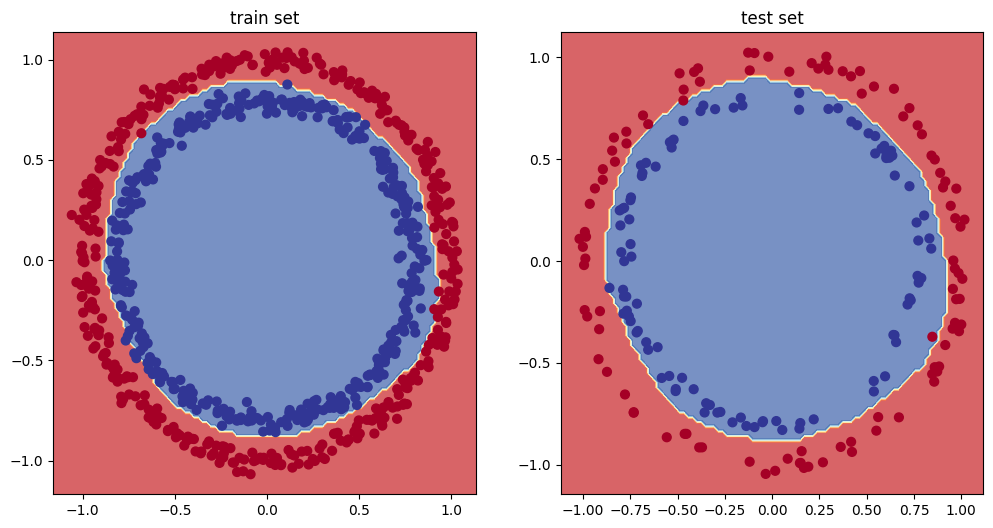

In [11]:
#plot the decision boundaries for the training and test sets:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train set")
plot_decision_boundary(model_7,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test set")
plot_decision_boundary(model_7,X_test,y_test)
plt.show()

In [12]:
import pandas as pd

Text(0.5, 1.0, 'Model_7 Training Curves')

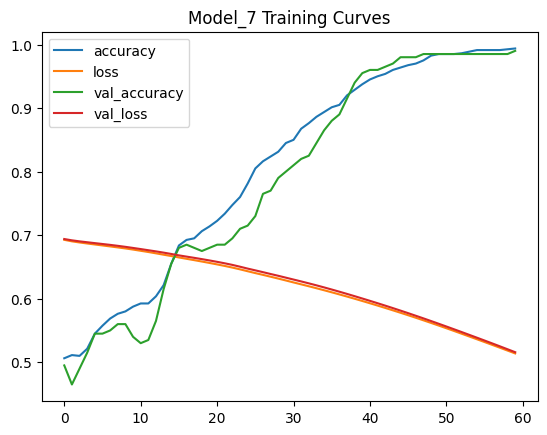

In [13]:
#plot the loss curves :
pd.DataFrame(history.history).plot()#for ever epoch there're values for loss and accuracy

plt.title("Model_7 Training Curves")

In [ ]:
#if you need to switch again to try TPE sampler:
# tpe_sampler = optuna.samplers.TPESampler(seed=42)
# study_tpe = optuna.create_study(direction='maximize', sampler=tpe_sampler)

# # Use trials from grid search to initialize the TPE study
# for trial in study_grid.trials:
#     study_tpe.add_trial(trial)

# study_tpe.optimize(objective, n_trials=10)

# # Display results
# show_all_trials(study_tpe)